# **TEXT MINING**

## **Practice: Text analytics for a dataset of biomedical documents**

### Date: **24/05/2022**

### Author: **Víctor Manuel López Molina**

**The practice consists of building a model for the automatic classification of texts in the following
five categories**:
- Alzheimer
- Bladder cancer
- Breast Cancer
- Cervical Cancer
- Negative

The dataset was provided in class.
**Two different models will be developed and tested:**

**PART 2: Deep recurrent neural network (LSTM or GRU)**.

The idea is:
- Build the vocabulary of the most frequent words by setting everything to lowercase. You can
also manage numbers, remove irrelevant punctuation symbols, etc. That extra cleaning part
can help the model
- Build a deep recurrent neural network model. For word embeddings there are several
possibilities: build them within the model (as an internal layer to the model), use previously
trained embeddings (with word2vec, or downloaded from the internet), etc.
Test different configurations trying to optimize the model

**The practice can be delivered in one of the following two formats:**

- Notebook with code + pdf with results memory.
- Notebook where the results are summarized and explained in "markdown" cells contained in the
notebook.

**What should the results summary contain? (in both delivery formats):**
- Summary of cleaning techniques, preprocessing, vocabulary construction used, tested
parameter values, and results obtained
- Summary of embedding techniques used, tested midwifery values (for example number of
dimensions), and results obtained
- Summary of tested models, values of parameters studied (for example in a neural network type
of layers, number of neurons, regularization midwives, etc.) and quality indicators of the model.
To measure the quality of the model, the score (hit rate) and the confusion matrix will be used.
The degree of overfitting of the model (level of degradation of test scores with respect to
training) will also be analyzed.

In the results section, it is expected that there will be at least one results table for each of the three
previous sections.

As a guide, if it is decided to deliver the work in notebook + pdf format with results memory, the
expected length of the memory will be around 15-20 pages (including graphs, tables, results and
explanation of results).

Finally, it is important that the results are explained and reasoned in memory (if the score with one
configuration is worse than with another, reason an explanation).

# **DEEP RECURRENT NEURAL NETWORK (LSTM)**

## **0. Importación de paquetes, funciones auxiliares, *datasets* y preprocesado de los mismos**

### **0.1: Importación de los paquetes y funciones auxiliares**

In [ ]:
COLAB = True # si has descargado la carpeta en tu ordenador y quieres
             # correrlo localmente (tienes que tener Anaconda / Tensorflow / Keras instalados)
             # pon COLAB a False

In [ ]:
if COLAB:
    %tensorflow_version 1.x

In [ ]:
#Instalación de los paquetes necesarios:

import pandas as pd
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import re
from nltk.stem import WordNetLemmatizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV,RepeatedStratifiedKFold
from sklearn.metrics import make_scorer,balanced_accuracy_score
from sklearn.feature_selection import SelectFromModel
pd.options.display.max_colwidth = 100

In [ ]:
#Importación de paquetes adicionales necesarios:

import os
from glob import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

from keras.models import Sequential, load_model, Model
from keras.layers import Dense, LSTM, Dropout
from keras.layers.embeddings import Embedding
from keras import regularizers
from keras.constraints import UnitNorm
from keras.preprocessing import sequence
from keras.optimizers import Adam
from keras.preprocessing.text import Tokenizer

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import pairwise_distances, cosine_distances

import bokeh.plotting as bp
from bokeh.models import HoverTool, BoxSelectTool, LabelSet, ColumnDataSource, Range1d
from bokeh.plotting import figure, show, output_notebook

from gensim.models.word2vec import Word2Vec # word2vec model gensim class
from gensim.models.doc2vec import TaggedDocument

from IPython.display import SVG, clear_output, display
from IPython.display import HTML as html_print
from keras.utils.vis_utils import model_to_dot
import pickle
import urllib

# fix random seed for reproducibility
np.random.seed(7)

%matplotlib inline

In [ ]:
def grafica_entrenamiento(tr_acc, val_acc, tr_loss, val_loss, best_i,
                          figsize=(10,4)):
    plt.figure(figsize=figsize)
    ax = plt.subplot(1,2,1)
    plt.plot(1+np.arange(len(tr_acc)),  100*np.array(tr_acc))
    plt.plot(1+np.arange(len(val_acc)), 100*np.array(val_acc))
    plt.plot(1+best_i, 100*val_acc[best_i], 'or')
    plt.title('tasa de acierto del modelo (%)', fontsize=18)
    plt.ylabel('tasa de acierto (%)', fontsize=18)
    plt.xlabel('época', fontsize=18)
    plt.legend(['entrenamiento', 'validación'], loc='upper left')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

    plt.subplot(1,2,2)
    plt.plot(1+np.arange(len(tr_acc)), np.array(tr_loss))
    plt.plot(1+np.arange(len(val_acc)), np.array(val_loss))
    plt.plot(1+best_i, val_loss[best_i], 'or')
    plt.title('loss del modelo', fontsize=18)
    plt.ylabel('loss', fontsize=18)
    plt.xlabel('época', fontsize=18)
    plt.legend(['entrenamiento', 'validación'], loc='upper left')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.show()

### **0.2: Importación de los *datasets***

In [ ]:
# Importación de los datasets:

if COLAB:
    from google_drive_downloader import GoogleDriveDownloader as gdd
    ficheros = [('1Z5MlJaUPmWQdvKDK474VVAnsXBgDWWAp', './Alzheimer_abstracts.tsv'),
                ('11BAN4eMl7ZNwM3jTo_6RAwP7JSbU6Jj7', './Bladder_Cancer_abstracts.tsv'),
                ('1symeSwQfX9NAESQUPMVwbOMZEkHMA4DD', './Breast_Cancer_abstracts.tsv'),
                ('1blBKcPMG3v10Nelvzyi4qGYGsCaLE9SQ', './Cervical_Cancer_abstracts.tsv'),
                ('120o0IhcGhvIc36jk8GKQLlVOEogUxHnx', './negative_abstracts.tsv')]
    for f in ficheros:
      gdd.download_file_from_google_drive(file_id=f[0], dest_path=f[1], overwrite=True, showsize=True)

1.5 MiB Done.
1.5 MiB Done.
1.6 MiB Done.
1.6 MiB Done.
1.5 MiB Done.


In [ ]:
!ls

Alzheimer_abstracts.tsv       Cervical_Cancer_abstracts.tsv
Bladder_Cancer_abstracts.tsv  negative_abstracts.tsv
Breast_Cancer_abstracts.tsv   sample_data


Tras haber importado los paquetes necesarios, vamos a disponer la información contenida en cada uno de los *datasets* cargados en una única tabla, en donde encontraremos todas las entradas de todos los *datasets* correspondiéndose cada entrada con una fila en dicha tabla final. Además, las columnas de la tabla serán un id de la entrada o artículo bibliográfico, el título del mismo, el *abstract* del mismo, el texto del mismo y el tipo o clase en el que se clasifica dicho artículo (por ejemplo, *bladder cancer* o *alzheimer*).

En primer lugar, vamos a generar dos listas, llamadas *dfs* y *file_names*, en donde se recojan el contenido de los *datasets* y sus nombres.

In [ ]:
dfs = []
file_names = []
for fichero in glob("./*.tsv"):
    df = pd.read_csv(fichero, sep="\t", header=None)
    df.columns = ["id", "title", "abstract"]
    dfs.append(df)
    file_names.append(fichero.split("/")[-1])

A continuación se muestra el nombre de los *datasets*, englobados en la variable *file_names*:

In [ ]:
file_names

['Breast_Cancer_abstracts.tsv',
 'Bladder_Cancer_abstracts.tsv',
 'Alzheimer_abstracts.tsv',
 'Cervical_Cancer_abstracts.tsv',
 'negative_abstracts.tsv']

A continuación se muestra el contenido de los *datasets*, recogido en la variable *dfs*. Esta variable es una lista en donde cada elemento es el contenido de cada *dataset* cargado. Por ejemplo, *dfs[0]* se corresponde con el contenido del *dataset* relativo al Alzheimer, algo que se muestra a continuación:

In [ ]:
dfs

[           id  \
 0    28424130   
 1    28423035   
 2    28422972   
 3    28420378   
 4    28420351   
 ..        ...   
 995  27848916   
 996  27847817   
 997  27847402   
 998  27847287   
 999  27847208   
 
                                                                                                    title  \
 0    Invasive Pleomorphic Lobular Histology Is an Adverse Prognostic Factor on Survival in Patients w...   
 1               Genetic profiling of putative breast cancer stem cells from malignant pleural effusions.   
 2    Challenges in enumeration of CTCs in breast cancer using techniques independent of cytokeratin e...   
 3    A cross-sectional survey assessing factors associated with reading cancer screening information:...   
 4    Prognostic significance of TRAIL-R3 and CCR-2 expression in tumor epithelial cells of patients w...   
 ..                                                                                                   ...   
 995               

In [ ]:
dfs[0].head()

,id,title,abstract
0,28424130,Invasive Pleomorphic Lobular Histology Is an Adverse Prognostic Factor on Survival in Patients w...,Invasive pleomorphic lobular carcinoma (IPLC) is defined to be an uncommon and different subtype...
1,28423035,Genetic profiling of putative breast cancer stem cells from malignant pleural effusions.,"A common symptom during late stage breast cancer disease is pleural effusion, which is related t..."
2,28422972,Challenges in enumeration of CTCs in breast cancer using techniques independent of cytokeratin e...,INTRODUCTION: Given the current postulated plasticity between epithelial and mesenchymal states ...
3,28420378,A cross-sectional survey assessing factors associated with reading cancer screening information:...,BACKGROUND: There is broad agreement that cancer screening invitees should know the risks and be...
4,28420351,Prognostic significance of TRAIL-R3 and CCR-2 expression in tumor epithelial cells of patients w...,"BACKGROUND: Tumor epithelial cells (TEpCs) and spindle-shaped stromal cells, not associated with..."


Ahora, vamos a tomar los nombres de los archivos y extraer los nombres de las patologías a partir de los mismos, guardándolos en la variable *type_names*:

In [ ]:
type_names = [x.replace("_abstracts.tsv", "")
              for x in file_names]
type_names

['Breast_Cancer', 'Bladder_Cancer', 'Alzheimer', 'Cervical_Cancer', 'negative']

Finalmente, en base a esta información extraída, vamos a generar la tabla final con la cual trabajaremos en esta práctica, en donde se recoge el contenido de todos los *datasets*, indicándose, para cada entrada o estudio de la tabla (es decir, para cada fila), la enfermedad con la que está asociado.

In [ ]:
ids       = []
titles    = []
abstracts = []
types     = []
for df,name in zip(dfs,type_names):
    ids.extend(list(df["id"]))
    titles.extend(list(df["title"]))
    abstracts.extend(list(df["abstract"]))
    types.extend(len(df)*[name])
len(abstracts), len(types)

(5000, 5000)

Esta es la tabla final con la que trabajaremos en esta práctica:

In [ ]:
data = pd.DataFrame({
    "id":ids,
    "title":titles,
    "abstract":abstracts,
    "text":abstracts,
    "type":types
})
data

,id,title,abstract,text,type
0,28424130,Invasive Pleomorphic Lobular Histology Is an Adverse Prognostic Factor on Survival in Patients w...,Invasive pleomorphic lobular carcinoma (IPLC) is defined to be an uncommon and different subtype...,Invasive pleomorphic lobular carcinoma (IPLC) is defined to be an uncommon and different subtype...,Breast_Cancer
1,28423035,Genetic profiling of putative breast cancer stem cells from malignant pleural effusions.,"A common symptom during late stage breast cancer disease is pleural effusion, which is related t...","A common symptom during late stage breast cancer disease is pleural effusion, which is related t...",Breast_Cancer
2,28422972,Challenges in enumeration of CTCs in breast cancer using techniques independent of cytokeratin e...,INTRODUCTION: Given the current postulated plasticity between epithelial and mesenchymal states ...,INTRODUCTION: Given the current postulated plasticity between epithelial and mesenchymal states ...,Breast_Cancer
3,28420378,A cross-sectional survey assessing factors associated with reading cancer screening information:...,BACKGROUND: There is broad agreement that cancer screening invitees should know the risks and be...,BACKGROUND: There is broad agreement that cancer screening invitees should know the risks and be...,Breast_Cancer
4,28420351,Prognostic significance of TRAIL-R3 and CCR-2 expression in tumor epithelial cells of patients w...,"BACKGROUND: Tumor epithelial cells (TEpCs) and spindle-shaped stromal cells, not associated with...","BACKGROUND: Tumor epithelial cells (TEpCs) and spindle-shaped stromal cells, not associated with...",Breast_Cancer
...,...,...,...,...,...
4995,27182736,Universal Coverage without Universal Access: Institutional Barriers to Health Care among Women S...,"BACKGROUND: Access to health care is a crucial determinant of health. Yet, even within settings ...","BACKGROUND: Access to health care is a crucial determinant of health. Yet, even within settings ...",negative
4996,26925253,Decreased use of glucocorticoids in biological-experienced patients with rheumatoid arthritis wh...,"INTRODUCTION: Prolonged glucocorticoid use may increase the risk of adverse safety outcomes, inc...","INTRODUCTION: Prolonged glucocorticoid use may increase the risk of adverse safety outcomes, inc...",negative
4997,27171471,Evaluating the Utility of Single-Locus DNA Barcoding for the Identification of Ribbon Worms (Phy...,Whereas many nemerteans (ribbon worms; phylum Nemertea) can be identified from external characte...,Whereas many nemerteans (ribbon worms; phylum Nemertea) can be identified from external characte...,negative
4998,26986421,Convection-driven kinematic dynamos at low Rossby and magnetic Prandtl numbers: Single mode solu...,"The onset of dynamo action is investigated within the context of a newly developed low Rossby, l...","The onset of dynamo action is investigated within the context of a newly developed low Rossby, l...",negative


En la siguiente celda, se demuestra que tenemos 1000 entradas o estudios asociados a cada patología o *dataset*, combinadas todas en la tabla *data*.

In [ ]:
data["type"].value_counts()

Breast_Cancer      1000
Bladder_Cancer     1000
Alzheimer          1000
Cervical_Cancer    1000
negative           1000
Name: type, dtype: int64

### **0.3: Pre-procesado de los *datasets***

Puesto que, cada vez que se inicia el entorno de ejecución, es necesario instalar los paquetes necesarios de *nltk* para el pre-procesado de los textos, vamos a instalarlos y cargarlos para poder llevar a cabo los pasos sucesivos de este apartado:

#### **0.3.1: Instalación e importación de los paquetes necesarios**

In [ ]:
import nltk
from string import punctuation
from nltk import word_tokenize
from nltk.corpus import stopwords
nltk.download("punkt")
nltk.download("wordnet")
nltk.download("stopwords")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

#### **0.3.2: Reordenación alfabética de los textos**

In [ ]:
data = data.sort_values("text").reset_index(drop=True)
data

,id,title,abstract,text,type
0,27816982,Cytology at the Time of HPV: Some Things to Think about when Discussing HPV.,"'In the current 28 Member States of the European Union (EU), approximately 34,000 new cases of c...","'In the current 28 Member States of the European Union (EU), approximately 34,000 new cases of c...",Cervical_Cancer
1,27092587,Production of precursors for anti-Alzheimer drugs: Asymmetric bioreduction in a packed-bed biore...,"(S)-1-Phenylethanol derivatives, which are the precursors of many pharmacological products, have...","(S)-1-Phenylethanol derivatives, which are the precursors of many pharmacological products, have...",Alzheimer
2,27486640,Empagliflozin (Jardiance). Type 2 diabetes: no rush to use this drug.,"* In early 2016, metformin monotherapy remains the treatment of choice for most patients with ty...","* In early 2016, metformin monotherapy remains the treatment of choice for most patients with ty...",Bladder_Cancer
3,27382284,A stabilizer-free and organic solvent-free method to prepare 10-hydroxycamptothecin nanocrystals...,10-Hydroxycamptothecin (10-HCPT) is a promising anticancer drug with a wide spectrum of antitumo...,10-Hydroxycamptothecin (10-HCPT) is a promising anticancer drug with a wide spectrum of antitumo...,negative
4,27354798,Elimination of the biphasic pharmacodynamics of 15d-PGJ2 by controlling its release from a nanoe...,"15-Deoxy-Delta12,14-prostaglandin J2 (15d-PGJ2) has a dual action of stimulating anti-inflammati...","15-Deoxy-Delta12,14-prostaglandin J2 (15d-PGJ2) has a dual action of stimulating anti-inflammati...",negative
...,...,...,...,...,...
4995,28000900,"miR-24-3p regulates bladder cancer cell proliferation, migration, invasion and autophagy by targ...","microRNAs (miRNAs), a class of small non-coding RNA molecules, can regulate gene expression by i...","microRNAs (miRNAs), a class of small non-coding RNA molecules, can regulate gene expression by i...",Bladder_Cancer
4996,26919225,The role of urinary pH in o-phenylphenol-induced cytotoxicity and chromosomal damage in the blad...,o-Phenylphenol (OPP) is a widely used fungicide and antibacterial agent that at high doses has b...,o-Phenylphenol (OPP) is a widely used fungicide and antibacterial agent that at high doses has b...,Bladder_Cancer
4997,27199504,Prognostic and Clinicopathological Significance of Downregulated p16 Expression in Patients with...,"p16, encoded by the CDKN2A gene, is a tumor suppressor that has been widely studied in cancer re...","p16, encoded by the CDKN2A gene, is a tumor suppressor that has been widely studied in cancer re...",Bladder_Cancer
4998,27222134,P21 and p27 Immunoexpression in Upper Urinary Tract Urothelial Carcinomas.,"p21 and p27 are members of cyclin-dependent kinase family, which function as tumor suppressors a...","p21 and p27 are members of cyclin-dependent kinase family, which function as tumor suppressors a...",Bladder_Cancer


#### **0.3.3: Eliminación de espaciados adicionales**

Puesto que, tras obtener la tabla sobre la cual trabajar, algunas entradas tenían espaciados repetidos, éstos se han eliminado con el siguiente comando, de forma que los espaciados fuesen en todos los casos de un único espacio:

In [ ]:
data_no_additional_spaces=data.replace(" +"," ") #Sustituir múltiples espacios por uno solo.
data_no_additional_spaces

,id,title,abstract,text,type
0,27816982,Cytology at the Time of HPV: Some Things to Think about when Discussing HPV.,"'In the current 28 Member States of the European Union (EU), approximately 34,000 new cases of c...","'In the current 28 Member States of the European Union (EU), approximately 34,000 new cases of c...",Cervical_Cancer
1,27092587,Production of precursors for anti-Alzheimer drugs: Asymmetric bioreduction in a packed-bed biore...,"(S)-1-Phenylethanol derivatives, which are the precursors of many pharmacological products, have...","(S)-1-Phenylethanol derivatives, which are the precursors of many pharmacological products, have...",Alzheimer
2,27486640,Empagliflozin (Jardiance). Type 2 diabetes: no rush to use this drug.,"* In early 2016, metformin monotherapy remains the treatment of choice for most patients with ty...","* In early 2016, metformin monotherapy remains the treatment of choice for most patients with ty...",Bladder_Cancer
3,27382284,A stabilizer-free and organic solvent-free method to prepare 10-hydroxycamptothecin nanocrystals...,10-Hydroxycamptothecin (10-HCPT) is a promising anticancer drug with a wide spectrum of antitumo...,10-Hydroxycamptothecin (10-HCPT) is a promising anticancer drug with a wide spectrum of antitumo...,negative
4,27354798,Elimination of the biphasic pharmacodynamics of 15d-PGJ2 by controlling its release from a nanoe...,"15-Deoxy-Delta12,14-prostaglandin J2 (15d-PGJ2) has a dual action of stimulating anti-inflammati...","15-Deoxy-Delta12,14-prostaglandin J2 (15d-PGJ2) has a dual action of stimulating anti-inflammati...",negative
...,...,...,...,...,...
4995,28000900,"miR-24-3p regulates bladder cancer cell proliferation, migration, invasion and autophagy by targ...","microRNAs (miRNAs), a class of small non-coding RNA molecules, can regulate gene expression by i...","microRNAs (miRNAs), a class of small non-coding RNA molecules, can regulate gene expression by i...",Bladder_Cancer
4996,26919225,The role of urinary pH in o-phenylphenol-induced cytotoxicity and chromosomal damage in the blad...,o-Phenylphenol (OPP) is a widely used fungicide and antibacterial agent that at high doses has b...,o-Phenylphenol (OPP) is a widely used fungicide and antibacterial agent that at high doses has b...,Bladder_Cancer
4997,27199504,Prognostic and Clinicopathological Significance of Downregulated p16 Expression in Patients with...,"p16, encoded by the CDKN2A gene, is a tumor suppressor that has been widely studied in cancer re...","p16, encoded by the CDKN2A gene, is a tumor suppressor that has been widely studied in cancer re...",Bladder_Cancer
4998,27222134,P21 and p27 Immunoexpression in Upper Urinary Tract Urothelial Carcinomas.,"p21 and p27 are members of cyclin-dependent kinase family, which function as tumor suppressors a...","p21 and p27 are members of cyclin-dependent kinase family, which function as tumor suppressors a...",Bladder_Cancer


#### **0.3.4: Eliminación de las cabeceras (*BACKGROUND*, *CONCLUSIONS*,etc)**

Tras esto, además, puesto que para los *abstracts* de los estudios existen secciones como *BACKGROUND*, *CONCLUSIONS*, *METHODS*, etc., estos también se han eliminado, por medio de la siguiente expresión regular:

In [ ]:
data_processed=data_no_additional_spaces.replace("([A-Z]+: |[A-Z]+ ([A-Z]+)*: )","",regex=True) #Eliminar los section names
data_processed

,id,title,abstract,text,type
0,27816982,Cytology at the Time of Some Things to Think about when Discussing HPV.,"'In the current 28 Member States of the European Union (EU), approximately 34,000 new cases of c...","'In the current 28 Member States of the European Union (EU), approximately 34,000 new cases of c...",Cervical_Cancer
1,27092587,Production of precursors for anti-Alzheimer drugs: Asymmetric bioreduction in a packed-bed biore...,"(S)-1-Phenylethanol derivatives, which are the precursors of many pharmacological products, have...","(S)-1-Phenylethanol derivatives, which are the precursors of many pharmacological products, have...",Alzheimer
2,27486640,Empagliflozin (Jardiance). Type 2 diabetes: no rush to use this drug.,"* In early 2016, metformin monotherapy remains the treatment of choice for most patients with ty...","* In early 2016, metformin monotherapy remains the treatment of choice for most patients with ty...",Bladder_Cancer
3,27382284,A stabilizer-free and organic solvent-free method to prepare 10-hydroxycamptothecin nanocrystals...,10-Hydroxycamptothecin (10-HCPT) is a promising anticancer drug with a wide spectrum of antitumo...,10-Hydroxycamptothecin (10-HCPT) is a promising anticancer drug with a wide spectrum of antitumo...,negative
4,27354798,Elimination of the biphasic pharmacodynamics of 15d-PGJ2 by controlling its release from a nanoe...,"15-Deoxy-Delta12,14-prostaglandin J2 (15d-PGJ2) has a dual action of stimulating anti-inflammati...","15-Deoxy-Delta12,14-prostaglandin J2 (15d-PGJ2) has a dual action of stimulating anti-inflammati...",negative
...,...,...,...,...,...
4995,28000900,"miR-24-3p regulates bladder cancer cell proliferation, migration, invasion and autophagy by targ...","microRNAs (miRNAs), a class of small non-coding RNA molecules, can regulate gene expression by i...","microRNAs (miRNAs), a class of small non-coding RNA molecules, can regulate gene expression by i...",Bladder_Cancer
4996,26919225,The role of urinary pH in o-phenylphenol-induced cytotoxicity and chromosomal damage in the blad...,o-Phenylphenol (OPP) is a widely used fungicide and antibacterial agent that at high doses has b...,o-Phenylphenol (OPP) is a widely used fungicide and antibacterial agent that at high doses has b...,Bladder_Cancer
4997,27199504,Prognostic and Clinicopathological Significance of Downregulated p16 Expression in Patients with...,"p16, encoded by the CDKN2A gene, is a tumor suppressor that has been widely studied in cancer re...","p16, encoded by the CDKN2A gene, is a tumor suppressor that has been widely studied in cancer re...",Bladder_Cancer
4998,27222134,P21 and p27 Immunoexpression in Upper Urinary Tract Urothelial Carcinomas.,"p21 and p27 are members of cyclin-dependent kinase family, which function as tumor suppressors a...","p21 and p27 are members of cyclin-dependent kinase family, which function as tumor suppressors a...",Bladder_Cancer


#### **0.3.5: Transformación de los datos para que estén en minúscula**

A continuación, con las cabeceras ya eliminadas de la tabla, vamos a volver todo el contenido de la misma en minúscula, para así poder aplicar los pasos sucesivos:

In [ ]:
data_lower=data_processed.applymap(lambda x: x.lower() if type(x) == str else x) #Todo minúscula
data_lower

,id,title,abstract,text,type
0,27816982,cytology at the time of some things to think about when discussing hpv.,"'in the current 28 member states of the european union (eu), approximately 34,000 new cases of c...","'in the current 28 member states of the european union (eu), approximately 34,000 new cases of c...",cervical_cancer
1,27092587,production of precursors for anti-alzheimer drugs: asymmetric bioreduction in a packed-bed biore...,"(s)-1-phenylethanol derivatives, which are the precursors of many pharmacological products, have...","(s)-1-phenylethanol derivatives, which are the precursors of many pharmacological products, have...",alzheimer
2,27486640,empagliflozin (jardiance). type 2 diabetes: no rush to use this drug.,"* in early 2016, metformin monotherapy remains the treatment of choice for most patients with ty...","* in early 2016, metformin monotherapy remains the treatment of choice for most patients with ty...",bladder_cancer
3,27382284,a stabilizer-free and organic solvent-free method to prepare 10-hydroxycamptothecin nanocrystals...,10-hydroxycamptothecin (10-hcpt) is a promising anticancer drug with a wide spectrum of antitumo...,10-hydroxycamptothecin (10-hcpt) is a promising anticancer drug with a wide spectrum of antitumo...,negative
4,27354798,elimination of the biphasic pharmacodynamics of 15d-pgj2 by controlling its release from a nanoe...,"15-deoxy-delta12,14-prostaglandin j2 (15d-pgj2) has a dual action of stimulating anti-inflammati...","15-deoxy-delta12,14-prostaglandin j2 (15d-pgj2) has a dual action of stimulating anti-inflammati...",negative
...,...,...,...,...,...
4995,28000900,"mir-24-3p regulates bladder cancer cell proliferation, migration, invasion and autophagy by targ...","micrornas (mirnas), a class of small non-coding rna molecules, can regulate gene expression by i...","micrornas (mirnas), a class of small non-coding rna molecules, can regulate gene expression by i...",bladder_cancer
4996,26919225,the role of urinary ph in o-phenylphenol-induced cytotoxicity and chromosomal damage in the blad...,o-phenylphenol (opp) is a widely used fungicide and antibacterial agent that at high doses has b...,o-phenylphenol (opp) is a widely used fungicide and antibacterial agent that at high doses has b...,bladder_cancer
4997,27199504,prognostic and clinicopathological significance of downregulated p16 expression in patients with...,"p16, encoded by the cdkn2a gene, is a tumor suppressor that has been widely studied in cancer re...","p16, encoded by the cdkn2a gene, is a tumor suppressor that has been widely studied in cancer re...",bladder_cancer
4998,27222134,p21 and p27 immunoexpression in upper urinary tract urothelial carcinomas.,"p21 and p27 are members of cyclin-dependent kinase family, which function as tumor suppressors a...","p21 and p27 are members of cyclin-dependent kinase family, which function as tumor suppressors a...",bladder_cancer


#### **0.3.6: Tokenización de los textos**

Tras esto, y antes de eliminar los signos de puntuación (ya que no vamos a eliminar los *stopwords* para generar modelos de redes neuronales), vamos a tokenizar todos los *abstracts* de la tabla, esto es, transformar las frases en unidades más pequeñas llamadas ***tokens***, en este caso palabras:

In [ ]:
tokenized_text=data_lower["text"].apply(lambda x: word_tokenize(x)) #Tokenizamos los textos.
tokenized_text

0       ['in, the, current, 28, member, states, of, the, european, union, (, eu, ), ,, approximately, 34...
1       [(, s, ), -1-phenylethanol, derivatives, ,, which, are, the, precursors, of, many, pharmacologic...
2       [*, in, early, 2016, ,, metformin, monotherapy, remains, the, treatment, of, choice, for, most, ...
3       [10-hydroxycamptothecin, (, 10-hcpt, ), is, a, promising, anticancer, drug, with, a, wide, spect...
4       [15-deoxy-delta12,14-prostaglandin, j2, (, 15d-pgj2, ), has, a, dual, action, of, stimulating, a...
                                                       ...                                                 
4995    [micrornas, (, mirnas, ), ,, a, class, of, small, non-coding, rna, molecules, ,, can, regulate, ...
4996    [o-phenylphenol, (, opp, ), is, a, widely, used, fungicide, and, antibacterial, agent, that, at,...
4997    [p16, ,, encoded, by, the, cdkn2a, gene, ,, is, a, tumor, suppressor, that, has, been, widely, s...
4998    [p21, and, p27, are,

#### **0.3.7: Definición de los signos de puntuación en una variable**

In [ ]:
signos_punt=punctuation #Definimos los signos de puntuación.
signos_punt

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

#### **0.3.8: Eliminación de los signos de puntuación**

A continuación, vamos a eliminar los signos de puntuación de los *abstracts* tokenizados.

In [ ]:
removed_stopwords=tokenized_text.apply(lambda x: ' '.join([word for word in x if word not in (signos_punt)])) #Eliminamos los stopwords y los signos de puntuación.
data_lower["text"]=removed_stopwords

A continuación, podemos observar la tabla con los textos ya transformados:

In [ ]:
data_lower

,id,title,abstract,text,type
0,27816982,cytology at the time of some things to think about when discussing hpv.,"'in the current 28 member states of the european union (eu), approximately 34,000 new cases of c...","'in the current 28 member states of the european union eu approximately 34,000 new cases of cerv...",cervical_cancer
1,27092587,production of precursors for anti-alzheimer drugs: asymmetric bioreduction in a packed-bed biore...,"(s)-1-phenylethanol derivatives, which are the precursors of many pharmacological products, have...",s -1-phenylethanol derivatives which are the precursors of many pharmacological products have al...,alzheimer
2,27486640,empagliflozin (jardiance). type 2 diabetes: no rush to use this drug.,"* in early 2016, metformin monotherapy remains the treatment of choice for most patients with ty...",in early 2016 metformin monotherapy remains the treatment of choice for most patients with type ...,bladder_cancer
3,27382284,a stabilizer-free and organic solvent-free method to prepare 10-hydroxycamptothecin nanocrystals...,10-hydroxycamptothecin (10-hcpt) is a promising anticancer drug with a wide spectrum of antitumo...,10-hydroxycamptothecin 10-hcpt is a promising anticancer drug with a wide spectrum of antitumor ...,negative
4,27354798,elimination of the biphasic pharmacodynamics of 15d-pgj2 by controlling its release from a nanoe...,"15-deoxy-delta12,14-prostaglandin j2 (15d-pgj2) has a dual action of stimulating anti-inflammati...","15-deoxy-delta12,14-prostaglandin j2 15d-pgj2 has a dual action of stimulating anti-inflammation...",negative
...,...,...,...,...,...
4995,28000900,"mir-24-3p regulates bladder cancer cell proliferation, migration, invasion and autophagy by targ...","micrornas (mirnas), a class of small non-coding rna molecules, can regulate gene expression by i...",micrornas mirnas a class of small non-coding rna molecules can regulate gene expression by inter...,bladder_cancer
4996,26919225,the role of urinary ph in o-phenylphenol-induced cytotoxicity and chromosomal damage in the blad...,o-phenylphenol (opp) is a widely used fungicide and antibacterial agent that at high doses has b...,o-phenylphenol opp is a widely used fungicide and antibacterial agent that at high doses has bee...,bladder_cancer
4997,27199504,prognostic and clinicopathological significance of downregulated p16 expression in patients with...,"p16, encoded by the cdkn2a gene, is a tumor suppressor that has been widely studied in cancer re...",p16 encoded by the cdkn2a gene is a tumor suppressor that has been widely studied in cancer rese...,bladder_cancer
4998,27222134,p21 and p27 immunoexpression in upper urinary tract urothelial carcinomas.,"p21 and p27 are members of cyclin-dependent kinase family, which function as tumor suppressors a...",p21 and p27 are members of cyclin-dependent kinase family which function as tumor suppressors an...,bladder_cancer


Una vez ya hemos pre-procesado los *abstracts*, vamos a separar las 5000 entradas o estudios de la tabla procesada en un *training set* y un *test set* al azar, con el fin de evaluar posteriormente varios modelos de redes neuronales:

#### **0.3.9: *Train-test split***

In [ ]:
from sklearn.model_selection import train_test_split

data_train, data_test, y_train, y_test = train_test_split(data_lower, data_lower["type"], test_size=0.3,
                                         random_state=1,
                                         stratify=data_lower["type"])


In [ ]:
len(data_train), len(y_train), len(data_test), len(y_test)

(3500, 3500, 1500, 1500)

Una vez ya hemos pre-procesado los textos y los hemos dividido en dos sets, vamos a realizar varios experimentos en los que evaluaremos redes neuronales y su *performance* frente a nuestros *datasets*, por medio de su *accuracy*. En cada experimento, utilizaremos unos valores concretos de diversos hiperparámetros.

## **1. Experimento 1**

A continuación, para este experimento y los sucesivos, vamos a indicar los valores utilizados para los hiperparámetros. En este caso, son los siguientes:

**VALORES QUE SE USARÁN PARA LOS HIPERPARÁMETROS**:


*   **top_words** = 5000
*   **max_review_length** = 250
*   **embedding_vector_length** = 10
*   **n_neurons** = 8
*   **l** = 0.0005
*   **Dropout**(rate = 0.3)



### **1.1: Determinación de las palabras más frecuentes**

En primer lugar, vamos a establecer las 5 clases en las que se pueden encasillar nuestros *abstracts*. A partir de ahí, intentaremos, en última instancia, clasificar estos textos y extraer las palabras más frecuentes o que más se asocian a cada categoría.

In [ ]:
classes2int = {"alzheimer":0, "negative":4, "breast_cancer":1,
              "cervical_cancer":2, "bladder_cancer":3}

A continuación, en base a la categoría a la que pertenece cada *abstract* (esto lo podíamos consultar en base a la última columna de la tabla "data"), vamos a numerar los *abstracts* siguiendo este criterio, tanto para la partición *training* como la partición *test*:

In [ ]:
y_train = [classes2int[x] for x in y_train]
y_test  = [classes2int[x] for x in y_test]
print(y_train)
print(y_test)

[3, 3, 1, 1, 3, 3, 3, 2, 4, 0, 4, 1, 0, 2, 4, 4, 3, 1, 1, 1, 3, 0, 0, 4, 2, 0, 0, 0, 2, 1, 2, 3, 0, 0, 1, 3, 0, 4, 4, 1, 2, 4, 3, 0, 1, 4, 1, 4, 3, 3, 4, 1, 1, 0, 2, 4, 4, 1, 2, 2, 3, 1, 2, 1, 3, 0, 2, 2, 4, 2, 4, 3, 2, 1, 0, 0, 1, 3, 2, 2, 3, 3, 3, 0, 3, 0, 4, 3, 0, 4, 4, 2, 1, 1, 1, 1, 0, 4, 1, 0, 1, 1, 2, 0, 1, 0, 3, 4, 4, 3, 3, 4, 3, 0, 3, 2, 3, 4, 2, 2, 0, 0, 3, 3, 1, 3, 0, 3, 0, 2, 3, 1, 3, 0, 4, 3, 0, 1, 3, 3, 3, 4, 1, 0, 1, 2, 4, 0, 4, 2, 3, 1, 3, 2, 0, 0, 3, 0, 3, 3, 1, 2, 0, 4, 2, 3, 3, 0, 2, 1, 1, 2, 4, 4, 3, 0, 0, 2, 3, 1, 4, 4, 1, 3, 4, 4, 4, 0, 4, 3, 3, 4, 2, 3, 2, 3, 1, 0, 4, 3, 4, 4, 0, 0, 1, 4, 4, 3, 2, 1, 2, 4, 1, 4, 1, 1, 0, 0, 3, 0, 4, 2, 1, 0, 3, 3, 4, 4, 1, 0, 0, 0, 4, 4, 2, 1, 2, 4, 0, 3, 3, 0, 1, 4, 2, 0, 4, 0, 0, 0, 0, 4, 2, 1, 2, 4, 4, 2, 1, 4, 3, 0, 0, 2, 0, 1, 2, 4, 0, 3, 2, 3, 0, 0, 0, 0, 0, 0, 0, 3, 0, 4, 1, 2, 4, 2, 3, 1, 4, 0, 2, 2, 3, 4, 1, 0, 4, 2, 3, 1, 2, 4, 1, 0, 1, 4, 2, 4, 3, 2, 4, 4, 4, 1, 3, 3, 3, 0, 4, 4, 2, 4, 1, 2, 4, 0, 1, 4, 1, 3, 3, 3, 1, 

In [ ]:
data_train["text"]

1369    ureteroarterial fistulas are rare we describe a case of ureteral-arterial fistulas uaf repaired ...
4298    the human bladder cancer bc diagnostics is being improvised every day for the better management ...
3063    to determine the possible effect of two homeopathic medicines ruta graveolens 5ch and rhus toxic...
2413    in cancer vulnerable breast epithelium malignance tendency correlates with number and activation...
2168    imrt planning with commercial treatment planning systems tpss is a trial-and-error process conse...
                                                       ...                                                 
2819    neurodegenerative disorders including alzheimer 's disease parkinson 's disease and huntington '...
907     gastrointestinal and extraintestinal malignancies are long-term complications in patients with i...
2159    hypoxia-inducible factors hifs have been shown to be upregulated in tumor tissues and linked wit...
4172    the angiotensin 1-7 

In [ ]:
data_train["text"][1368]

'ureteroarterial fistulas are rare we describe a case of ureteral-arterial fistulas uaf repaired with an endovascular stent graft and examine late complications associated with the procedure a 37-year-old woman with a history of complicated locally invasive cervical cancer treated with chemoradiation presented initially with right leg rest pain and chronic intermittent gross hematuria she was found to have an ureteroarterial fistula and underwent successful endovascular exclusion with a covered stent with resolution of her symptoms she returned 1 year later with stent-graft thrombosis manifesting as lower extremity rest pain requiring a femoral-femoral bypass she then returned 6 months later with imaging evidence of extravascular migration of the stent graft into the bladder because of a poor prognosis of recurrent gynecologic cancer extraction was not attempted and she underwent complete urinary diversion uafs are a rare occurrence but may be treated successfully with endovascular ste

Tras los pasos anteriores, el siguiente paso será definir el tamaño de nuestro vocabulario para la construcción de redes neuronales artificiales. Para ello, se tomarán las n palabras más frecuentes, en función del valor de la variable *top_words* que vemos en la celda inferior. Este es el primer hiperparámetro que calibraremos a lo largo de los diversos experimentos expuestos en este informe:

In [ ]:
top_words = 5000 # HYPERPARAMETER, VOCABULARY SIZE

tk = Tokenizer(oov_token='(oov)', num_words=(top_words-1))
tk.fit_on_texts(data_train["text"])

A continuación, vamos a crear un *array* para cada uno de los *abstracts* de tanto el *training set* como el *test set*, de forma que a cada palabra se le asigne un identificador numérico, el cual no se asigna por orden de aparición en el texto. Cabe destacar que todos estos *arrays* comienzan por el 1, que no se corresponde con ninguna de las palabras del texto, sino que simplemente indica el inicio. Además, el número 2 tampoco se corresponde con ninguna palabra, sino que se refiere a palabras *oov* (del inglés, *out of vocabulary*), que son palabras poco frecuentes y que no han entrado en nuestro vocabulario de palabras frecuentes (variable *top_words*). 

In [ ]:
X_train  = [np.array([0] + x)+1 for x in tk.texts_to_sequences(data_train["text"])]
X_test   = [np.array([0] + x)+1 for x in tk.texts_to_sequences(data_test["text"])]

In [ ]:
X_train[0]

array([   1,    2,    2,   27,  490,   23,  869,    8,  197,    4, 2364,
       3058,    2,    2,    2,    9,   30, 4995, 2279, 4523,    5,  836,
        809,  555,   53,    9,    3,  762,    8,  787,  166,  386, 1310,
          9,    8,  508,    4, 3985, 1396,  230,   39,   13,  159,    9,
       2544,  543, 2016,    9,  700,    2, 3494,  424,    5,  621,    2,
       2821, 2401, 1325,   11,  101,    7,   43,   30,    2, 2609,    5,
        251, 1616, 4995, 3604,    9,    8, 2402, 2279,    9, 1953,    4,
       1415,  354, 1325, 4320,   20,  166, 1299,    9, 2279, 4523,    2,
          2,   18,  214,    2, 3494,  424, 2981,    8, 2545, 2545,    2,
       1325,  540, 4320,   65,  155, 1299,    9,  187,  189,    4,    2,
        391,    4,    3, 2279, 4523,  162,    3,   44,  444,    4,    8,
        480,  397,    4, 1047, 1247,   13, 2403,   11,   51,    2,    5,
       1325,  251,  701,  269, 2049,    2,   27,    8,  490, 1326,   87,
         62,   28,  159, 1483,    9, 4995, 2279,   

En la siguiente celda, podemos comprobar efectivamente que existen 5000 identificadores numéricos, pues habíamos indicado anteriormente que *top_words=5000*.

In [ ]:
min([x.min() for x in X_train]), max([x.max() for x in X_train]), min([x.min() for x in X_test]), max([x.max() for x in X_test])

(1, 4999, 1, 4999)

A continuación, vamos a determinar cuáles son las 20 palabras más frecuentes en nuestro vocabulario de longitud 5000. Nótese, de nuevo, como los identificadores 0, 1 y 2 están reservados para *padding*, *start* y *oov*, respectivamente.

In [ ]:
int2word = {(i+1):tk.index_word[i] for i in range(1,top_words-1)} # el 0 no está incluido, se reserva para padding
int2word[0] = "(padding)"
int2word[1] = "(start)"

word2int = {int2word[i]:i for i in range(top_words)}

In [ ]:
int2word[0], int2word[1], int2word[2], int2word[1999], word2int["the"]

('(padding)', '(start)', '(oov)', 'needle', 3)

20 palabras más frecuentes:

In [ ]:
for i in range(20):
    print(i, int2word[i])

0 (padding)
1 (start)
2 (oov)
3 the
4 of
5 and
6 in
7 to
8 a
9 with
10 for
11 was
12 were
13 cancer
14 is
15 patients
16 that
17 0
18 as
19 by


Además, en la siguiente celda, podemos tomar un texto en concreto, ver el *array* de identificadores numéricos y qué identificador le corresponde a cada palabra del texto original:

In [ ]:
ejemplo = 1

print(X_train[ejemplo], "\n") #Array con los índices asociados a cada palabra del texto.
print("\033[1m"+"Índices y sus palabras asociadas:")
for i,x in enumerate(X_train[ejemplo][:50]):
  print("{} -> {}".format(x, int2word[x])) #Se muestra el índice junto con su palabra asociada.
if (i+1)<len(X_train[ejemplo]): 
  print("...")
print("Class: {}".format(y_train[ejemplo])) 

[   1    3   90   44   13  487 3233   14  457    2 1450  723   10    3
  358  311    5 1554  114    3  157  275    4   78   45    2   14    7
    2 4149   38    5  782    4  487   15  328  936  363   89  230   18
  124   18  132  230  264    2    3 1641    4    3 1901    4 1379   14
    3    2  165    3 3605    6    3    2  763   14    3 3401    4 4321
    4    2   10  358    5  520  148  114    3  139  151  847  349   28
 1248   21    3 3605  328  264   10    3  358  114    4  487  440 3401
    4   47 2280 2129 4150   47   53 3722    2    2   44   47 1249 3402
   10    3  176  487  114] 

Índices y sus palabras asociadas:
1 -> (start)
3 -> the
90 -> human
44 -> bladder
13 -> cancer
487 -> bc
3233 -> diagnostics
14 -> is
457 -> being
2 -> (oov)
1450 -> every
723 -> day
10 -> for
3 -> the
358 -> better
311 -> management
5 -> and
1554 -> efficient
114 -> diagnosis
3 -> the
157 -> primary
275 -> aim
4 -> of
78 -> all
45 -> these
2 -> (oov)
14 -> is
7 -> to
2 -> (oov)
4149 -> timely
38 -> 

### **1.2: *Padding* de las palabras**

A continuación, tras haber asignado un identificador a cada palabra de cada texto y haber determinado las palabras más frecuentes en general, otro procedimiento de pre-procesado fundamental para el diseño de redes neuronales artificiales es el ***padding***, que consiste en normalizar el tamaño de los textos, es decir, que todos tengan la misma longitud. 

Esto lo haremos posible por medio de otro hiperparámetro llamado *max_review_length*, que determina a qué tamaño normalizamos todos los textos. Si un determinado texto tiene más tamaño que el indicado, se recortará para que tenga el tamaño exigido; mientras que si un texto es más pequeño a dicho tamaño, se alargará mediante identificadores numéricos de *padding*, que son el número 0, hasta llegar al número de palabras indicado en dicha variable.

In [ ]:
max_review_length = 250 #HIPERPARÁMETRO
X_train_pad = sequence.pad_sequences(X_train, maxlen=max_review_length)
X_test_pad = sequence.pad_sequences(X_test, maxlen=max_review_length)
int2word[0] = "(padding)"

print("Tamaño del dataset de training después del padding:", X_train_pad.shape)
print("Los códigos de palabras van de {} a {}".format(X_train_pad.min(), X_train_pad.max()))

Tamaño del dataset de training después del padding: (3500, 250)
Los códigos de palabras van de 0 a 4999


In [ ]:
data_train["text"]

1369    ureteroarterial fistulas are rare we describe a case of ureteral-arterial fistulas uaf repaired ...
4298    the human bladder cancer bc diagnostics is being improvised every day for the better management ...
3063    to determine the possible effect of two homeopathic medicines ruta graveolens 5ch and rhus toxic...
2413    in cancer vulnerable breast epithelium malignance tendency correlates with number and activation...
2168    imrt planning with commercial treatment planning systems tpss is a trial-and-error process conse...
                                                       ...                                                 
2819    neurodegenerative disorders including alzheimer 's disease parkinson 's disease and huntington '...
907     gastrointestinal and extraintestinal malignancies are long-term complications in patients with i...
2159    hypoxia-inducible factors hifs have been shown to be upregulated in tumor tissues and linked wit...
4172    the angiotensin 1-7 

Como vemos, para el primer texto de la partición *train* de los *abstracts*, este texto tenía menor longitud a la indicada en *max_review_length*, por lo que se le han añadido ceros al *array* de identificadores numéricos de dicho texto.

In [ ]:
X_train_pad[1368]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    1,    2,
         27, 2765,    2,  967, 4195,    7,    3,    2,    2,    5,    2,
        298,   72, 2549,    4,  123,  542,   27,    2,   16,   43,    8,
       1789,  131,   21,    3, 1574,   26,    3, 4167,    4, 2536,  136,
          2,   43,   57,  153,    7,  641,    3,   46,    4, 1394, 2178,
         36,  126,   18, 1394,  314,    4, 4787,    5, 2554,  524,  316,
         22,   62,   28, 2158,    9,    8,  273,  606,    4, 3056,   10,
        879,  981, 3056,    2,    7,   28,  281,  232,   91,  203,  226,
         87, 2165,  495,   14,  457,  153,  130, 2990,    2,   27, 1132,
        539,    7,   51,  867,    7,    3, 1901,    4, 2536,  495,    5,
         51, 4557,    2, 2536,  495, 2511,  136,    4,    2,    9, 3056,
         54,   57,  153,    7,  641,    3,  261, 12

### **1.3: Construcción de la red neuronal (LSTM)**

Una vez ya hemos transformado las palabras en identificadores numéricos, hemos determinado las palabras más frecuentes y hemos normalizado el tamaño de los textos, vamos a construir nuestra red neuronal artificial. Para ello, existen en la siguiente celda varios hiperparámetros que podemos calibrar: ***embedding_vector_length*** (correspondiente al tamaño del llamado *dense embedding*; es uno de los parámetros de la clase Embedding de Keras (que se corresponde a la *embedding layer* de nuestra red neuronal artificial, tal y como vimos en clase), que transforma índices numéricos enteros en "vectores densos" de una longitud concreta, que es precisamente la que indicamos con este hiperparámetro *embedding_vector_length*), ***N_NEURONS*** (correspondiente al número de neuronas de la red; es el principal parámetro de la clase LSTM de Keras), ***l*** (correspondiente a la función de regularización aplicada sobre la matriz de *embeddings*; puede aplicarse una penalización de regularización L1, L2 o de ambas) y ***Dropout*** (que introduce ruido de forma aleatoria en función de la variable *rate*, contribuyendo a reducir el *overfitting*).

In [ ]:
# HYPERPARAMETERS: ***
embedding_vector_length = 10 # HYPERPARAMETER
N_NEURONS = 8 #HYPERPARAMETER
# ********************


N_CLASSES = 5

rnn = LSTM
model_1 = Sequential()
model_1.add(Embedding(top_words, # número de palabras del vocabulario incluido 0 de padding.
                    embedding_vector_length, # número de dimensiones que quieres que tenga el embedding.
                    # l: "fuerza" del regularizador. Cuanto más alto, más regulariza.
                    embeddings_regularizer=regularizers.l1(l=0.0005), # regularización.
                    input_length=max_review_length)) # tamaño de la secuencia de palabras.
model_1.add(Dropout(rate=0.3))
model_1.add(rnn(N_NEURONS)) # MANY TO ONE (return_sequences no es True).
model_1.add(Dense(N_CLASSES, activation='softmax'))
model_1.compile(loss='sparse_categorical_crossentropy', # binarycrossentropy porque hay 2 clases, si hay más, categorical_crossentropy.
              optimizer=Adam(lr=0.001), # lr: velocidad de aprendizaje.
              metrics=['accuracy'])

A continuación, tras generar nuestra red neuronal, vamos a examinar sus características por medio del siguiente diagrama:

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 250, 10)           50000     
_________________________________________________________________
dropout_8 (Dropout)          (None, 250, 10)           0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 8)                 608       
_________________________________________________________________
dense_8 (Dense)              (None, 5)                 45        
Total params: 50,653
Trainable params: 50,653
Non-trainable params: 0
_________________________________________________________________


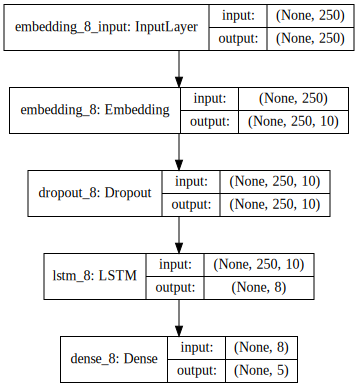

In [ ]:
model_1.summary()
if COLAB:
    display(SVG(model_to_dot(model_1,show_shapes=True,dpi=72).create(prog='dot', format='svg')))
else:
    display(SVG(model_to_dot(model_1,show_shapes=True).create(prog='dot', format='svg')))

Como podemos apreciar, partimos de una *input layer*, correspondiente a nuestros textos con sus índices numéricos, todos con una longitud igual a la indicada en *max_review_length*. De ahí, se pasa a la *embedding layer*, que transforma los índices numéricos en vectores de longitud *embedding_vector_length*. De ahí, se pasa a la *Dropout layer*, que introduce ruido en los vectores. Tras esto, se pasa a la capa *LSTM*, donde encontramos el número de neuronas que hubiésemos indicado en la variable *N_NEURONS*, y esto se aplica finalmente a las 5 clases que encontramos para nuestros textos en este caso. Todo esto puede apreciarse tanto en la tabla superior como en el diagrama inferior.

Además, en la tabla encontramos una tercera columna denominada "Param #", correspondiente al número de parámetros. Para la primera fila, en este caso, encontramos 50000, correspondiente a multiplicar el tamaño del vocabulario (que en este caso era 5000) por el valor de la variable *embedding_vector_length*. Para la segunda fila, por otro lado, encontramos el valor 0, ya que esta función simplemente introduce ruido transformando valores en ceros.

#### **Reservamos, dentro del conjunto de *training*, un subconjunto de validación**

In [ ]:
# Entreno sobre X_tr,y_tr monitorizo el aprendizaje sobre X_va,y_va
X_tr, X_va, y_tr, y_va = train_test_split(X_train_pad, y_train, test_size=0.3, random_state=1)
print(X_tr.shape, len(y_tr))
print(X_va.shape, len(y_va))

(2450, 250) 2450
(1050, 250) 1050


A continuación, una vez hemos generado nuestra red neuronal, vamos a entrenarla con una de las subparticiones de la partición *training* de los *abstracts*, para luego validarla con otra subpartición de la misma. Para ello, vamos a utilizar 100 como el valor de *nepocas*:

#### **Entrenamiento del modelo**

In [ ]:
batch_size = 512
nepocas = 100

best_val_acc  = 0
best_val_loss = 1e20
best_i        = 0

best_weights = []
acum_tr_acc = []
acum_tr_loss = []
acum_val_acc = []
acum_val_loss = []

A continuación, vamos a representar dos gráficas relativas al modelo que hemos diseñado: **tasa de acierto del modelo (%)** y **loss del modelo**, donde ***loss*** significa lo siguiente:

* ***loss* (clasificación)**:

$$
promedio( -ln \, P_{modelo}(clase\,real))
$$

* Si clase real = 0 y nuestro modelo predice que
P(clase 0) = 1:

$-ln \, P_{modelo}(clase\,real) = 0$

* Si clase real = 0 y nuestro modelo predice que
P(clase 0) = 0.9:

$-ln \, P_{modelo}(clase\,real) > 0$

* Si clase real = 0 y nuestro modelo predice que
P(clase 0) = 0:

$-ln \, P_{modelo}(clase\,real) = +\inf$



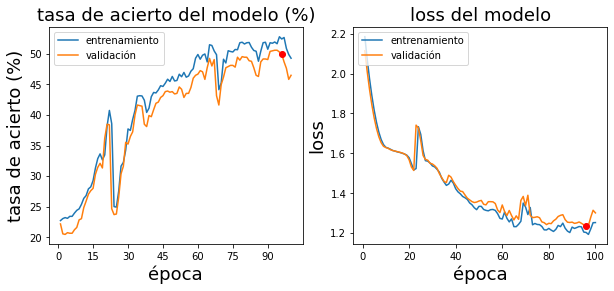

In [ ]:
for e in range(nepocas):
  h = model_1.fit(X_tr, y_tr,
                batch_size=batch_size,
                validation_data=(X_va, y_va),
                epochs=1, verbose=1)
  
  acum_tr_acc  = acum_tr_acc  + h.history['accuracy']
  acum_tr_loss = acum_tr_loss + h.history['loss']
  val_acc  = h.history['val_accuracy'][0]
  val_loss = h.history['val_loss'][0]
  acum_val_acc  = acum_val_acc  + [val_acc]
  acum_val_loss = acum_val_loss + [val_loss]
#  if val_acc  > best_val_acc:
  if val_loss < best_val_loss:
    best_i        = len(acum_val_acc)-1
    best_val_acc  = val_acc
    best_val_loss = val_loss
    best_weights = model_1.get_weights().copy()
  if len(acum_tr_acc)>1 and (len(acum_tr_acc)+1) % 1 == 0:
    if e>1:
      clear_output()
    grafica_entrenamiento(acum_tr_acc, acum_val_acc, acum_tr_loss, acum_val_loss, best_i)

Para la gráfica superior izquierda, buscamos maximizar las gráficas de entrenamiento y validación, y que estas estén lo menos separadas posible. Mientras tanto, para la gráfica superior derecha, buscamos que las gráficas decrezcan lo máximo posible, indicando una buena precisión del modelo generado. Dicho esto, vamos a evaluar cuál es el *accuracy* del modelo para el cual se han obtenido la mayor tasa de acierto y el menor *loss* en el subconjunto de validación, indicado en ambas gráficas con un punto naranja:

In [ ]:
model_1.set_weights(best_weights)

In [ ]:
scores = model_1.evaluate(X_test_pad, y_test, verbose=1)
print("Accuracy in test: %.2f%%" % (scores[1]*100))

1500/1500 [==============================] - 1s 404us/step
Accuracy in test: 52.07%


Dado este *accuracy*, trataremos de mejorarlo por medio de los posteriores experimentos de esta práctica.

### **1.4: Análisis del *embedding***

Antes de pasar al siguiente experimento, vamos a determinar cómo de eficiente es nuestro modelo, determinando aquellas palabras que sean más similares o, mejor dicho, estén más asociadas, según este modelo, a las distintas clases de los textos:

In [ ]:
def most_similar_words(embedding,word,n=10):
  n_latent_dimensions = np.shape(embedding)[1]
  ind = word2int[word]
  aux = np.reshape(embedding[ind,:], (1,n_latent_dimensions))
  dists = pairwise_distances(aux, embedding).flatten()
  inds = dists.argsort().tolist()
  inds.remove(ind)
  return [int2word[i] for i in inds[:n]]

embedding = model_1.get_weights()[0]
embedding.shape

(5000, 10)

In [ ]:
most_similar_words(embedding,'alzheimer')

['abeta',
 'disease',
 'dementia',
 'amyloid',
 "'s",
 'ache',
 'brain',
 'wiley',
 '2016',
 'compounds']

In [ ]:
most_similar_words(embedding,'bladder')

['urothelial',
 'urinary',
 'cognitive',
 'prostate',
 'diseases',
 "'s",
 'from',
 'other',
 'tuberculosis',
 'small']

In [ ]:
most_similar_words(embedding,'breast')

['hpv',
 'cancer',
 'cervix',
 'radiotherapy',
 'hela',
 'mcf',
 'cervical',
 'lesions',
 'patient',
 'tumors']

In [ ]:
most_similar_words(embedding,'cervical')

['hpv',
 'breast',
 'cancer',
 'cervix',
 'radiotherapy',
 'carcinoma',
 'hela',
 'lesions',
 'patient',
 'mcf']

In [ ]:
most_similar_words(embedding,'negative')

['epithelial',
 'sites',
 '7',
 'positive',
 'lines',
 'reconstruction',
 'suggested',
 '231',
 'lymph',
 'us']

En general, se aprecia que los resultados podrían ser mejores, por lo que vamos a tratar de mejorar esto por medio de otros experimentos, variando los valores de algunos hiperparámetros de los mencionados anteriormente a lo largo de este experimento.

## **2. Experimento 2**

A continuación, para este experimento y los sucesivos, vamos a indicar los valores utilizados para los hiperparámetros. En este caso, son los siguientes:

**VALORES QUE SE USARÁN PARA LOS HIPERPARÁMETROS**:


*   **top_words** = 2500
*   **max_review_length** = 250
*   **embedding_vector_length** = 10
*   **n_neurons** = 8
*   **l** = 0.0005
*   **Dropout**(rate = 0.3)



En este caso, hemos probado a disminuir *top_words* de 5000 a 2500. 

### **2.1: Determinación de las palabras más frecuentes**

Vamos a definir el tamaño de nuestro vocabulario para la construcción de redes neuronales artificiales. Para ello, se tomarán las n palabras más frecuentes, en función del valor de la variable *top_words* que vemos en la celda inferior.

In [ ]:
top_words = 2500 # HYPERPARAMETER, VOCABULARY SIZE

tk = Tokenizer(oov_token='(oov)', num_words=(top_words-1))
tk.fit_on_texts(data_train["text"])

A continuación, vamos a crear un *array* para cada uno de los *abstracts* de tanto el *training set* como el *test set*, de forma que a cada palabra se le asigne un identificador numérico, el cual no se asigna por orden de aparición en el texto. Cabe destacar que todos estos *arrays* comienzan por el 1, que no se corresponde con ninguna de las palabras del texto, sino que simplemente indica el inicio. Además, el número 2 tampoco se corresponde con ninguna palabra, sino que se refiere a palabras *oov* (del inglés, *out of vocabulary*), que son palabras poco frecuentes y que no han entrado en nuestro vocabulario de palabras frecuentes (variable *top_words*). 

In [ ]:
X_train  = [np.array([0] + x)+1 for x in tk.texts_to_sequences(data_train["text"])]
X_test   = [np.array([0] + x)+1 for x in tk.texts_to_sequences(data_test["text"])]

In [ ]:
X_train[0]

array([   1,    2,    2,   27,  490,   23,  869,    8,  197,    4, 2364,
          2,    2,    2,    2,    9,   30,    2, 2279,    2,    5,  836,
        809,  555,   53,    9,    3,  762,    8,  787,  166,  386, 1310,
          9,    8,  508,    4,    2, 1396,  230,   39,   13,  159,    9,
          2,  543, 2016,    9,  700,    2,    2,  424,    5,  621,    2,
          2, 2401, 1325,   11,  101,    7,   43,   30,    2,    2,    5,
        251, 1616,    2,    2,    9,    8, 2402, 2279,    9, 1953,    4,
       1415,  354, 1325,    2,   20,  166, 1299,    9, 2279,    2,    2,
          2,   18,  214,    2,    2,  424,    2,    8,    2,    2,    2,
       1325,  540,    2,   65,  155, 1299,    9,  187,  189,    4,    2,
        391,    4,    3, 2279,    2,  162,    3,   44,  444,    4,    8,
        480,  397,    4, 1047, 1247,   13, 2403,   11,   51,    2,    5,
       1325,  251,  701,  269, 2049,    2,   27,    8,  490, 1326,   87,
         62,   28,  159, 1483,    9,    2, 2279,   

En la siguiente celda, podemos comprobar efectivamente que existen 2500 identificadores numéricos, pues habíamos indicado anteriormente que *top_words=2500*.

In [ ]:
min([x.min() for x in X_train]), max([x.max() for x in X_train]), min([x.min() for x in X_test]), max([x.max() for x in X_test])

(1, 2499, 1, 2499)

A continuación, vamos a determinar cuáles son las 20 palabras más frecuentes en nuestro vocabulario de longitud 2500. Nótese, de nuevo, como los identificadores 0, 1 y 2 están reservados para *padding*, *start* y *oov*, respectivamente.

In [ ]:
int2word = {(i+1):tk.index_word[i] for i in range(1,top_words-1)} # el 0 no está incluido, se reserva para padding
int2word[0] = "(padding)"
int2word[1] = "(start)"

word2int = {int2word[i]:i for i in range(top_words)}

In [ ]:
int2word[0], int2word[1], int2word[2], int2word[max([x.max() for x in X_train])], word2int["the"] #, word2int["whoopi"]

('(padding)', '(start)', '(oov)', 'experiment', 3)

20 palabras más frecuentes:

In [ ]:
for i in range(20):
    print(i, int2word[i])

0 (padding)
1 (start)
2 (oov)
3 the
4 of
5 and
6 in
7 to
8 a
9 with
10 for
11 was
12 were
13 cancer
14 is
15 patients
16 that
17 0
18 as
19 by


Además, en la siguiente celda, podemos tomar un texto en concreto, ver el *array* de identificadores numéricos y qué identificador le corresponde a cada palabra del texto original:

In [ ]:
ejemplo = 1

print(X_train[ejemplo], "\n") #Array con los índices asociados a cada palabra del texto.
print("\033[1m"+"Índices y sus palabras asociadas:")
for i,x in enumerate(X_train[ejemplo][:50]):
  print("{} -> {}".format(x, int2word[x])) #Se muestra el índice junto con su palabra asociada.
if (i+1)<len(X_train[ejemplo]): 
  print("...")
print("Class: {}".format(y_train[ejemplo])) 

[   1    3   90   44   13  487    2   14  457    2 1450  723   10    3
  358  311    5 1554  114    3  157  275    4   78   45    2   14    7
    2    2   38    5  782    4  487   15  328  936  363   89  230   18
  124   18  132  230  264    2    3 1641    4    3 1901    4 1379   14
    3    2  165    3    2    6    3    2  763   14    3    2    4    2
    4    2   10  358    5  520  148  114    3  139  151  847  349   28
 1248   21    3    2  328  264   10    3  358  114    4  487  440    2
    4   47 2280 2129    2   47   53    2    2    2   44   47 1249    2
   10    3  176  487  114] 

Índices y sus palabras asociadas:
1 -> (start)
3 -> the
90 -> human
44 -> bladder
13 -> cancer
487 -> bc
2 -> (oov)
14 -> is
457 -> being
2 -> (oov)
1450 -> every
723 -> day
10 -> for
3 -> the
358 -> better
311 -> management
5 -> and
1554 -> efficient
114 -> diagnosis
3 -> the
157 -> primary
275 -> aim
4 -> of
78 -> all
45 -> these
2 -> (oov)
14 -> is
7 -> to
2 -> (oov)
2 -> (oov)
38 -> treatment
5 -

### **2.2: *Padding* de las palabras**

A continuación, tras haber asignado un identificador a cada palabra de cada texto y haber determinado las palabras más frecuentes en general, otro procedimiento de pre-procesado fundamental para el diseño de redes neuronales artificiales es el ***padding***, que consiste en normalizar el tamaño de los textos, es decir, que todos tengan la misma longitud. 

Esto lo haremos posible por medio de otro hiperparámetro llamado *max_review_length*, que determina a qué tamaño normalizamos todos los textos. Si un determinado texto tiene más tamaño que el indicado, se recortará para que tenga el tamaño exigido; mientras que si un texto es más pequeño a dicho tamaño, se alargará mediante identificadores numéricos de *padding*, que son el número 0, hasta llegar al número de palabras indicado en dicha variable.

In [ ]:
max_review_length = 250 # HYPERPARAMETER
X_train_pad = sequence.pad_sequences(X_train, maxlen=max_review_length)
X_test_pad = sequence.pad_sequences(X_test, maxlen=max_review_length)
int2word[0] = "(padding)"

print("Tamaño del dataset de training después del padding:", X_train_pad.shape)
print("Los códigos de palabras van de {} a {}".format(X_train_pad.min(), X_train_pad.max()))

Tamaño del dataset de training después del padding: (3500, 250)
Los códigos de palabras van de 0 a 2499


In [ ]:
data_train["text"][1369]

'ureteroarterial fistulas are rare we describe a case of ureteral-arterial fistulas uaf repaired with an endovascular stent graft and examine late complications associated with the procedure a 37-year-old woman with a history of complicated locally invasive cervical cancer treated with chemoradiation presented initially with right leg rest pain and chronic intermittent gross hematuria she was found to have an ureteroarterial fistula and underwent successful endovascular exclusion with a covered stent with resolution of her symptoms she returned 1 year later with stent-graft thrombosis manifesting as lower extremity rest pain requiring a femoral-femoral bypass she then returned 6 months later with imaging evidence of extravascular migration of the stent graft into the bladder because of a poor prognosis of recurrent gynecologic cancer extraction was not attempted and she underwent complete urinary diversion uafs are a rare occurrence but may be treated successfully with endovascular ste

Como vemos, para el primer texto de la partición *train* de los *abstracts*, este texto tenía menor longitud a la indicada en *max_review_length*, por lo que se le han añadido ceros al *array* de identificadores numéricos de dicho texto.

In [ ]:
X_train_pad[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    1,    2,    2,   27,  490,
         23,  869,    8,  197,    4, 2364,    2,    2,    2,    2,    9,
         30,    2, 2279,    2,    5,  836,  809,  555,   53,    9,    3,
        762,    8,  787,  166,  386, 1310,    9,    8,  508,    4,    2,
       1396,  230,   39,   13,  159,    9,    2,  543, 2016,    9,  700,
          2,    2,  424,    5,  621,    2,    2, 2401, 1325,   11,  101,
          7,   43,   30,    2,    2,    5,  251, 1616,    2,    2,    9,
          8, 2402, 2279,    9, 1953,    4, 1415,  3

### **2.3: Construcción de la red neuronal (LSTM)**

In [ ]:
# HYPERPARAMETERS: ***
embedding_vector_length = 10 # HYPERPARAMETER
N_NEURONS = 8
# ********************


N_CLASSES = 5

rnn = LSTM
model_2 = Sequential()
model_2.add(Embedding(top_words, # número de palabras del vocabulario incluido 0 de padding
                    embedding_vector_length, # número de dimensiones que quieres que tenga el embedding
                    # l: "fuerza" del regularizador. Cuanto máás alto, más regulariza (pone a 0 componentes)
                    embeddings_regularizer=regularizers.l1(l=0.0005), # regularización (intenta poner a cero componentes)
                    input_length=max_review_length)) # tamaño de la secuencia de palabras
model_2.add(Dropout(rate=0.3))
model_2.add(rnn(N_NEURONS)) # MANY TO ONE (return_sequences no es True)
model_2.add(Dense(N_CLASSES, activation='softmax'))
model_2.compile(loss='sparse_categorical_crossentropy', # binarycrossentropy porque hay 2 clases, si hay más, categorical_crossentropy
              optimizer=Adam(lr=0.001), # lr: velocidad de aprendizaje
              metrics=['accuracy'])

A continuación, tras generar nuestra red neuronal, vamos a examinar sus características por medio del siguiente diagrama:

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 250, 10)           25000     
_________________________________________________________________
dropout_10 (Dropout)         (None, 250, 10)           0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 8)                 608       
_________________________________________________________________
dense_10 (Dense)             (None, 5)                 45        
Total params: 25,653
Trainable params: 25,653
Non-trainable params: 0
_________________________________________________________________


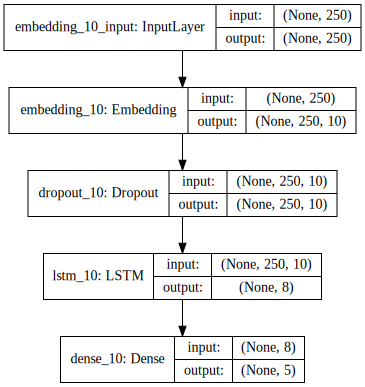

In [ ]:
model_2.summary()
if COLAB:
    display(SVG(model_to_dot(model_2,show_shapes=True,dpi=72).create(prog='dot', format='svg')))
else:
    display(SVG(model_to_dot(model_2,show_shapes=True).create(prog='dot', format='svg')))

Como podemos apreciar, partimos de una *input layer*, correspondiente a nuestros textos con sus índices numéricos, todos con una longitud igual a la indicada en *max_review_length*. De ahí, se pasa a la *embedding layer*, que transforma los índices numéricos en vectores de longitud *embedding_vector_length*. De ahí, se pasa a la *Dropout layer*, que introduce ruido en los vectores. Tras esto, se pasa a la capa *LSTM*, donde encontramos el número de neuronas que hubiésemos indicado en la variable *N_NEURONS*, y esto se aplica finalmente a las 5 clases que encontramos para nuestros textos en este caso. Todo esto puede apreciarse tanto en la tabla superior como en el diagrama inferior.

#### **Reservamos, dentro del conjunto de *training*, un subconjunto de validación**

In [ ]:
# Entreno sobre X_tr,y_tr monitorizo el aprendizaje sobre X_va,y_va
X_tr, X_va, y_tr, y_va = train_test_split(X_train_pad, y_train, test_size=0.3, random_state=1)
print(X_tr.shape, len(y_tr))
print(X_va.shape, len(y_va))

(2450, 250) 2450
(1050, 250) 1050


A continuación, una vez hemos generado nuestra red neuronal, vamos a entrenarla con una de las subparticiones de la partición *training* de los *abstracts*, para luego validarla con otra subpartición de la misma. Para ello, vamos a utilizar 100 como el valor de *nepocas*:

#### **Entrenamiento del modelo**

In [ ]:
batch_size = 512
nepocas = 100

best_val_acc  = 0
best_val_loss = 1e20
best_i        = 0

best_weights = []
acum_tr_acc = []
acum_tr_loss = []
acum_val_acc = []
acum_val_loss = []

A continuación, vamos a representar dos gráficas relativas al modelo que hemos diseñado: **tasa de acierto del modelo (%)** y **loss del modelo**, donde ***loss*** significa lo siguiente:

* ***loss* (clasificación)**:

$$
promedio( -ln \, P_{modelo}(clase\,real))
$$

* Si clase real = 0 y nuestro modelo predice que
P(clase 0) = 1:

$-ln \, P_{modelo}(clase\,real) = 0$

* Si clase real = 0 y nuestro modelo predice que
P(clase 0) = 0.9:

$-ln \, P_{modelo}(clase\,real) > 0$

* Si clase real = 0 y nuestro modelo predice que
P(clase 0) = 0:

$-ln \, P_{modelo}(clase\,real) = +\inf$



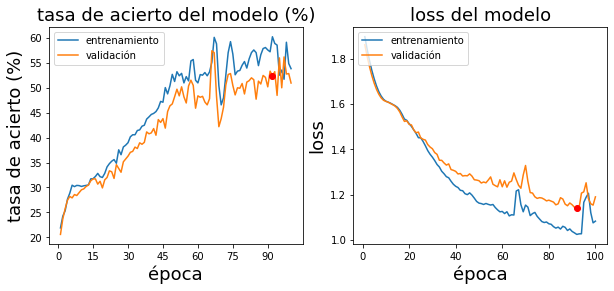

In [ ]:
for e in range(nepocas):
  h = model_2.fit(X_tr, y_tr,
                batch_size=batch_size,
                validation_data=(X_va, y_va),
                epochs=1, verbose=1)
  
  acum_tr_acc  = acum_tr_acc  + h.history['accuracy']
  acum_tr_loss = acum_tr_loss + h.history['loss']
  val_acc  = h.history['val_accuracy'][0]
  val_loss = h.history['val_loss'][0]
  acum_val_acc  = acum_val_acc  + [val_acc]
  acum_val_loss = acum_val_loss + [val_loss]
#  if val_acc  > best_val_acc:
  if val_loss < best_val_loss:
    best_i        = len(acum_val_acc)-1
    best_val_acc  = val_acc
    best_val_loss = val_loss
    best_weights = model_2.get_weights().copy()
  if len(acum_tr_acc)>1 and (len(acum_tr_acc)+1) % 1 == 0:
    if e>1:
      clear_output()
    grafica_entrenamiento(acum_tr_acc, acum_val_acc, acum_tr_loss, acum_val_loss, best_i)

In [ ]:
model_2.set_weights(best_weights)

In [ ]:
scores = model_2.evaluate(X_test_pad, y_test, verbose=1)
print("Accuracy in test: %.2f%%" % (scores[1]*100))

1500/1500 [==============================] - 1s 390us/step
Accuracy in test: 54.47%


### **2.4: Análisis del *embedding***

Antes de pasar al siguiente experimento, vamos a determinar cómo de eficiente es nuestro modelo, determinando aquellas palabras que sean más similares o, mejor dicho, estén más asociadas, según este modelo, a las distintas clases de los textos:

In [ ]:
def most_similar_words(embedding,word,n=10):
  n_latent_dimensions = np.shape(embedding)[1]
  ind = word2int[word]
  aux = np.reshape(embedding[ind,:], (1,n_latent_dimensions))
  dists = pairwise_distances(aux, embedding).flatten()
  inds = dists.argsort().tolist()
  inds.remove(ind)
  return [int2word[i] for i in inds[:n]]

embedding = model_2.get_weights()[0]
embedding.shape

(2500, 10)

In [ ]:
most_similar_words(embedding,'alzheimer')

['dementia',
 'abeta',
 "'s",
 'diseases',
 'cognitive',
 'brain',
 'future',
 'amyloid',
 'disease',
 'tau']

In [ ]:
most_similar_words(embedding,'bladder')

['urothelial',
 'hela',
 'hpv',
 'cervical',
 'cervix',
 'uca1',
 'pap',
 'tumors',
 'carcinoma',
 'adenocarcinoma']

In [ ]:
most_similar_words(embedding,'breast')

['cancer',
 'metastasis',
 'therapy',
 '(oov)',
 'needed',
 'axillary',
 'receptor',
 'reported',
 'luminal',
 'also']

In [ ]:
most_similar_words(embedding,'cervical')

['bladder',
 'hela',
 'urothelial',
 'hpv',
 'cervix',
 'pap',
 'uca1',
 'pelvic',
 'tumors',
 'carcinoma']

In [ ]:
most_similar_words(embedding,'negative')

['tumours',
 '73',
 'warranted',
 'behavior',
 'system',
 'fixed',
 'toxicity',
 'numbers',
 'treated',
 'offer']

## **3. Experimento 3**

A continuación, para este experimento y los sucesivos, vamos a indicar los valores utilizados para los hiperparámetros. En este caso, son los siguientes:

**VALORES QUE SE USARÁN PARA LOS HIPERPARÁMETROS**:


*   **top_words** = 2500
*   **max_review_length** = 150
*   **embedding_vector_length** = 10
*   **n_neurons** = 8
*   **l** = 0.0005
*   **Dropout**(rate = 0.3)



En este caso, hemos probado a disminuir *max_review_length* de 250 a 150. 

### **3.1: Determinación de las palabras más frecuentes**

In [ ]:
top_words = 2500 # HYPERPARAMETER, VOCABULARY SIZE

tk = Tokenizer(oov_token='(oov)', num_words=(top_words-1))
tk.fit_on_texts(data_train["text"])

In [ ]:
X_train  = [np.array([0] + x)+1 for x in tk.texts_to_sequences(data_train["text"])]
X_test   = [np.array([0] + x)+1 for x in tk.texts_to_sequences(data_test["text"])]

In [ ]:
X_train[0]

array([   1,    2,    2,   27,  490,   23,  869,    8,  197,    4, 2364,
          2,    2,    2,    2,    9,   30,    2, 2279,    2,    5,  836,
        809,  555,   53,    9,    3,  762,    8,  787,  166,  386, 1310,
          9,    8,  508,    4,    2, 1396,  230,   39,   13,  159,    9,
          2,  543, 2016,    9,  700,    2,    2,  424,    5,  621,    2,
          2, 2401, 1325,   11,  101,    7,   43,   30,    2,    2,    5,
        251, 1616,    2,    2,    9,    8, 2402, 2279,    9, 1953,    4,
       1415,  354, 1325,    2,   20,  166, 1299,    9, 2279,    2,    2,
          2,   18,  214,    2,    2,  424,    2,    8,    2,    2,    2,
       1325,  540,    2,   65,  155, 1299,    9,  187,  189,    4,    2,
        391,    4,    3, 2279,    2,  162,    3,   44,  444,    4,    8,
        480,  397,    4, 1047, 1247,   13, 2403,   11,   51,    2,    5,
       1325,  251,  701,  269, 2049,    2,   27,    8,  490, 1326,   87,
         62,   28,  159, 1483,    9,    2, 2279,   

In [ ]:
min([x.min() for x in X_train]), max([x.max() for x in X_train]), min([x.min() for x in X_test]), max([x.max() for x in X_test])

(1, 2499, 1, 2499)

In [ ]:
int2word = {(i+1):tk.index_word[i] for i in range(1,top_words-1)} # el 0 no está incluido, se reserva para padding
int2word[0] = "(padding)"
int2word[1] = "(start)"

word2int = {int2word[i]:i for i in range(top_words)}

In [ ]:
int2word[0], int2word[1], int2word[2], int2word[max([x.max() for x in X_train])], word2int["the"] #, word2int["whoopi"]

('(padding)', '(start)', '(oov)', 'experiment', 3)

20 palabras más frecuentes:

In [ ]:
for i in range(20):
    print(i, int2word[i])

0 (padding)
1 (start)
2 (oov)
3 the
4 of
5 and
6 in
7 to
8 a
9 with
10 for
11 was
12 were
13 cancer
14 is
15 patients
16 that
17 0
18 as
19 by


In [ ]:
ejemplo = 1

print(X_train[ejemplo], "\n") #Array con los índices asociados a cada palabra del texto.
print("\033[1m"+"Índices y sus palabras asociadas:")
for i,x in enumerate(X_train[ejemplo][:50]):
  print("{} -> {}".format(x, int2word[x])) #Se muestra el índice junto con su palabra asociada.
if (i+1)<len(X_train[ejemplo]): 
  print("...")
print("Class: {}".format(y_train[ejemplo])) 

[   1    3   90   44   13  487    2   14  457    2 1450  723   10    3
  358  311    5 1554  114    3  157  275    4   78   45    2   14    7
    2    2   38    5  782    4  487   15  328  936  363   89  230   18
  124   18  132  230  264    2    3 1641    4    3 1901    4 1379   14
    3    2  165    3    2    6    3    2  763   14    3    2    4    2
    4    2   10  358    5  520  148  114    3  139  151  847  349   28
 1248   21    3    2  328  264   10    3  358  114    4  487  440    2
    4   47 2280 2129    2   47   53    2    2    2   44   47 1249    2
   10    3  176  487  114] 

Índices y sus palabras asociadas:
1 -> (start)
3 -> the
90 -> human
44 -> bladder
13 -> cancer
487 -> bc
2 -> (oov)
14 -> is
457 -> being
2 -> (oov)
1450 -> every
723 -> day
10 -> for
3 -> the
358 -> better
311 -> management
5 -> and
1554 -> efficient
114 -> diagnosis
3 -> the
157 -> primary
275 -> aim
4 -> of
78 -> all
45 -> these
2 -> (oov)
14 -> is
7 -> to
2 -> (oov)
2 -> (oov)
38 -> treatment
5 -

### **3.2: *Padding* de las palabras**

In [ ]:
max_review_length = 150 # HYPERPARAMETER
X_train_pad = sequence.pad_sequences(X_train, maxlen=max_review_length)
X_test_pad = sequence.pad_sequences(X_test, maxlen=max_review_length)
int2word[0] = "(padding)"

print("Tamaño del dataset de training después del padding:", X_train_pad.shape)
print("Los códigos de palabras van de {} a {}".format(X_train_pad.min(), X_train_pad.max()))

Tamaño del dataset de training después del padding: (3500, 150)
Los códigos de palabras van de 0 a 2499


In [ ]:
data_train["text"][1369]

'ureteroarterial fistulas are rare we describe a case of ureteral-arterial fistulas uaf repaired with an endovascular stent graft and examine late complications associated with the procedure a 37-year-old woman with a history of complicated locally invasive cervical cancer treated with chemoradiation presented initially with right leg rest pain and chronic intermittent gross hematuria she was found to have an ureteroarterial fistula and underwent successful endovascular exclusion with a covered stent with resolution of her symptoms she returned 1 year later with stent-graft thrombosis manifesting as lower extremity rest pain requiring a femoral-femoral bypass she then returned 6 months later with imaging evidence of extravascular migration of the stent graft into the bladder because of a poor prognosis of recurrent gynecologic cancer extraction was not attempted and she underwent complete urinary diversion uafs are a rare occurrence but may be treated successfully with endovascular ste

In [ ]:
X_train_pad[0]

array([   8,  787,  166,  386, 1310,    9,    8,  508,    4,    2, 1396,
        230,   39,   13,  159,    9,    2,  543, 2016,    9,  700,    2,
          2,  424,    5,  621,    2,    2, 2401, 1325,   11,  101,    7,
         43,   30,    2,    2,    5,  251, 1616,    2,    2,    9,    8,
       2402, 2279,    9, 1953,    4, 1415,  354, 1325,    2,   20,  166,
       1299,    9, 2279,    2,    2,    2,   18,  214,    2,    2,  424,
          2,    8,    2,    2,    2, 1325,  540,    2,   65,  155, 1299,
          9,  187,  189,    4,    2,  391,    4,    3, 2279,    2,  162,
          3,   44,  444,    4,    8,  480,  397,    4, 1047, 1247,   13,
       2403,   11,   51,    2,    5, 1325,  251,  701,  269, 2049,    2,
         27,    8,  490, 1326,   87,   62,   28,  159, 1483,    9,    2,
       2279,    2,  781,    2, 2190,  809,  555,  126,   18, 2279,    2,
         62, 1617,  819,    9,    2,    2, 2279,  391,   62, 1617,    6,
          3,  331,    4,    8,    2,    2,    2], d

### **3.3: Construcción de la red neuronal (LSTM)**

In [ ]:
# HYPERPARAMETERS: ***
embedding_vector_length = 10 # HYPERPARAMETER
N_NEURONS = 8
# ********************


N_CLASSES = 5

rnn = LSTM
model_3 = Sequential()
model_3.add(Embedding(top_words, # número de palabras del vocabulario incluido 0 de padding
                    embedding_vector_length, # número de dimensiones que quieres que tenga el embedding
                    # l: "fuerza" del regularizador. Cuanto máás alto, más regulariza (pone a 0 componentes)
                    embeddings_regularizer=regularizers.l1(l=0.0005), # regularización (intenta poner a cero componentes)
                    input_length=max_review_length)) # tamaño de la secuencia de palabras
model_3.add(Dropout(rate=0.3))
model_3.add(rnn(N_NEURONS)) # MANY TO ONE (return_sequences no es True)
model_3.add(Dense(N_CLASSES, activation='softmax'))
model_3.compile(loss='sparse_categorical_crossentropy', # binarycrossentropy porque hay 2 clases, si hay más, categorical_crossentropy
              optimizer=Adam(lr=0.001), # lr: velocidad de aprendizaje
              metrics=['accuracy'])

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 150, 10)           25000     
_________________________________________________________________
dropout_12 (Dropout)         (None, 150, 10)           0         
_________________________________________________________________
lstm_12 (LSTM)               (None, 8)                 608       
_________________________________________________________________
dense_12 (Dense)             (None, 5)                 45        
Total params: 25,653
Trainable params: 25,653
Non-trainable params: 0
_________________________________________________________________


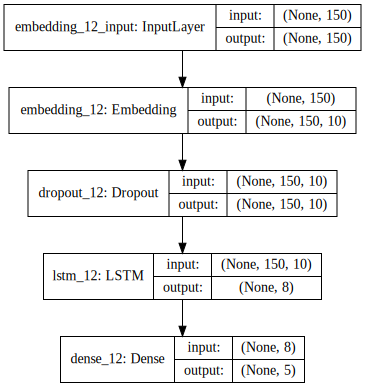

In [ ]:
model_3.summary()
if COLAB:
    display(SVG(model_to_dot(model_3,show_shapes=True,dpi=72).create(prog='dot', format='svg')))
else:
    display(SVG(model_to_dot(model_3,show_shapes=True).create(prog='dot', format='svg')))

#### **Reservamos, dentro del conjunto de *training*, un subconjunto de validación**

In [ ]:
# Entreno sobre X_tr,y_tr monitorizo el aprendizaje sobre X_va,y_va
X_tr, X_va, y_tr, y_va = train_test_split(X_train_pad, y_train, test_size=0.3, random_state=1)
print(X_tr.shape, len(y_tr))
print(X_va.shape, len(y_va))

(2450, 150) 2450
(1050, 150) 1050


#### **Entrenamiento del modelo**

In [ ]:
batch_size = 512
nepocas = 100

best_val_acc  = 0
best_val_loss = 1e20
best_i        = 0

best_weights = []
acum_tr_acc = []
acum_tr_loss = []
acum_val_acc = []
acum_val_loss = []

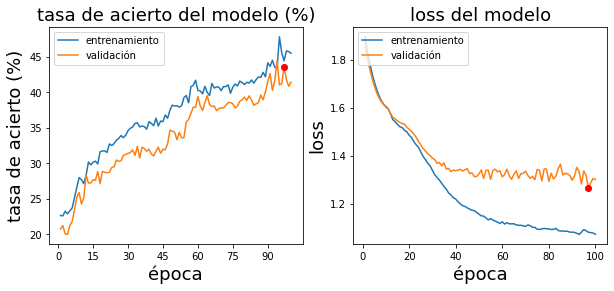

In [ ]:
for e in range(nepocas):
  h = model_3.fit(X_tr, y_tr,
                batch_size=batch_size,
                validation_data=(X_va, y_va),
                epochs=1, verbose=1)
  
  acum_tr_acc  = acum_tr_acc  + h.history['accuracy']
  acum_tr_loss = acum_tr_loss + h.history['loss']
  val_acc  = h.history['val_accuracy'][0]
  val_loss = h.history['val_loss'][0]
  acum_val_acc  = acum_val_acc  + [val_acc]
  acum_val_loss = acum_val_loss + [val_loss]
#  if val_acc  > best_val_acc:
  if val_loss < best_val_loss:
    best_i        = len(acum_val_acc)-1
    best_val_acc  = val_acc
    best_val_loss = val_loss
    best_weights = model_3.get_weights().copy()
  if len(acum_tr_acc)>1 and (len(acum_tr_acc)+1) % 1 == 0:
    if e>1:
      clear_output()
    grafica_entrenamiento(acum_tr_acc, acum_val_acc, acum_tr_loss, acum_val_loss, best_i)

In [ ]:
model_3.set_weights(best_weights)

In [ ]:
scores = model_3.evaluate(X_test_pad, y_test, verbose=1)
print("Accuracy in test: %.2f%%" % (scores[1]*100))

1500/1500 [==============================] - 0s 235us/step
Accuracy in test: 42.67%


### **3.4: Análisis del *embedding***

Antes de pasar al siguiente experimento, vamos a determinar cómo de eficiente es nuestro modelo, determinando aquellas palabras que sean más similares o, mejor dicho, estén más asociadas, según este modelo, a las distintas clases de los textos:

In [ ]:
def most_similar_words(embedding,word,n=10):
  n_latent_dimensions = np.shape(embedding)[1]
  ind = word2int[word]
  aux = np.reshape(embedding[ind,:], (1,n_latent_dimensions))
  dists = pairwise_distances(aux, embedding).flatten()
  inds = dists.argsort().tolist()
  inds.remove(ind)
  return [int2word[i] for i in inds[:n]]

embedding = model_3.get_weights()[0]
embedding.shape

(2500, 10)

In [ ]:
most_similar_words(embedding,'alzheimer')

['dementia',
 'abeta',
 'inhibition',
 'brain',
 'databases',
 'diseases',
 'concentrations',
 'body',
 'syndrome',
 'pancreatic']

In [ ]:
most_similar_words(embedding,'bladder')

['breast',
 'cancer',
 'radiotherapy',
 'carcinoma',
 'urothelial',
 'hpv',
 'mcf',
 'chemotherapy',
 'cancers',
 'variations']

In [ ]:
most_similar_words(embedding,'breast')

['bladder',
 'cancer',
 'carcinoma',
 'hpv',
 'radiotherapy',
 'urothelial',
 'mcf',
 'chemotherapy',
 'cancers',
 'variations']

In [ ]:
most_similar_words(embedding,'cervical')

['hpv',
 'carcinoma',
 'cancer',
 'therapy',
 'cancers',
 'cervix',
 'screening',
 'mcf',
 'biopsy',
 'chemotherapy']

In [ ]:
most_similar_words(embedding,'negative')

['gsh',
 'behavioral',
 'force',
 'cin',
 'except',
 'type',
 'crucial',
 'revealed',
 'nps',
 'vitro']

## **4. Experimento 4**

A continuación, para este experimento y los sucesivos, vamos a indicar los valores utilizados para los hiperparámetros. En este caso, son los siguientes:

**VALORES QUE SE USARÁN PARA LOS HIPERPARÁMETROS**:


*   **top_words** = 2500
*   **max_review_length** = 350
*   **embedding_vector_length** = 10
*   **n_neurons** = 8
*   **l** = 0.0005
*   **Dropout**(rate = 0.3)



En este caso, hemos probado a subir *max_review_length* de 150 a 350. 

### **4.1: Determinación de las palabras más frecuentes**

In [ ]:
top_words = 2500 # HYPERPARAMETER, VOCABULARY SIZE

tk = Tokenizer(oov_token='(oov)', num_words=(top_words-1))
tk.fit_on_texts(data_train["text"])

In [ ]:
X_train  = [np.array([0] + x)+1 for x in tk.texts_to_sequences(data_train["text"])]
X_test   = [np.array([0] + x)+1 for x in tk.texts_to_sequences(data_test["text"])]

In [ ]:
X_train[0]

array([   1,    2,    2,   27,  490,   23,  869,    8,  197,    4, 2364,
          2,    2,    2,    2,    9,   30,    2, 2279,    2,    5,  836,
        809,  555,   53,    9,    3,  762,    8,  787,  166,  386, 1310,
          9,    8,  508,    4,    2, 1396,  230,   39,   13,  159,    9,
          2,  543, 2016,    9,  700,    2,    2,  424,    5,  621,    2,
          2, 2401, 1325,   11,  101,    7,   43,   30,    2,    2,    5,
        251, 1616,    2,    2,    9,    8, 2402, 2279,    9, 1953,    4,
       1415,  354, 1325,    2,   20,  166, 1299,    9, 2279,    2,    2,
          2,   18,  214,    2,    2,  424,    2,    8,    2,    2,    2,
       1325,  540,    2,   65,  155, 1299,    9,  187,  189,    4,    2,
        391,    4,    3, 2279,    2,  162,    3,   44,  444,    4,    8,
        480,  397,    4, 1047, 1247,   13, 2403,   11,   51,    2,    5,
       1325,  251,  701,  269, 2049,    2,   27,    8,  490, 1326,   87,
         62,   28,  159, 1483,    9,    2, 2279,   

In [ ]:
min([x.min() for x in X_train]), max([x.max() for x in X_train]), min([x.min() for x in X_test]), max([x.max() for x in X_test])

(1, 2499, 1, 2499)

In [ ]:
int2word = {(i+1):tk.index_word[i] for i in range(1,top_words-1)} # el 0 no está incluido, se reserva para padding
int2word[0] = "(padding)"
int2word[1] = "(start)"

word2int = {int2word[i]:i for i in range(top_words)}

In [ ]:
int2word[0], int2word[1], int2word[2], int2word[max([x.max() for x in X_train])], word2int["the"] #, word2int["whoopi"]

('(padding)', '(start)', '(oov)', 'experiment', 3)

In [ ]:
for i in range(20):
    print(i, int2word[i])

0 (padding)
1 (start)
2 (oov)
3 the
4 of
5 and
6 in
7 to
8 a
9 with
10 for
11 was
12 were
13 cancer
14 is
15 patients
16 that
17 0
18 as
19 by


In [ ]:
ejemplo = 1

print(X_train[ejemplo], "\n") #Array con los índices asociados a cada palabra del texto.
print("\033[1m"+"Índices y sus palabras asociadas:")
for i,x in enumerate(X_train[ejemplo][:50]):
  print("{} -> {}".format(x, int2word[x])) #Se muestra el índice junto con su palabra asociada.
if (i+1)<len(X_train[ejemplo]): 
  print("...")
print("Class: {}".format(y_train[ejemplo])) 

[   1    3   90   44   13  487    2   14  457    2 1450  723   10    3
  358  311    5 1554  114    3  157  275    4   78   45    2   14    7
    2    2   38    5  782    4  487   15  328  936  363   89  230   18
  124   18  132  230  264    2    3 1641    4    3 1901    4 1379   14
    3    2  165    3    2    6    3    2  763   14    3    2    4    2
    4    2   10  358    5  520  148  114    3  139  151  847  349   28
 1248   21    3    2  328  264   10    3  358  114    4  487  440    2
    4   47 2280 2129    2   47   53    2    2    2   44   47 1249    2
   10    3  176  487  114] 

Índices y sus palabras asociadas:
1 -> (start)
3 -> the
90 -> human
44 -> bladder
13 -> cancer
487 -> bc
2 -> (oov)
14 -> is
457 -> being
2 -> (oov)
1450 -> every
723 -> day
10 -> for
3 -> the
358 -> better
311 -> management
5 -> and
1554 -> efficient
114 -> diagnosis
3 -> the
157 -> primary
275 -> aim
4 -> of
78 -> all
45 -> these
2 -> (oov)
14 -> is
7 -> to
2 -> (oov)
2 -> (oov)
38 -> treatment
5 -

### **4.2: *Padding* de las palabras**

In [ ]:
max_review_length = 350 # HYPERPARAMETER
X_train_pad = sequence.pad_sequences(X_train, maxlen=max_review_length)
X_test_pad = sequence.pad_sequences(X_test, maxlen=max_review_length)
int2word[0] = "(padding)"

print("Tamaño del dataset de training después del padding:", X_train_pad.shape)
print("Los códigos de palabras van de {} a {}".format(X_train_pad.min(), X_train_pad.max()))

Tamaño del dataset de training después del padding: (3500, 350)
Los códigos de palabras van de 0 a 2499


In [ ]:
data_train["text"][1369]

'ureteroarterial fistulas are rare we describe a case of ureteral-arterial fistulas uaf repaired with an endovascular stent graft and examine late complications associated with the procedure a 37-year-old woman with a history of complicated locally invasive cervical cancer treated with chemoradiation presented initially with right leg rest pain and chronic intermittent gross hematuria she was found to have an ureteroarterial fistula and underwent successful endovascular exclusion with a covered stent with resolution of her symptoms she returned 1 year later with stent-graft thrombosis manifesting as lower extremity rest pain requiring a femoral-femoral bypass she then returned 6 months later with imaging evidence of extravascular migration of the stent graft into the bladder because of a poor prognosis of recurrent gynecologic cancer extraction was not attempted and she underwent complete urinary diversion uafs are a rare occurrence but may be treated successfully with endovascular ste

In [ ]:
X_train_pad[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

### **4.3: Construcción de la red neuronal (LSTM)**

In [ ]:
# HYPERPARAMETERS: ***
embedding_vector_length = 10 # HYPERPARAMETER
N_NEURONS = 8
# ********************


N_CLASSES = 5

rnn = LSTM
model_4 = Sequential()
model_4.add(Embedding(top_words, # número de palabras del vocabulario incluido 0 de padding
                    embedding_vector_length, # número de dimensiones que quieres que tenga el embedding
                    # l: "fuerza" del regularizador. Cuanto máás alto, más regulariza (pone a 0 componentes)
                    embeddings_regularizer=regularizers.l1(l=0.0005), # regularización (intenta poner a cero componentes)
                    input_length=max_review_length)) # tamaño de la secuencia de palabras
model_4.add(Dropout(rate=0.3))
model_4.add(rnn(N_NEURONS)) # MANY TO ONE (return_sequences no es True)
model_4.add(Dense(N_CLASSES, activation='softmax'))
model_4.compile(loss='sparse_categorical_crossentropy', # binarycrossentropy porque hay 2 clases, si hay más, categorical_crossentropy
              optimizer=Adam(lr=0.001), # lr: velocidad de aprendizaje
              metrics=['accuracy'])

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_15 (Embedding)     (None, 350, 10)           25000     
_________________________________________________________________
dropout_15 (Dropout)         (None, 350, 10)           0         
_________________________________________________________________
lstm_15 (LSTM)               (None, 8)                 608       
_________________________________________________________________
dense_15 (Dense)             (None, 5)                 45        
Total params: 25,653
Trainable params: 25,653
Non-trainable params: 0
_________________________________________________________________


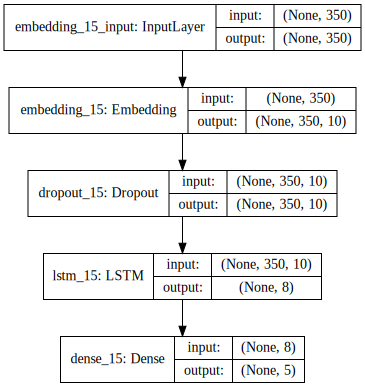

In [ ]:
model_4.summary()
if COLAB:
    display(SVG(model_to_dot(model_4,show_shapes=True,dpi=72).create(prog='dot', format='svg')))
else:
    display(SVG(model_to_dot(model_4,show_shapes=True).create(prog='dot', format='svg')))

#### **Reservamos, dentro del conjunto de *training*, un subconjunto de validación**

In [ ]:
# Entreno sobre X_tr,y_tr monitorizo el aprendizaje sobre X_va,y_va
X_tr, X_va, y_tr, y_va = train_test_split(X_train_pad, y_train, test_size=0.3, random_state=1)
print(X_tr.shape, len(y_tr))
print(X_va.shape, len(y_va))

(2450, 350) 2450
(1050, 350) 1050


#### **Entrenamiento del modelo**

In [ ]:
batch_size = 512
nepocas = 100

best_val_acc  = 0
best_val_loss = 1e20
best_i        = 0

best_weights = []
acum_tr_acc = []
acum_tr_loss = []
acum_val_acc = []
acum_val_loss = []

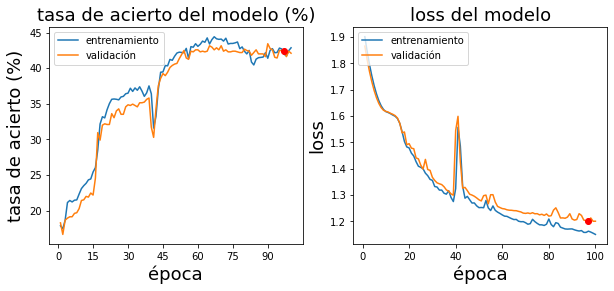

In [ ]:
for e in range(nepocas):
  h = model_4.fit(X_tr, y_tr,
                batch_size=batch_size,
                validation_data=(X_va, y_va),
                epochs=1, verbose=1)
  
  acum_tr_acc  = acum_tr_acc  + h.history['accuracy']
  acum_tr_loss = acum_tr_loss + h.history['loss']
  val_acc  = h.history['val_accuracy'][0]
  val_loss = h.history['val_loss'][0]
  acum_val_acc  = acum_val_acc  + [val_acc]
  acum_val_loss = acum_val_loss + [val_loss]
#  if val_acc  > best_val_acc:
  if val_loss < best_val_loss:
    best_i        = len(acum_val_acc)-1
    best_val_acc  = val_acc
    best_val_loss = val_loss
    best_weights = model_4.get_weights().copy()
  if len(acum_tr_acc)>1 and (len(acum_tr_acc)+1) % 1 == 0:
    if e>1:
      clear_output()
    grafica_entrenamiento(acum_tr_acc, acum_val_acc, acum_tr_loss, acum_val_loss, best_i)

In [ ]:
model_4.set_weights(best_weights)

In [ ]:
scores = model_4.evaluate(X_test_pad, y_test, verbose=1)
print("Accuracy in test: %.2f%%" % (scores[1]*100))

1500/1500 [==============================] - 2s 1ms/step
Accuracy in test: 42.33%


### **4.4: Análisis del *embedding***

Antes de pasar al siguiente experimento, vamos a determinar cómo de eficiente es nuestro modelo, determinando aquellas palabras que sean más similares o, mejor dicho, estén más asociadas, según este modelo, a las distintas clases de los textos:

In [ ]:
def most_similar_words(embedding,word,n=10):
  n_latent_dimensions = np.shape(embedding)[1]
  ind = word2int[word]
  aux = np.reshape(embedding[ind,:], (1,n_latent_dimensions))
  dists = pairwise_distances(aux, embedding).flatten()
  inds = dists.argsort().tolist()
  inds.remove(ind)
  return [int2word[i] for i in inds[:n]]

embedding = model_4.get_weights()[0]
embedding.shape

(2500, 10)

In [ ]:
most_similar_words(embedding,'alzheimer')

['future',
 "'s",
 'dementia',
 'cognitive',
 'species',
 'disease',
 'diseases',
 'brain',
 'age',
 'development']

In [ ]:
most_similar_words(embedding,'bladder')

['cervical',
 'cancer',
 'breast',
 'carcinoma',
 'tumor',
 'chemotherapy',
 'hpv',
 'urothelial',
 'radiotherapy',
 'biopsy']

In [ ]:
most_similar_words(embedding,'breast')

['cancer',
 'bladder',
 'cervical',
 'tumor',
 'carcinoma',
 'hpv',
 'chemotherapy',
 'urothelial',
 'radiotherapy',
 'tumors']

In [ ]:
most_similar_words(embedding,'cervical')

['carcinoma',
 'tumor',
 'hpv',
 'chemotherapy',
 'urothelial',
 'bladder',
 'radiotherapy',
 'tumors',
 'biopsy',
 'metastatic']

In [ ]:
most_similar_words(embedding,'negative')

['precision',
 'post',
 '001',
 'nodes',
 'search',
 'estimated',
 'demonstrated',
 'long',
 'decreases',
 'any']

## **5. Experimento 5**

A continuación, para este experimento y los sucesivos, vamos a indicar los valores utilizados para los hiperparámetros. En este caso, son los siguientes:

**VALORES QUE SE USARÁN PARA LOS HIPERPARÁMETROS**:


*   **top_words** = 2500
*   **max_review_length** = 350
*   **embedding_vector_length** = 5
*   **n_neurons** = 8
*   **l** = 0.0005
*   **Dropout**(rate = 0.3)



En este caso, hemos probado a bajar el valor de *embedding_vector_length* de 10 a 5. 

### **5.1: Determinación de las palabras más frecuentes**

In [ ]:
top_words = 2500 # HYPERPARAMETER, VOCABULARY SIZE

tk = Tokenizer(oov_token='(oov)', num_words=(top_words-1))
tk.fit_on_texts(data_train["text"])

In [ ]:
X_train  = [np.array([0] + x)+1 for x in tk.texts_to_sequences(data_train["text"])]
X_test   = [np.array([0] + x)+1 for x in tk.texts_to_sequences(data_test["text"])]

In [ ]:
X_train[0]

array([   1,    2,    2,   27,  490,   23,  869,    8,  197,    4, 2364,
          2,    2,    2,    2,    9,   30,    2, 2279,    2,    5,  836,
        809,  555,   53,    9,    3,  762,    8,  787,  166,  386, 1310,
          9,    8,  508,    4,    2, 1396,  230,   39,   13,  159,    9,
          2,  543, 2016,    9,  700,    2,    2,  424,    5,  621,    2,
          2, 2401, 1325,   11,  101,    7,   43,   30,    2,    2,    5,
        251, 1616,    2,    2,    9,    8, 2402, 2279,    9, 1953,    4,
       1415,  354, 1325,    2,   20,  166, 1299,    9, 2279,    2,    2,
          2,   18,  214,    2,    2,  424,    2,    8,    2,    2,    2,
       1325,  540,    2,   65,  155, 1299,    9,  187,  189,    4,    2,
        391,    4,    3, 2279,    2,  162,    3,   44,  444,    4,    8,
        480,  397,    4, 1047, 1247,   13, 2403,   11,   51,    2,    5,
       1325,  251,  701,  269, 2049,    2,   27,    8,  490, 1326,   87,
         62,   28,  159, 1483,    9,    2, 2279,   

In [ ]:
min([x.min() for x in X_train]), max([x.max() for x in X_train]), min([x.min() for x in X_test]), max([x.max() for x in X_test])

(1, 2499, 1, 2499)

In [ ]:
int2word = {(i+1):tk.index_word[i] for i in range(1,top_words-1)} # el 0 no está incluido, se reserva para padding
int2word[0] = "(padding)"
int2word[1] = "(start)"

word2int = {int2word[i]:i for i in range(top_words)}

In [ ]:
int2word[0], int2word[1], int2word[2], int2word[max([x.max() for x in X_train])], word2int["the"] #, word2int["whoopi"]

('(padding)', '(start)', '(oov)', 'experiment', 3)

20 palabras más frecuentes:

In [ ]:
for i in range(20):
    print(i, int2word[i])

0 (padding)
1 (start)
2 (oov)
3 the
4 of
5 and
6 in
7 to
8 a
9 with
10 for
11 was
12 were
13 cancer
14 is
15 patients
16 that
17 0
18 as
19 by


In [ ]:
ejemplo = 1

print(X_train[ejemplo], "\n") #Array con los índices asociados a cada palabra del texto.
print("\033[1m"+"Índices y sus palabras asociadas:")
for i,x in enumerate(X_train[ejemplo][:50]):
  print("{} -> {}".format(x, int2word[x])) #Se muestra el índice junto con su palabra asociada.
if (i+1)<len(X_train[ejemplo]): 
  print("...")
print("Class: {}".format(y_train[ejemplo])) 

[   1    3   90   44   13  487    2   14  457    2 1450  723   10    3
  358  311    5 1554  114    3  157  275    4   78   45    2   14    7
    2    2   38    5  782    4  487   15  328  936  363   89  230   18
  124   18  132  230  264    2    3 1641    4    3 1901    4 1379   14
    3    2  165    3    2    6    3    2  763   14    3    2    4    2
    4    2   10  358    5  520  148  114    3  139  151  847  349   28
 1248   21    3    2  328  264   10    3  358  114    4  487  440    2
    4   47 2280 2129    2   47   53    2    2    2   44   47 1249    2
   10    3  176  487  114] 

Índices y sus palabras asociadas:
1 -> (start)
3 -> the
90 -> human
44 -> bladder
13 -> cancer
487 -> bc
2 -> (oov)
14 -> is
457 -> being
2 -> (oov)
1450 -> every
723 -> day
10 -> for
3 -> the
358 -> better
311 -> management
5 -> and
1554 -> efficient
114 -> diagnosis
3 -> the
157 -> primary
275 -> aim
4 -> of
78 -> all
45 -> these
2 -> (oov)
14 -> is
7 -> to
2 -> (oov)
2 -> (oov)
38 -> treatment
5 -

### **5.2: *Padding* de las palabras**

In [ ]:
max_review_length = 350 # HYPERPARAMETER
X_train_pad = sequence.pad_sequences(X_train, maxlen=max_review_length)
X_test_pad = sequence.pad_sequences(X_test, maxlen=max_review_length)
int2word[0] = "(padding)"

print("Tamaño del dataset de training después del padding:", X_train_pad.shape)
print("Los códigos de palabras van de {} a {}".format(X_train_pad.min(), X_train_pad.max()))

Tamaño del dataset de training después del padding: (3500, 350)
Los códigos de palabras van de 0 a 2499


In [ ]:
data_train["text"][1369]

'ureteroarterial fistulas are rare we describe a case of ureteral-arterial fistulas uaf repaired with an endovascular stent graft and examine late complications associated with the procedure a 37-year-old woman with a history of complicated locally invasive cervical cancer treated with chemoradiation presented initially with right leg rest pain and chronic intermittent gross hematuria she was found to have an ureteroarterial fistula and underwent successful endovascular exclusion with a covered stent with resolution of her symptoms she returned 1 year later with stent-graft thrombosis manifesting as lower extremity rest pain requiring a femoral-femoral bypass she then returned 6 months later with imaging evidence of extravascular migration of the stent graft into the bladder because of a poor prognosis of recurrent gynecologic cancer extraction was not attempted and she underwent complete urinary diversion uafs are a rare occurrence but may be treated successfully with endovascular ste

In [ ]:
X_train_pad[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

### **5.3: Construcción de la red neuronal (LSTM)**

In [ ]:
# HYPERPARAMETERS: ***
embedding_vector_length = 5 # HYPERPARAMETER
N_NEURONS = 8
# ********************


N_CLASSES = 5

rnn = LSTM
model_5 = Sequential()
model_5.add(Embedding(top_words, # número de palabras del vocabulario incluido 0 de padding
                    embedding_vector_length, # número de dimensiones que quieres que tenga el embedding
                    # l: "fuerza" del regularizador. Cuanto máás alto, más regulariza (pone a 0 componentes)
                    embeddings_regularizer=regularizers.l1(l=0.0005), # regularización (intenta poner a cero componentes)
                    input_length=max_review_length)) # tamaño de la secuencia de palabras
model_5.add(Dropout(rate=0.3))
model_5.add(rnn(N_NEURONS)) # MANY TO ONE (return_sequences no es True)
model_5.add(Dense(N_CLASSES, activation='softmax'))
model_5.compile(loss='sparse_categorical_crossentropy', # binarycrossentropy porque hay 2 clases, si hay más, categorical_crossentropy
              optimizer=Adam(lr=0.001), # lr: velocidad de aprendizaje
              metrics=['accuracy'])

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_16 (Embedding)     (None, 350, 5)            12500     
_________________________________________________________________
dropout_16 (Dropout)         (None, 350, 5)            0         
_________________________________________________________________
lstm_16 (LSTM)               (None, 8)                 448       
_________________________________________________________________
dense_16 (Dense)             (None, 5)                 45        
Total params: 12,993
Trainable params: 12,993
Non-trainable params: 0
_________________________________________________________________


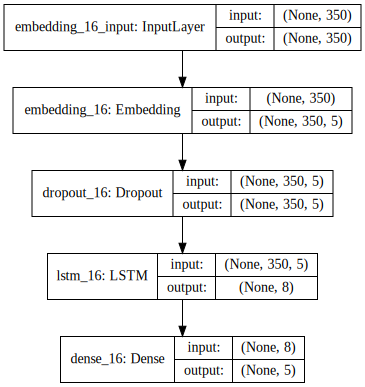

In [ ]:
model_5.summary()
if COLAB:
    display(SVG(model_to_dot(model_5,show_shapes=True,dpi=72).create(prog='dot', format='svg')))
else:
    display(SVG(model_to_dot(model_5,show_shapes=True).create(prog='dot', format='svg')))

#### **Reservamos, dentro del conjunto de *training*, un subconjunto de validación**

In [ ]:
# Entreno sobre X_tr,y_tr monitorizo el aprendizaje sobre X_va,y_va
X_tr, X_va, y_tr, y_va = train_test_split(X_train_pad, y_train, test_size=0.3, random_state=1)
print(X_tr.shape, len(y_tr))
print(X_va.shape, len(y_va))

(2450, 350) 2450
(1050, 350) 1050


#### **Entrenamiento del modelo**

In [ ]:
batch_size = 512
nepocas = 100

best_val_acc  = 0
best_val_loss = 1e20
best_i        = 0

best_weights = []
acum_tr_acc = []
acum_tr_loss = []
acum_val_acc = []
acum_val_loss = []

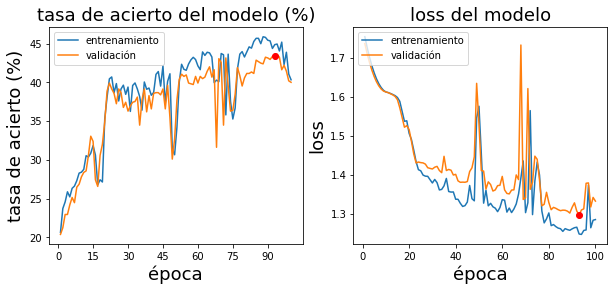

In [ ]:
for e in range(nepocas):
  h = model_5.fit(X_tr, y_tr,
                batch_size=batch_size,
                validation_data=(X_va, y_va),
                epochs=1, verbose=1)
  
  acum_tr_acc  = acum_tr_acc  + h.history['accuracy']
  acum_tr_loss = acum_tr_loss + h.history['loss']
  val_acc  = h.history['val_accuracy'][0]
  val_loss = h.history['val_loss'][0]
  acum_val_acc  = acum_val_acc  + [val_acc]
  acum_val_loss = acum_val_loss + [val_loss]
#  if val_acc  > best_val_acc:
  if val_loss < best_val_loss:
    best_i        = len(acum_val_acc)-1
    best_val_acc  = val_acc
    best_val_loss = val_loss
    best_weights = model_5.get_weights().copy()
  if len(acum_tr_acc)>1 and (len(acum_tr_acc)+1) % 1 == 0:
    if e>1:
      clear_output()
    grafica_entrenamiento(acum_tr_acc, acum_val_acc, acum_tr_loss, acum_val_loss, best_i)

In [ ]:
model_5.set_weights(best_weights)

In [ ]:
scores = model_5.evaluate(X_test_pad, y_test, verbose=1)
print("Accuracy in test: %.2f%%" % (scores[1]*100))

1500/1500 [==============================] - 2s 1ms/step
Accuracy in test: 43.13%


### **5.4: Análisis del *embedding***

In [ ]:
def most_similar_words(embedding,word,n=10):
  n_latent_dimensions = np.shape(embedding)[1]
  ind = word2int[word]
  aux = np.reshape(embedding[ind,:], (1,n_latent_dimensions))
  dists = pairwise_distances(aux, embedding).flatten()
  inds = dists.argsort().tolist()
  inds.remove(ind)
  return [int2word[i] for i in inds[:n]]

embedding = model_5.get_weights()[0]
embedding.shape

(2500, 5)

In [ ]:
most_similar_words(embedding,'alzheimer')

['hela',
 'cervical',
 'hpv',
 'dementia',
 'abeta',
 "'s",
 'amyloid',
 '(start)',
 'ad',
 'ache']

In [ ]:
most_similar_words(embedding,'bladder')

['mcf',
 'hiv',
 'response',
 'outcomes',
 'invasive',
 'bmi',
 'metastatic',
 'recurrence',
 'body',
 'results']

In [ ]:
most_similar_words(embedding,'breast')

['bladder',
 'mcf',
 'hiv',
 'response',
 'outcomes',
 'invasive',
 'metastatic',
 'results',
 'recurrence',
 'bmi']

In [ ]:
most_similar_words(embedding,'cervical')

['alzheimer',
 'hela',
 'hpv',
 'dementia',
 'abeta',
 "'s",
 '(start)',
 'amyloid',
 'ache',
 'ad']

In [ ]:
most_similar_words(embedding,'negative')

['stability',
 'square',
 'examine',
 'initial',
 'decreasing',
 'accumulation',
 'substrate',
 'healthcare',
 'homeostasis',
 '150']

## **6. Experimento 6**

A continuación, para este experimento y los sucesivos, vamos a indicar los valores utilizados para los hiperparámetros. En este caso, son los siguientes:

**VALORES QUE SE USARÁN PARA LOS HIPERPARÁMETROS**:


*   **top_words** = 2500
*   **max_review_length** = 350
*   **embedding_vector_length** = 50
*   **n_neurons** = 8
*   **l** = 0.0005
*   **Dropout**(rate = 0.3)



En este caso, hemos probado a subir el valor de *embedding_vector_length* de 5 a 50. 

### **6.1: Determinación de las palabras más frecuentes**

In [ ]:
top_words = 2500 # HYPERPARAMETER, VOCABULARY SIZE

tk = Tokenizer(oov_token='(oov)', num_words=(top_words-1))
tk.fit_on_texts(data_train["text"])

In [ ]:
X_train  = [np.array([0] + x)+1 for x in tk.texts_to_sequences(data_train["text"])]
X_test   = [np.array([0] + x)+1 for x in tk.texts_to_sequences(data_test["text"])]

In [ ]:
X_train[0]

array([   1,    2,    2,   27,  490,   23,  869,    8,  197,    4, 2364,
          2,    2,    2,    2,    9,   30,    2, 2279,    2,    5,  836,
        809,  555,   53,    9,    3,  762,    8,  787,  166,  386, 1310,
          9,    8,  508,    4,    2, 1396,  230,   39,   13,  159,    9,
          2,  543, 2016,    9,  700,    2,    2,  424,    5,  621,    2,
          2, 2401, 1325,   11,  101,    7,   43,   30,    2,    2,    5,
        251, 1616,    2,    2,    9,    8, 2402, 2279,    9, 1953,    4,
       1415,  354, 1325,    2,   20,  166, 1299,    9, 2279,    2,    2,
          2,   18,  214,    2,    2,  424,    2,    8,    2,    2,    2,
       1325,  540,    2,   65,  155, 1299,    9,  187,  189,    4,    2,
        391,    4,    3, 2279,    2,  162,    3,   44,  444,    4,    8,
        480,  397,    4, 1047, 1247,   13, 2403,   11,   51,    2,    5,
       1325,  251,  701,  269, 2049,    2,   27,    8,  490, 1326,   87,
         62,   28,  159, 1483,    9,    2, 2279,   

In [ ]:
min([x.min() for x in X_train]), max([x.max() for x in X_train]), min([x.min() for x in X_test]), max([x.max() for x in X_test])

(1, 2499, 1, 2499)

In [ ]:
int2word = {(i+1):tk.index_word[i] for i in range(1,top_words-1)} # el 0 no está incluido, se reserva para padding
int2word[0] = "(padding)"
int2word[1] = "(start)"

word2int = {int2word[i]:i for i in range(top_words)}

In [ ]:
int2word[0], int2word[1], int2word[2], int2word[max([x.max() for x in X_train])], word2int["the"] #, word2int["whoopi"]

('(padding)', '(start)', '(oov)', 'experiment', 3)

20 palabras más frecuentes:

In [ ]:
for i in range(20):
    print(i, int2word[i])

0 (padding)
1 (start)
2 (oov)
3 the
4 of
5 and
6 in
7 to
8 a
9 with
10 for
11 was
12 were
13 cancer
14 is
15 patients
16 that
17 0
18 as
19 by


In [ ]:
ejemplo = 1

print(X_train[ejemplo], "\n") #Array con los índices asociados a cada palabra del texto.
print("\033[1m"+"Índices y sus palabras asociadas:")
for i,x in enumerate(X_train[ejemplo][:50]):
  print("{} -> {}".format(x, int2word[x])) #Se muestra el índice junto con su palabra asociada.
if (i+1)<len(X_train[ejemplo]): 
  print("...")
print("Class: {}".format(y_train[ejemplo])) 

[   1    3   90   44   13  487    2   14  457    2 1450  723   10    3
  358  311    5 1554  114    3  157  275    4   78   45    2   14    7
    2    2   38    5  782    4  487   15  328  936  363   89  230   18
  124   18  132  230  264    2    3 1641    4    3 1901    4 1379   14
    3    2  165    3    2    6    3    2  763   14    3    2    4    2
    4    2   10  358    5  520  148  114    3  139  151  847  349   28
 1248   21    3    2  328  264   10    3  358  114    4  487  440    2
    4   47 2280 2129    2   47   53    2    2    2   44   47 1249    2
   10    3  176  487  114] 

Índices y sus palabras asociadas:
1 -> (start)
3 -> the
90 -> human
44 -> bladder
13 -> cancer
487 -> bc
2 -> (oov)
14 -> is
457 -> being
2 -> (oov)
1450 -> every
723 -> day
10 -> for
3 -> the
358 -> better
311 -> management
5 -> and
1554 -> efficient
114 -> diagnosis
3 -> the
157 -> primary
275 -> aim
4 -> of
78 -> all
45 -> these
2 -> (oov)
14 -> is
7 -> to
2 -> (oov)
2 -> (oov)
38 -> treatment
5 -

### **6.2: *Padding* de las palabras**

In [ ]:
max_review_length = 350 # HYPERPARAMETER
X_train_pad = sequence.pad_sequences(X_train, maxlen=max_review_length)
X_test_pad = sequence.pad_sequences(X_test, maxlen=max_review_length)
int2word[0] = "(padding)"

print("Tamaño del dataset de training después del padding:", X_train_pad.shape)
print("Los códigos de palabras van de {} a {}".format(X_train_pad.min(), X_train_pad.max()))

Tamaño del dataset de training después del padding: (3500, 350)
Los códigos de palabras van de 0 a 2499


In [ ]:
data_train["text"][1369]

'ureteroarterial fistulas are rare we describe a case of ureteral-arterial fistulas uaf repaired with an endovascular stent graft and examine late complications associated with the procedure a 37-year-old woman with a history of complicated locally invasive cervical cancer treated with chemoradiation presented initially with right leg rest pain and chronic intermittent gross hematuria she was found to have an ureteroarterial fistula and underwent successful endovascular exclusion with a covered stent with resolution of her symptoms she returned 1 year later with stent-graft thrombosis manifesting as lower extremity rest pain requiring a femoral-femoral bypass she then returned 6 months later with imaging evidence of extravascular migration of the stent graft into the bladder because of a poor prognosis of recurrent gynecologic cancer extraction was not attempted and she underwent complete urinary diversion uafs are a rare occurrence but may be treated successfully with endovascular ste

In [ ]:
X_train_pad[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

### **6.3: Construcción de la red neuronal (LSTM)**

In [ ]:
# HYPERPARAMETERS: ***
embedding_vector_length = 50 # HYPERPARAMETER
N_NEURONS = 8
# ********************


N_CLASSES = 5

rnn = LSTM
model_6 = Sequential()
model_6.add(Embedding(top_words, # número de palabras del vocabulario incluido 0 de padding
                    embedding_vector_length, # número de dimensiones que quieres que tenga el embedding
                    # l: "fuerza" del regularizador. Cuanto máás alto, más regulariza (pone a 0 componentes)
                    embeddings_regularizer=regularizers.l1(l=0.0005), # regularización (intenta poner a cero componentes)
                    input_length=max_review_length)) # tamaño de la secuencia de palabras
model_6.add(Dropout(rate=0.3))
model_6.add(rnn(N_NEURONS)) # MANY TO ONE (return_sequences no es True)
model_6.add(Dense(N_CLASSES, activation='softmax'))
model_6.compile(loss='sparse_categorical_crossentropy', # binarycrossentropy porque hay 2 clases, si hay más, categorical_crossentropy
              optimizer=Adam(lr=0.001), # lr: velocidad de aprendizaje
              metrics=['accuracy'])

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_20 (Embedding)     (None, 350, 50)           125000    
_________________________________________________________________
dropout_20 (Dropout)         (None, 350, 50)           0         
_________________________________________________________________
lstm_20 (LSTM)               (None, 8)                 1888      
_________________________________________________________________
dense_20 (Dense)             (None, 5)                 45        
Total params: 126,933
Trainable params: 126,933
Non-trainable params: 0
_________________________________________________________________


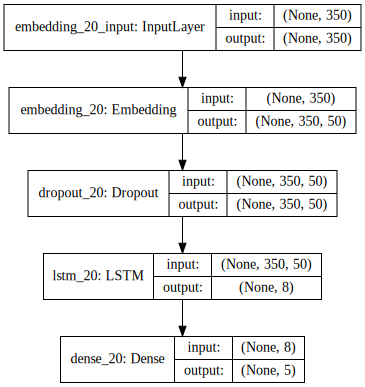

In [ ]:
model_6.summary()
if COLAB:
    display(SVG(model_to_dot(model_6,show_shapes=True,dpi=72).create(prog='dot', format='svg')))
else:
    display(SVG(model_to_dot(model_6,show_shapes=True).create(prog='dot', format='svg')))

#### **Reservamos, dentro del conjunto de *training*, un subconjunto de validación**

In [ ]:
# Entreno sobre X_tr,y_tr monitorizo el aprendizaje sobre X_va,y_va
X_tr, X_va, y_tr, y_va = train_test_split(X_train_pad, y_train, test_size=0.3, random_state=1)
print(X_tr.shape, len(y_tr))
print(X_va.shape, len(y_va))

(2450, 350) 2450
(1050, 350) 1050


#### **Entrenamiento del modelo**

In [ ]:
batch_size = 512
nepocas = 100

best_val_acc  = 0
best_val_loss = 1e20
best_i        = 0

best_weights = []
acum_tr_acc = []
acum_tr_loss = []
acum_val_acc = []
acum_val_loss = []

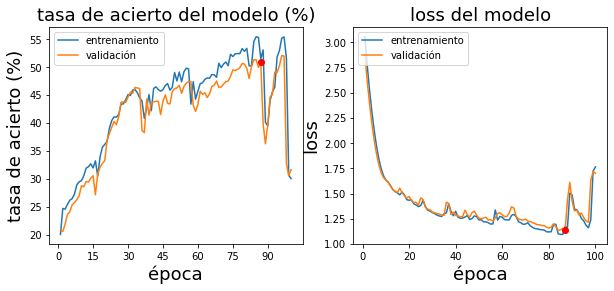

In [ ]:
for e in range(nepocas):
  h = model_6.fit(X_tr, y_tr,
                batch_size=batch_size,
                validation_data=(X_va, y_va),
                epochs=1, verbose=1)
  
  acum_tr_acc  = acum_tr_acc  + h.history['accuracy']
  acum_tr_loss = acum_tr_loss + h.history['loss']
  val_acc  = h.history['val_accuracy'][0]
  val_loss = h.history['val_loss'][0]
  acum_val_acc  = acum_val_acc  + [val_acc]
  acum_val_loss = acum_val_loss + [val_loss]
#  if val_acc  > best_val_acc:
  if val_loss < best_val_loss:
    best_i        = len(acum_val_acc)-1
    best_val_acc  = val_acc
    best_val_loss = val_loss
    best_weights = model_6.get_weights().copy()
  if len(acum_tr_acc)>1 and (len(acum_tr_acc)+1) % 1 == 0:
    if e>1:
      clear_output()
    grafica_entrenamiento(acum_tr_acc, acum_val_acc, acum_tr_loss, acum_val_loss, best_i)

In [ ]:
model_6.set_weights(best_weights)

In [ ]:
scores = model_6.evaluate(X_test_pad, y_test, verbose=1)
print("Accuracy in test: %.2f%%" % (scores[1]*100))

1500/1500 [==============================] - 1s 822us/step
Accuracy in test: 52.07%


### **6.4: Análisis del *embedding***

In [ ]:
def most_similar_words(embedding,word,n=10):
  n_latent_dimensions = np.shape(embedding)[1]
  ind = word2int[word]
  aux = np.reshape(embedding[ind,:], (1,n_latent_dimensions))
  dists = pairwise_distances(aux, embedding).flatten()
  inds = dists.argsort().tolist()
  inds.remove(ind)
  return [int2word[i] for i in inds[:n]]

embedding = model_6.get_weights()[0]
embedding.shape

(2500, 50)

In [ ]:
most_similar_words(embedding,'alzheimer')

['dementia',
 'abeta',
 'amyloid',
 'disease',
 "'s",
 'ache',
 'neurodegenerative',
 'cognitive',
 'brain',
 'tau']

In [ ]:
most_similar_words(embedding,'bladder')

['carcinoma',
 'tumors',
 'cervical',
 'hpv',
 'cancer',
 'therapy',
 'prostate',
 'cases',
 'liver',
 'chemotherapy']

In [ ]:
most_similar_words(embedding,'breast')

['cancer',
 'cervical',
 'bladder',
 'carcinoma',
 'tumors',
 'hpv',
 'therapy',
 'prostate',
 'cancers',
 'chemotherapy']

In [ ]:
most_similar_words(embedding,'cervical')

['cancer',
 'bladder',
 'breast',
 'carcinoma',
 'tumors',
 'hpv',
 'therapy',
 'prostate',
 'chemotherapy',
 'cases']

In [ ]:
most_similar_words(embedding,'negative')

['above',
 'hiv',
 'models',
 'statistical',
 'attention',
 'crucial',
 'controlling',
 'correlated',
 'should',
 'critical']

## **7. Experimento 7**

A continuación, para este experimento y los sucesivos, vamos a indicar los valores utilizados para los hiperparámetros. En este caso, son los siguientes:

**VALORES QUE SE USARÁN PARA LOS HIPERPARÁMETROS**:


*   **top_words** = 2500
*   **max_review_length** = 350
*   **embedding_vector_length** = 10
*   **n_neurons** = 4
*   **l** = 0.0005
*   **Dropout**(rate = 0.3)



En este caso, hemos probado a bajar el valor de *n_neurons* de 8 a 4. 

### **7.1: Determinación de las palabras más frecuentes**

In [ ]:
top_words = 2500 # HYPERPARAMETER, VOCABULARY SIZE

tk = Tokenizer(oov_token='(oov)', num_words=(top_words-1))
tk.fit_on_texts(data_train["text"])

In [ ]:
X_train  = [np.array([0] + x)+1 for x in tk.texts_to_sequences(data_train["text"])]
X_test   = [np.array([0] + x)+1 for x in tk.texts_to_sequences(data_test["text"])]

In [ ]:
X_train[0]

array([   1,    2,    2,   27,  490,   23,  869,    8,  197,    4, 2364,
          2,    2,    2,    2,    9,   30,    2, 2279,    2,    5,  836,
        809,  555,   53,    9,    3,  762,    8,  787,  166,  386, 1310,
          9,    8,  508,    4,    2, 1396,  230,   39,   13,  159,    9,
          2,  543, 2016,    9,  700,    2,    2,  424,    5,  621,    2,
          2, 2401, 1325,   11,  101,    7,   43,   30,    2,    2,    5,
        251, 1616,    2,    2,    9,    8, 2402, 2279,    9, 1953,    4,
       1415,  354, 1325,    2,   20,  166, 1299,    9, 2279,    2,    2,
          2,   18,  214,    2,    2,  424,    2,    8,    2,    2,    2,
       1325,  540,    2,   65,  155, 1299,    9,  187,  189,    4,    2,
        391,    4,    3, 2279,    2,  162,    3,   44,  444,    4,    8,
        480,  397,    4, 1047, 1247,   13, 2403,   11,   51,    2,    5,
       1325,  251,  701,  269, 2049,    2,   27,    8,  490, 1326,   87,
         62,   28,  159, 1483,    9,    2, 2279,   

In [ ]:
min([x.min() for x in X_train]), max([x.max() for x in X_train]), min([x.min() for x in X_test]), max([x.max() for x in X_test])

(1, 2499, 1, 2499)

In [ ]:
int2word = {(i+1):tk.index_word[i] for i in range(1,top_words-1)} # el 0 no está incluido, se reserva para padding
int2word[0] = "(padding)"
int2word[1] = "(start)"

word2int = {int2word[i]:i for i in range(top_words)}

In [ ]:
int2word[0], int2word[1], int2word[2], int2word[max([x.max() for x in X_train])], word2int["the"] #, word2int["whoopi"]

('(padding)', '(start)', '(oov)', 'experiment', 3)

20 palabras más frecuentes:

In [ ]:
for i in range(20):
    print(i, int2word[i])

0 (padding)
1 (start)
2 (oov)
3 the
4 of
5 and
6 in
7 to
8 a
9 with
10 for
11 was
12 were
13 cancer
14 is
15 patients
16 that
17 0
18 as
19 by


In [ ]:
ejemplo = 1

print(X_train[ejemplo], "\n") #Array con los índices asociados a cada palabra del texto.
print("\033[1m"+"Índices y sus palabras asociadas:")
for i,x in enumerate(X_train[ejemplo][:50]):
  print("{} -> {}".format(x, int2word[x])) #Se muestra el índice junto con su palabra asociada.
if (i+1)<len(X_train[ejemplo]): 
  print("...")
print("Class: {}".format(y_train[ejemplo])) 

[   1    3   90   44   13  487    2   14  457    2 1450  723   10    3
  358  311    5 1554  114    3  157  275    4   78   45    2   14    7
    2    2   38    5  782    4  487   15  328  936  363   89  230   18
  124   18  132  230  264    2    3 1641    4    3 1901    4 1379   14
    3    2  165    3    2    6    3    2  763   14    3    2    4    2
    4    2   10  358    5  520  148  114    3  139  151  847  349   28
 1248   21    3    2  328  264   10    3  358  114    4  487  440    2
    4   47 2280 2129    2   47   53    2    2    2   44   47 1249    2
   10    3  176  487  114] 

Índices y sus palabras asociadas:
1 -> (start)
3 -> the
90 -> human
44 -> bladder
13 -> cancer
487 -> bc
2 -> (oov)
14 -> is
457 -> being
2 -> (oov)
1450 -> every
723 -> day
10 -> for
3 -> the
358 -> better
311 -> management
5 -> and
1554 -> efficient
114 -> diagnosis
3 -> the
157 -> primary
275 -> aim
4 -> of
78 -> all
45 -> these
2 -> (oov)
14 -> is
7 -> to
2 -> (oov)
2 -> (oov)
38 -> treatment
5 -

### **7.2: *Padding* de las palabras**

In [ ]:
max_review_length = 350 # HYPERPARAMETER
X_train_pad = sequence.pad_sequences(X_train, maxlen=max_review_length)
X_test_pad = sequence.pad_sequences(X_test, maxlen=max_review_length)
int2word[0] = "(padding)"

print("Tamaño del dataset de training después del padding:", X_train_pad.shape)
print("Los códigos de palabras van de {} a {}".format(X_train_pad.min(), X_train_pad.max()))

Tamaño del dataset de training después del padding: (3500, 350)
Los códigos de palabras van de 0 a 2499


In [ ]:
data_train["text"][1369]

'ureteroarterial fistulas are rare we describe a case of ureteral-arterial fistulas uaf repaired with an endovascular stent graft and examine late complications associated with the procedure a 37-year-old woman with a history of complicated locally invasive cervical cancer treated with chemoradiation presented initially with right leg rest pain and chronic intermittent gross hematuria she was found to have an ureteroarterial fistula and underwent successful endovascular exclusion with a covered stent with resolution of her symptoms she returned 1 year later with stent-graft thrombosis manifesting as lower extremity rest pain requiring a femoral-femoral bypass she then returned 6 months later with imaging evidence of extravascular migration of the stent graft into the bladder because of a poor prognosis of recurrent gynecologic cancer extraction was not attempted and she underwent complete urinary diversion uafs are a rare occurrence but may be treated successfully with endovascular ste

In [ ]:
X_train_pad[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

### **7.3: Construcción de la red neuronal (LSTM)**

In [ ]:
# HYPERPARAMETERS: ***
embedding_vector_length = 10 # HYPERPARAMETER
N_NEURONS = 4
# ********************


N_CLASSES = 5

rnn = LSTM
model_7 = Sequential()
model_7.add(Embedding(top_words, # número de palabras del vocabulario incluido 0 de padding
                    embedding_vector_length, # número de dimensiones que quieres que tenga el embedding
                    # l: "fuerza" del regularizador. Cuanto máás alto, más regulariza (pone a 0 componentes)
                    embeddings_regularizer=regularizers.l1(l=0.0005), # regularización (intenta poner a cero componentes)
                    input_length=max_review_length)) # tamaño de la secuencia de palabras
model_7.add(Dropout(rate=0.3))
model_7.add(rnn(N_NEURONS)) # MANY TO ONE (return_sequences no es True)
model_7.add(Dense(N_CLASSES, activation='softmax'))
model_7.compile(loss='sparse_categorical_crossentropy', # binarycrossentropy porque hay 2 clases, si hay más, categorical_crossentropy
              optimizer=Adam(lr=0.001), # lr: velocidad de aprendizaje
              metrics=['accuracy'])

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_25 (Embedding)     (None, 350, 10)           25000     
_________________________________________________________________
dropout_25 (Dropout)         (None, 350, 10)           0         
_________________________________________________________________
lstm_25 (LSTM)               (None, 4)                 240       
_________________________________________________________________
dense_25 (Dense)             (None, 5)                 25        
Total params: 25,265
Trainable params: 25,265
Non-trainable params: 0
_________________________________________________________________


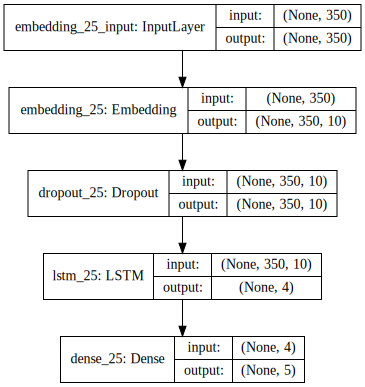

In [ ]:
model_7.summary()
if COLAB:
    display(SVG(model_to_dot(model_7,show_shapes=True,dpi=72).create(prog='dot', format='svg')))
else:
    display(SVG(model_to_dot(model_7,show_shapes=True).create(prog='dot', format='svg')))

#### **Reservamos, dentro del conjunto de *training*, un subconjunto de validación**

In [ ]:
# Entreno sobre X_tr,y_tr monitorizo el aprendizaje sobre X_va,y_va
X_tr, X_va, y_tr, y_va = train_test_split(X_train_pad, y_train, test_size=0.3, random_state=1)
print(X_tr.shape, len(y_tr))
print(X_va.shape, len(y_va))

(2450, 350) 2450
(1050, 350) 1050


#### **Entrenamiento del modelo**

In [ ]:
batch_size = 512
nepocas = 100

best_val_acc  = 0
best_val_loss = 1e20
best_i        = 0

best_weights = []
acum_tr_acc = []
acum_tr_loss = []
acum_val_acc = []
acum_val_loss = []

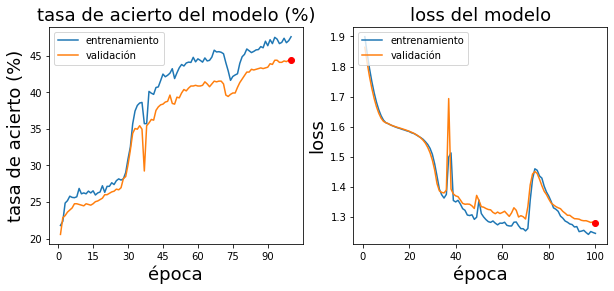

In [ ]:
for e in range(nepocas):
  h = model_7.fit(X_tr, y_tr,
                batch_size=batch_size,
                validation_data=(X_va, y_va),
                epochs=1, verbose=1)
  
  acum_tr_acc  = acum_tr_acc  + h.history['accuracy']
  acum_tr_loss = acum_tr_loss + h.history['loss']
  val_acc  = h.history['val_accuracy'][0]
  val_loss = h.history['val_loss'][0]
  acum_val_acc  = acum_val_acc  + [val_acc]
  acum_val_loss = acum_val_loss + [val_loss]
#  if val_acc  > best_val_acc:
  if val_loss < best_val_loss:
    best_i        = len(acum_val_acc)-1
    best_val_acc  = val_acc
    best_val_loss = val_loss
    best_weights = model_7.get_weights().copy()
  if len(acum_tr_acc)>1 and (len(acum_tr_acc)+1) % 1 == 0:
    if e>1:
      clear_output()
    grafica_entrenamiento(acum_tr_acc, acum_val_acc, acum_tr_loss, acum_val_loss, best_i)

In [ ]:
model_7.set_weights(best_weights)

In [ ]:
scores = model_7.evaluate(X_test_pad, y_test, verbose=1)
print("Accuracy in test: %.2f%%" % (scores[1]*100))

1500/1500 [==============================] - 1s 577us/step
Accuracy in test: 44.47%


### **7.4: Análisis del *embedding***

In [ ]:
def most_similar_words(embedding,word,n=10):
  n_latent_dimensions = np.shape(embedding)[1]
  ind = word2int[word]
  aux = np.reshape(embedding[ind,:], (1,n_latent_dimensions))
  dists = pairwise_distances(aux, embedding).flatten()
  inds = dists.argsort().tolist()
  inds.remove(ind)
  return [int2word[i] for i in inds[:n]]

embedding = model_7.get_weights()[0]
embedding.shape

(2500, 10)

In [ ]:
most_similar_words(embedding,'alzheimer')

['cervical',
 'ad',
 'abeta',
 'hpv',
 'dementia',
 'ache',
 'diseases',
 'hela',
 'amyloid',
 'disease']

In [ ]:
most_similar_words(embedding,'bladder')

['urothelial',
 'recurrence',
 'growth',
 'metastatic',
 '0',
 'mutations',
 'is',
 'not',
 'has',
 'bc']

In [ ]:
most_similar_words(embedding,'breast')

['cancer',
 'patients',
 'tumor',
 'therapy',
 'expression',
 'this',
 'has',
 'positive',
 'metastatic',
 '7']

In [ ]:
most_similar_words(embedding,'cervical')

['alzheimer',
 'hpv',
 'abeta',
 'dementia',
 'ache',
 'ad',
 'hela',
 'promising',
 'screening',
 'disease']

In [ ]:
most_similar_words(embedding,'negative')

['nodal',
 'mean',
 'no',
 'estrogen',
 'ec',
 'detecting',
 'genotyping',
 'exact',
 'total',
 'structural']

## **8. Experimento 8**

A continuación, para este experimento y los sucesivos, vamos a indicar los valores utilizados para los hiperparámetros. En este caso, son los siguientes:

**VALORES QUE SE USARÁN PARA LOS HIPERPARÁMETROS**:


*   **top_words** = 2500
*   **max_review_length** = 350
*   **embedding_vector_length** = 10
*   **n_neurons** = 20
*   **l** = 0.0005
*   **Dropout**(rate = 0.3)



En este caso, hemos probado a subir el valor de *n_neurons* de 4 a 20. 

### **8.1: Determinación de las palabras más frecuentes**

In [ ]:
top_words = 2500 # HYPERPARAMETER, VOCABULARY SIZE

tk = Tokenizer(oov_token='(oov)', num_words=(top_words-1))
tk.fit_on_texts(data_train["text"])

In [ ]:
X_train  = [np.array([0] + x)+1 for x in tk.texts_to_sequences(data_train["text"])]
X_test   = [np.array([0] + x)+1 for x in tk.texts_to_sequences(data_test["text"])]

In [ ]:
X_train[0]

array([   1,    2,    2,   27,  490,   23,  869,    8,  197,    4, 2364,
          2,    2,    2,    2,    9,   30,    2, 2279,    2,    5,  836,
        809,  555,   53,    9,    3,  762,    8,  787,  166,  386, 1310,
          9,    8,  508,    4,    2, 1396,  230,   39,   13,  159,    9,
          2,  543, 2016,    9,  700,    2,    2,  424,    5,  621,    2,
          2, 2401, 1325,   11,  101,    7,   43,   30,    2,    2,    5,
        251, 1616,    2,    2,    9,    8, 2402, 2279,    9, 1953,    4,
       1415,  354, 1325,    2,   20,  166, 1299,    9, 2279,    2,    2,
          2,   18,  214,    2,    2,  424,    2,    8,    2,    2,    2,
       1325,  540,    2,   65,  155, 1299,    9,  187,  189,    4,    2,
        391,    4,    3, 2279,    2,  162,    3,   44,  444,    4,    8,
        480,  397,    4, 1047, 1247,   13, 2403,   11,   51,    2,    5,
       1325,  251,  701,  269, 2049,    2,   27,    8,  490, 1326,   87,
         62,   28,  159, 1483,    9,    2, 2279,   

In [ ]:
min([x.min() for x in X_train]), max([x.max() for x in X_train]), min([x.min() for x in X_test]), max([x.max() for x in X_test])

(1, 2499, 1, 2499)

In [ ]:
int2word = {(i+1):tk.index_word[i] for i in range(1,top_words-1)} # el 0 no está incluido, se reserva para padding
int2word[0] = "(padding)"
int2word[1] = "(start)"

word2int = {int2word[i]:i for i in range(top_words)}

In [ ]:
int2word[0], int2word[1], int2word[2], int2word[max([x.max() for x in X_train])], word2int["the"] #, word2int["whoopi"]

('(padding)', '(start)', '(oov)', 'experiment', 3)

20 palabras más frecuentes:

In [ ]:
for i in range(20):
    print(i, int2word[i])

0 (padding)
1 (start)
2 (oov)
3 the
4 of
5 and
6 in
7 to
8 a
9 with
10 for
11 was
12 were
13 cancer
14 is
15 patients
16 that
17 0
18 as
19 by


In [ ]:
ejemplo = 1

print(X_train[ejemplo], "\n") #Array con los índices asociados a cada palabra del texto.
print("\033[1m"+"Índices y sus palabras asociadas:")
for i,x in enumerate(X_train[ejemplo][:50]):
  print("{} -> {}".format(x, int2word[x])) #Se muestra el índice junto con su palabra asociada.
if (i+1)<len(X_train[ejemplo]): 
  print("...")
print("Class: {}".format(y_train[ejemplo])) 

[   1    3   90   44   13  487    2   14  457    2 1450  723   10    3
  358  311    5 1554  114    3  157  275    4   78   45    2   14    7
    2    2   38    5  782    4  487   15  328  936  363   89  230   18
  124   18  132  230  264    2    3 1641    4    3 1901    4 1379   14
    3    2  165    3    2    6    3    2  763   14    3    2    4    2
    4    2   10  358    5  520  148  114    3  139  151  847  349   28
 1248   21    3    2  328  264   10    3  358  114    4  487  440    2
    4   47 2280 2129    2   47   53    2    2    2   44   47 1249    2
   10    3  176  487  114] 

Índices y sus palabras asociadas:
1 -> (start)
3 -> the
90 -> human
44 -> bladder
13 -> cancer
487 -> bc
2 -> (oov)
14 -> is
457 -> being
2 -> (oov)
1450 -> every
723 -> day
10 -> for
3 -> the
358 -> better
311 -> management
5 -> and
1554 -> efficient
114 -> diagnosis
3 -> the
157 -> primary
275 -> aim
4 -> of
78 -> all
45 -> these
2 -> (oov)
14 -> is
7 -> to
2 -> (oov)
2 -> (oov)
38 -> treatment
5 -

### **8.2: *Padding* de las palabras**

In [ ]:
max_review_length = 350 # HYPERPARAMETER
X_train_pad = sequence.pad_sequences(X_train, maxlen=max_review_length)
X_test_pad = sequence.pad_sequences(X_test, maxlen=max_review_length)
int2word[0] = "(padding)"

print("Tamaño del dataset de training después del padding:", X_train_pad.shape)
print("Los códigos de palabras van de {} a {}".format(X_train_pad.min(), X_train_pad.max()))

Tamaño del dataset de training después del padding: (3500, 350)
Los códigos de palabras van de 0 a 2499


In [ ]:
data_train["text"][1369]

'ureteroarterial fistulas are rare we describe a case of ureteral-arterial fistulas uaf repaired with an endovascular stent graft and examine late complications associated with the procedure a 37-year-old woman with a history of complicated locally invasive cervical cancer treated with chemoradiation presented initially with right leg rest pain and chronic intermittent gross hematuria she was found to have an ureteroarterial fistula and underwent successful endovascular exclusion with a covered stent with resolution of her symptoms she returned 1 year later with stent-graft thrombosis manifesting as lower extremity rest pain requiring a femoral-femoral bypass she then returned 6 months later with imaging evidence of extravascular migration of the stent graft into the bladder because of a poor prognosis of recurrent gynecologic cancer extraction was not attempted and she underwent complete urinary diversion uafs are a rare occurrence but may be treated successfully with endovascular ste

In [ ]:
X_train_pad[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

### **8.3: Construcción de la red neuronal (LSTM)**

In [ ]:
# HYPERPARAMETERS: ***
embedding_vector_length = 10 # HYPERPARAMETER
N_NEURONS = 20
# ********************


N_CLASSES = 5

rnn = LSTM
model_8 = Sequential()
model_8.add(Embedding(top_words, # número de palabras del vocabulario incluido 0 de padding
                    embedding_vector_length, # número de dimensiones que quieres que tenga el embedding
                    # l: "fuerza" del regularizador. Cuanto máás alto, más regulariza (pone a 0 componentes)
                    embeddings_regularizer=regularizers.l1(l=0.0005), # regularización (intenta poner a cero componentes)
                    input_length=max_review_length)) # tamaño de la secuencia de palabras
model_8.add(Dropout(rate=0.3))
model_8.add(rnn(N_NEURONS)) # MANY TO ONE (return_sequences no es True)
model_8.add(Dense(N_CLASSES, activation='softmax'))
model_8.compile(loss='sparse_categorical_crossentropy', # binarycrossentropy porque hay 2 clases, si hay más, categorical_crossentropy
              optimizer=Adam(lr=0.001), # lr: velocidad de aprendizaje
              metrics=['accuracy'])

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_27 (Embedding)     (None, 350, 10)           25000     
_________________________________________________________________
dropout_27 (Dropout)         (None, 350, 10)           0         
_________________________________________________________________
lstm_27 (LSTM)               (None, 20)                2480      
_________________________________________________________________
dense_27 (Dense)             (None, 5)                 105       
Total params: 27,585
Trainable params: 27,585
Non-trainable params: 0
_________________________________________________________________


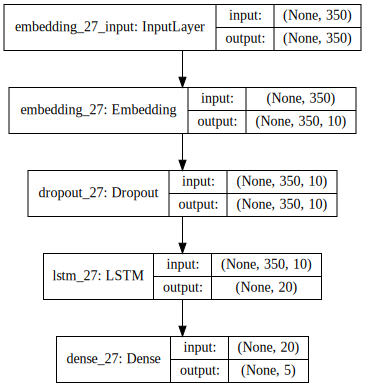

In [ ]:
model_8.summary()
if COLAB:
    display(SVG(model_to_dot(model_8,show_shapes=True,dpi=72).create(prog='dot', format='svg')))
else:
    display(SVG(model_to_dot(model_8,show_shapes=True).create(prog='dot', format='svg')))

#### **Reservamos, dentro del conjunto de *training*, un subconjunto de validación**

In [ ]:
# Entreno sobre X_tr,y_tr monitorizo el aprendizaje sobre X_va,y_va
X_tr, X_va, y_tr, y_va = train_test_split(X_train_pad, y_train, test_size=0.3, random_state=1)
print(X_tr.shape, len(y_tr))
print(X_va.shape, len(y_va))

(2450, 350) 2450
(1050, 350) 1050


#### **Entrenamiento del modelo**

In [ ]:
batch_size = 512
nepocas = 100

best_val_acc  = 0
best_val_loss = 1e20
best_i        = 0

best_weights = []
acum_tr_acc = []
acum_tr_loss = []
acum_val_acc = []
acum_val_loss = []

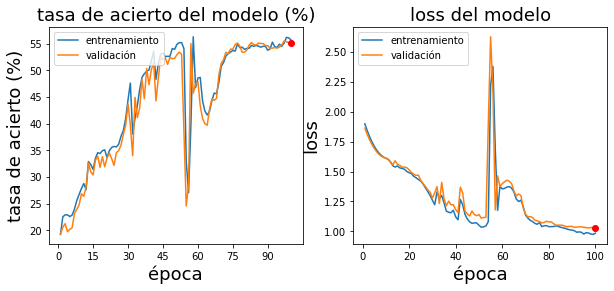

In [ ]:
for e in range(nepocas):
  h = model_8.fit(X_tr, y_tr,
                batch_size=batch_size,
                validation_data=(X_va, y_va),
                epochs=1, verbose=1)
  
  acum_tr_acc  = acum_tr_acc  + h.history['accuracy']
  acum_tr_loss = acum_tr_loss + h.history['loss']
  val_acc  = h.history['val_accuracy'][0]
  val_loss = h.history['val_loss'][0]
  acum_val_acc  = acum_val_acc  + [val_acc]
  acum_val_loss = acum_val_loss + [val_loss]
#  if val_acc  > best_val_acc:
  if val_loss < best_val_loss:
    best_i        = len(acum_val_acc)-1
    best_val_acc  = val_acc
    best_val_loss = val_loss
    best_weights = model_8.get_weights().copy()
  if len(acum_tr_acc)>1 and (len(acum_tr_acc)+1) % 1 == 0:
    if e>1:
      clear_output()
    grafica_entrenamiento(acum_tr_acc, acum_val_acc, acum_tr_loss, acum_val_loss, best_i)

In [ ]:
model_8.set_weights(best_weights)

In [ ]:
scores = model_8.evaluate(X_test_pad, y_test, verbose=1)
print("Accuracy in test: %.2f%%" % (scores[1]*100))

1500/1500 [==============================] - 1s 757us/step
Accuracy in test: 54.73%


### **8.4: Análisis del *embedding***

In [ ]:
def most_similar_words(embedding,word,n=10):
  n_latent_dimensions = np.shape(embedding)[1]
  ind = word2int[word]
  aux = np.reshape(embedding[ind,:], (1,n_latent_dimensions))
  dists = pairwise_distances(aux, embedding).flatten()
  inds = dists.argsort().tolist()
  inds.remove(ind)
  return [int2word[i] for i in inds[:n]]

embedding = model_8.get_weights()[0]
embedding.shape

(2500, 10)

In [ ]:
most_similar_words(embedding,'alzheimer')

['dementia',
 'abeta',
 'disease',
 'diseases',
 "'s",
 'cognitive',
 'amyloid',
 'tau',
 'brain',
 'future']

In [ ]:
most_similar_words(embedding,'bladder')

['cervical',
 'carcinoma',
 'hpv',
 'urothelial',
 'hela',
 'urinary',
 'cystectomy',
 'prostate',
 'tumors',
 'cervix']

In [ ]:
most_similar_words(embedding,'breast')

['cancer',
 'mcf',
 'chemotherapy',
 'metastatic',
 'targeted',
 'metastasis',
 'tumors',
 'cancers',
 'therapy',
 'metastases']

In [ ]:
most_similar_words(embedding,'cervical')

['bladder',
 'hpv',
 'carcinoma',
 'hela',
 'urothelial',
 'tumors',
 'urinary',
 'prostate',
 'cystectomy',
 'biopsy']

In [ ]:
most_similar_words(embedding,'negative')

['mastectomy',
 'women',
 'tnbc',
 'mda',
 'result',
 'sirna',
 'cytotoxic',
 'skin',
 'information',
 'agents']

## **9. Experimento 9**

A continuación, para este experimento y los sucesivos, vamos a indicar los valores utilizados para los hiperparámetros. En este caso, son los siguientes:

**VALORES QUE SE USARÁN PARA LOS HIPERPARÁMETROS**:


*   **top_words** = 2500
*   **max_review_length** = 350
*   **embedding_vector_length** = 50
*   **n_neurons** = 40
*   **l** = 0.0005
*   **Dropout**(rate = 0.3)



En este caso, hemos probado a subir el valor de *n_neurons* a 40 y el de *embedding_vector_length* a 50. 

### **9.1: Determinación de las palabras más frecuentes**

In [ ]:
top_words = 2500 # HYPERPARAMETER, VOCABULARY SIZE

tk = Tokenizer(oov_token='(oov)', num_words=(top_words-1))
tk.fit_on_texts(data_train["text"])

In [ ]:
X_train  = [np.array([0] + x)+1 for x in tk.texts_to_sequences(data_train["text"])]
X_test   = [np.array([0] + x)+1 for x in tk.texts_to_sequences(data_test["text"])]

In [ ]:
X_train[0]

array([   1,    2,    2,   27,  490,   23,  869,    8,  197,    4, 2364,
          2,    2,    2,    2,    9,   30,    2, 2279,    2,    5,  836,
        809,  555,   53,    9,    3,  762,    8,  787,  166,  386, 1310,
          9,    8,  508,    4,    2, 1396,  230,   39,   13,  159,    9,
          2,  543, 2016,    9,  700,    2,    2,  424,    5,  621,    2,
          2, 2401, 1325,   11,  101,    7,   43,   30,    2,    2,    5,
        251, 1616,    2,    2,    9,    8, 2402, 2279,    9, 1953,    4,
       1415,  354, 1325,    2,   20,  166, 1299,    9, 2279,    2,    2,
          2,   18,  214,    2,    2,  424,    2,    8,    2,    2,    2,
       1325,  540,    2,   65,  155, 1299,    9,  187,  189,    4,    2,
        391,    4,    3, 2279,    2,  162,    3,   44,  444,    4,    8,
        480,  397,    4, 1047, 1247,   13, 2403,   11,   51,    2,    5,
       1325,  251,  701,  269, 2049,    2,   27,    8,  490, 1326,   87,
         62,   28,  159, 1483,    9,    2, 2279,   

In [ ]:
min([x.min() for x in X_train]), max([x.max() for x in X_train]), min([x.min() for x in X_test]), max([x.max() for x in X_test])

(1, 2499, 1, 2499)

In [ ]:
int2word = {(i+1):tk.index_word[i] for i in range(1,top_words-1)} # el 0 no está incluido, se reserva para padding
int2word[0] = "(padding)"
int2word[1] = "(start)"

word2int = {int2word[i]:i for i in range(top_words)}

In [ ]:
int2word[0], int2word[1], int2word[2], int2word[max([x.max() for x in X_train])], word2int["the"] #, word2int["whoopi"]

('(padding)', '(start)', '(oov)', 'experiment', 3)

20 palabras más frecuentes:

In [ ]:
for i in range(20):
    print(i, int2word[i])

0 (padding)
1 (start)
2 (oov)
3 the
4 of
5 and
6 in
7 to
8 a
9 with
10 for
11 was
12 were
13 cancer
14 is
15 patients
16 that
17 0
18 as
19 by


In [ ]:
ejemplo = 1

print(X_train[ejemplo], "\n") #Array con los índices asociados a cada palabra del texto.
print("\033[1m"+"Índices y sus palabras asociadas:")
for i,x in enumerate(X_train[ejemplo][:50]):
  print("{} -> {}".format(x, int2word[x])) #Se muestra el índice junto con su palabra asociada.
if (i+1)<len(X_train[ejemplo]): 
  print("...")
print("Class: {}".format(y_train[ejemplo])) 

[   1    3   90   44   13  487    2   14  457    2 1450  723   10    3
  358  311    5 1554  114    3  157  275    4   78   45    2   14    7
    2    2   38    5  782    4  487   15  328  936  363   89  230   18
  124   18  132  230  264    2    3 1641    4    3 1901    4 1379   14
    3    2  165    3    2    6    3    2  763   14    3    2    4    2
    4    2   10  358    5  520  148  114    3  139  151  847  349   28
 1248   21    3    2  328  264   10    3  358  114    4  487  440    2
    4   47 2280 2129    2   47   53    2    2    2   44   47 1249    2
   10    3  176  487  114] 

Índices y sus palabras asociadas:
1 -> (start)
3 -> the
90 -> human
44 -> bladder
13 -> cancer
487 -> bc
2 -> (oov)
14 -> is
457 -> being
2 -> (oov)
1450 -> every
723 -> day
10 -> for
3 -> the
358 -> better
311 -> management
5 -> and
1554 -> efficient
114 -> diagnosis
3 -> the
157 -> primary
275 -> aim
4 -> of
78 -> all
45 -> these
2 -> (oov)
14 -> is
7 -> to
2 -> (oov)
2 -> (oov)
38 -> treatment
5 -

### **9.2: *Padding* de las palabras**

In [ ]:
max_review_length = 350 # HYPERPARAMETER
X_train_pad = sequence.pad_sequences(X_train, maxlen=max_review_length)
X_test_pad = sequence.pad_sequences(X_test, maxlen=max_review_length)
int2word[0] = "(padding)"

print("Tamaño del dataset de training después del padding:", X_train_pad.shape)
print("Los códigos de palabras van de {} a {}".format(X_train_pad.min(), X_train_pad.max()))

Tamaño del dataset de training después del padding: (3500, 350)
Los códigos de palabras van de 0 a 2499


In [ ]:
data_train["text"][1369]

'ureteroarterial fistulas are rare we describe a case of ureteral-arterial fistulas uaf repaired with an endovascular stent graft and examine late complications associated with the procedure a 37-year-old woman with a history of complicated locally invasive cervical cancer treated with chemoradiation presented initially with right leg rest pain and chronic intermittent gross hematuria she was found to have an ureteroarterial fistula and underwent successful endovascular exclusion with a covered stent with resolution of her symptoms she returned 1 year later with stent-graft thrombosis manifesting as lower extremity rest pain requiring a femoral-femoral bypass she then returned 6 months later with imaging evidence of extravascular migration of the stent graft into the bladder because of a poor prognosis of recurrent gynecologic cancer extraction was not attempted and she underwent complete urinary diversion uafs are a rare occurrence but may be treated successfully with endovascular ste

In [ ]:
X_train_pad[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

### **9.3: Construcción de la red neuronal (LSTM)**

In [ ]:
# HYPERPARAMETERS: ***
embedding_vector_length = 50 # HYPERPARAMETER
N_NEURONS = 40
# ********************


N_CLASSES = 5

rnn = LSTM
model_9 = Sequential()
model_9.add(Embedding(top_words, # número de palabras del vocabulario incluido 0 de padding
                    embedding_vector_length, # número de dimensiones que quieres que tenga el embedding
                    # l: "fuerza" del regularizador. Cuanto máás alto, más regulariza (pone a 0 componentes)
                    embeddings_regularizer=regularizers.l1(l=0.0005), # regularización (intenta poner a cero componentes)
                    input_length=max_review_length)) # tamaño de la secuencia de palabras
model_9.add(Dropout(rate=0.3))
model_9.add(rnn(N_NEURONS)) # MANY TO ONE (return_sequences no es True)
model_9.add(Dense(N_CLASSES, activation='softmax'))
model_9.compile(loss='sparse_categorical_crossentropy', # binarycrossentropy porque hay 2 clases, si hay más, categorical_crossentropy
              optimizer=Adam(lr=0.001), # lr: velocidad de aprendizaje
              metrics=['accuracy'])

Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_28 (Embedding)     (None, 350, 50)           125000    
_________________________________________________________________
dropout_28 (Dropout)         (None, 350, 50)           0         
_________________________________________________________________
lstm_28 (LSTM)               (None, 40)                14560     
_________________________________________________________________
dense_28 (Dense)             (None, 5)                 205       
Total params: 139,765
Trainable params: 139,765
Non-trainable params: 0
_________________________________________________________________


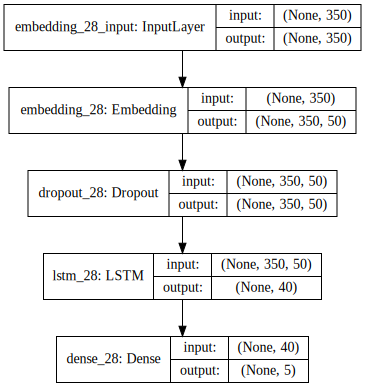

In [ ]:
model_9.summary()
if COLAB:
    display(SVG(model_to_dot(model_9,show_shapes=True,dpi=72).create(prog='dot', format='svg')))
else:
    display(SVG(model_to_dot(model_9,show_shapes=True).create(prog='dot', format='svg')))

#### **Reservamos, dentro del conjunto de *training*, un subconjunto de validación**

In [ ]:
# Entreno sobre X_tr,y_tr monitorizo el aprendizaje sobre X_va,y_va
X_tr, X_va, y_tr, y_va = train_test_split(X_train_pad, y_train, test_size=0.3, random_state=1)
print(X_tr.shape, len(y_tr))
print(X_va.shape, len(y_va))

(2450, 350) 2450
(1050, 350) 1050


#### **Entrenamiento del modelo**

In [ ]:
batch_size = 512
nepocas = 100

best_val_acc  = 0
best_val_loss = 1e20
best_i        = 0

best_weights = []
acum_tr_acc = []
acum_tr_loss = []
acum_val_acc = []
acum_val_loss = []

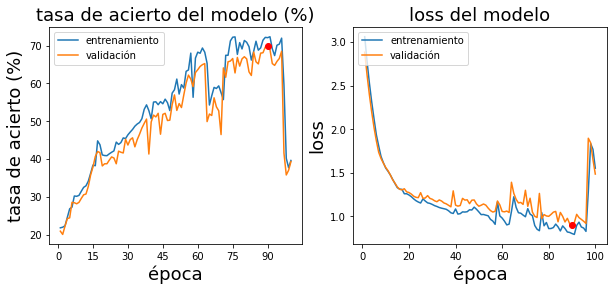

In [ ]:
for e in range(nepocas):
  h = model_9.fit(X_tr, y_tr,
                batch_size=batch_size,
                validation_data=(X_va, y_va),
                epochs=1, verbose=1)
  
  acum_tr_acc  = acum_tr_acc  + h.history['accuracy']
  acum_tr_loss = acum_tr_loss + h.history['loss']
  val_acc  = h.history['val_accuracy'][0]
  val_loss = h.history['val_loss'][0]
  acum_val_acc  = acum_val_acc  + [val_acc]
  acum_val_loss = acum_val_loss + [val_loss]
#  if val_acc  > best_val_acc:
  if val_loss < best_val_loss:
    best_i        = len(acum_val_acc)-1
    best_val_acc  = val_acc
    best_val_loss = val_loss
    best_weights = model_9.get_weights().copy()
  if len(acum_tr_acc)>1 and (len(acum_tr_acc)+1) % 1 == 0:
    if e>1:
      clear_output()
    grafica_entrenamiento(acum_tr_acc, acum_val_acc, acum_tr_loss, acum_val_loss, best_i)

In [ ]:
model_9.set_weights(best_weights)

In [ ]:
scores = model_9.evaluate(X_test_pad, y_test, verbose=1)
print("Accuracy in test: %.2f%%" % (scores[1]*100))

1500/1500 [==============================] - 2s 1ms/step
Accuracy in test: 69.73%


### **9.4: Análisis del *embedding***

In [ ]:
def most_similar_words(embedding,word,n=10):
  n_latent_dimensions = np.shape(embedding)[1]
  ind = word2int[word]
  aux = np.reshape(embedding[ind,:], (1,n_latent_dimensions))
  dists = pairwise_distances(aux, embedding).flatten()
  inds = dists.argsort().tolist()
  inds.remove(ind)
  return [int2word[i] for i in inds[:n]]

embedding = model_9.get_weights()[0]
embedding.shape

(2500, 50)

In [ ]:
most_similar_words(embedding,'alzheimer')

['dementia',
 'ad',
 'abeta',
 'disease',
 'amyloid',
 'cognitive',
 'ache',
 'memory',
 'brain',
 "'s"]

In [ ]:
most_similar_words(embedding,'bladder')

['carcinoma',
 'cervical',
 'cancer',
 'hpv',
 'urothelial',
 'p53',
 'chemotherapy',
 'hela',
 'single',
 'tumors']

In [ ]:
most_similar_words(embedding,'breast')

['cancer',
 'mcf',
 'chemotherapy',
 'hpv',
 'carcinoma',
 'biopsy',
 'single',
 'urothelial',
 'p53',
 '(start)']

In [ ]:
most_similar_words(embedding,'cervical')

['bladder',
 'carcinoma',
 'cancer',
 'hpv',
 'urothelial',
 'hela',
 'p53',
 'chemotherapy',
 'single',
 'urinary']

In [ ]:
most_similar_words(embedding,'negative')

['changed',
 'increased',
 '74',
 '95',
 'months',
 'detecting',
 'may',
 'eight',
 'nf',
 'it']

## **10. Experimento 10**

A continuación, para este experimento y los sucesivos, vamos a indicar los valores utilizados para los hiperparámetros. En este caso, son los siguientes:

**VALORES QUE SE USARÁN PARA LOS HIPERPARÁMETROS**:


*   **top_words** = 2500
*   **max_review_length** = 350
*   **embedding_vector_length** = 3
*   **n_neurons** = 2
*   **l** = 0.0005
*   **Dropout**(rate = 0.3)



En este caso, hemos probado a bajar el valor de *n_neurons* a 2 y el de *embedding_vector_length* a 3. 

### **10.1: Determinación de las palabras más frecuentes**

In [ ]:
top_words = 2500 # HYPERPARAMETER, VOCABULARY SIZE

tk = Tokenizer(oov_token='(oov)', num_words=(top_words-1))
tk.fit_on_texts(data_train["text"])

In [ ]:
X_train  = [np.array([0] + x)+1 for x in tk.texts_to_sequences(data_train["text"])]
X_test   = [np.array([0] + x)+1 for x in tk.texts_to_sequences(data_test["text"])]

In [ ]:
X_train[0]

array([   1,    2,    2,   27,  490,   23,  869,    8,  197,    4, 2364,
          2,    2,    2,    2,    9,   30,    2, 2279,    2,    5,  836,
        809,  555,   53,    9,    3,  762,    8,  787,  166,  386, 1310,
          9,    8,  508,    4,    2, 1396,  230,   39,   13,  159,    9,
          2,  543, 2016,    9,  700,    2,    2,  424,    5,  621,    2,
          2, 2401, 1325,   11,  101,    7,   43,   30,    2,    2,    5,
        251, 1616,    2,    2,    9,    8, 2402, 2279,    9, 1953,    4,
       1415,  354, 1325,    2,   20,  166, 1299,    9, 2279,    2,    2,
          2,   18,  214,    2,    2,  424,    2,    8,    2,    2,    2,
       1325,  540,    2,   65,  155, 1299,    9,  187,  189,    4,    2,
        391,    4,    3, 2279,    2,  162,    3,   44,  444,    4,    8,
        480,  397,    4, 1047, 1247,   13, 2403,   11,   51,    2,    5,
       1325,  251,  701,  269, 2049,    2,   27,    8,  490, 1326,   87,
         62,   28,  159, 1483,    9,    2, 2279,   

In [ ]:
min([x.min() for x in X_train]), max([x.max() for x in X_train]), min([x.min() for x in X_test]), max([x.max() for x in X_test])

(1, 2499, 1, 2499)

In [ ]:
int2word = {(i+1):tk.index_word[i] for i in range(1,top_words-1)} # el 0 no está incluido, se reserva para padding
int2word[0] = "(padding)"
int2word[1] = "(start)"

word2int = {int2word[i]:i for i in range(top_words)}

In [ ]:
int2word[0], int2word[1], int2word[2], int2word[max([x.max() for x in X_train])], word2int["the"] #, word2int["whoopi"]

('(padding)', '(start)', '(oov)', 'experiment', 3)

20 palabras más frecuentes:

In [ ]:
for i in range(20):
    print(i, int2word[i])

0 (padding)
1 (start)
2 (oov)
3 the
4 of
5 and
6 in
7 to
8 a
9 with
10 for
11 was
12 were
13 cancer
14 is
15 patients
16 that
17 0
18 as
19 by


In [ ]:
ejemplo = 1

print(X_train[ejemplo], "\n") #Array con los índices asociados a cada palabra del texto.
print("\033[1m"+"Índices y sus palabras asociadas:")
for i,x in enumerate(X_train[ejemplo][:50]):
  print("{} -> {}".format(x, int2word[x])) #Se muestra el índice junto con su palabra asociada.
if (i+1)<len(X_train[ejemplo]): 
  print("...")
print("Class: {}".format(y_train[ejemplo])) 

[   1    3   90   44   13  487    2   14  457    2 1450  723   10    3
  358  311    5 1554  114    3  157  275    4   78   45    2   14    7
    2    2   38    5  782    4  487   15  328  936  363   89  230   18
  124   18  132  230  264    2    3 1641    4    3 1901    4 1379   14
    3    2  165    3    2    6    3    2  763   14    3    2    4    2
    4    2   10  358    5  520  148  114    3  139  151  847  349   28
 1248   21    3    2  328  264   10    3  358  114    4  487  440    2
    4   47 2280 2129    2   47   53    2    2    2   44   47 1249    2
   10    3  176  487  114] 

Índices y sus palabras asociadas:
1 -> (start)
3 -> the
90 -> human
44 -> bladder
13 -> cancer
487 -> bc
2 -> (oov)
14 -> is
457 -> being
2 -> (oov)
1450 -> every
723 -> day
10 -> for
3 -> the
358 -> better
311 -> management
5 -> and
1554 -> efficient
114 -> diagnosis
3 -> the
157 -> primary
275 -> aim
4 -> of
78 -> all
45 -> these
2 -> (oov)
14 -> is
7 -> to
2 -> (oov)
2 -> (oov)
38 -> treatment
5 -

### **10.2: *Padding* de las palabras**

In [ ]:
max_review_length = 350 # HYPERPARAMETER
X_train_pad = sequence.pad_sequences(X_train, maxlen=max_review_length)
X_test_pad = sequence.pad_sequences(X_test, maxlen=max_review_length)
int2word[0] = "(padding)"

print("Tamaño del dataset de training después del padding:", X_train_pad.shape)
print("Los códigos de palabras van de {} a {}".format(X_train_pad.min(), X_train_pad.max()))

Tamaño del dataset de training después del padding: (3500, 350)
Los códigos de palabras van de 0 a 2499


In [ ]:
data_train["text"][1369]

'ureteroarterial fistulas are rare we describe a case of ureteral-arterial fistulas uaf repaired with an endovascular stent graft and examine late complications associated with the procedure a 37-year-old woman with a history of complicated locally invasive cervical cancer treated with chemoradiation presented initially with right leg rest pain and chronic intermittent gross hematuria she was found to have an ureteroarterial fistula and underwent successful endovascular exclusion with a covered stent with resolution of her symptoms she returned 1 year later with stent-graft thrombosis manifesting as lower extremity rest pain requiring a femoral-femoral bypass she then returned 6 months later with imaging evidence of extravascular migration of the stent graft into the bladder because of a poor prognosis of recurrent gynecologic cancer extraction was not attempted and she underwent complete urinary diversion uafs are a rare occurrence but may be treated successfully with endovascular ste

In [ ]:
X_train_pad[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

### **10.3: Construcción de la red neuronal (LSTM)**

In [ ]:
# HYPERPARAMETERS: ***
embedding_vector_length = 3 # HYPERPARAMETER
N_NEURONS = 2
# ********************


N_CLASSES = 5

rnn = LSTM
model_10 = Sequential()
model_10.add(Embedding(top_words, # número de palabras del vocabulario incluido 0 de padding
                    embedding_vector_length, # número de dimensiones que quieres que tenga el embedding
                    # l: "fuerza" del regularizador. Cuanto máás alto, más regulariza (pone a 0 componentes)
                    embeddings_regularizer=regularizers.l1(l=0.0005), # regularización (intenta poner a cero componentes)
                    input_length=max_review_length)) # tamaño de la secuencia de palabras
model_10.add(Dropout(rate=0.3))
model_10.add(rnn(N_NEURONS)) # MANY TO ONE (return_sequences no es True)
model_10.add(Dense(N_CLASSES, activation='softmax'))
model_10.compile(loss='sparse_categorical_crossentropy', # binarycrossentropy porque hay 2 clases, si hay más, categorical_crossentropy
              optimizer=Adam(lr=0.001), # lr: velocidad de aprendizaje
              metrics=['accuracy'])

Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_29 (Embedding)     (None, 350, 3)            7500      
_________________________________________________________________
dropout_29 (Dropout)         (None, 350, 3)            0         
_________________________________________________________________
lstm_29 (LSTM)               (None, 2)                 48        
_________________________________________________________________
dense_29 (Dense)             (None, 5)                 15        
Total params: 7,563
Trainable params: 7,563
Non-trainable params: 0
_________________________________________________________________


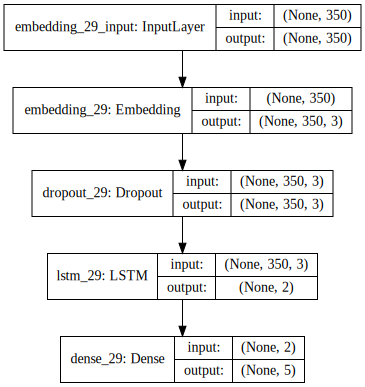

In [ ]:
model_10.summary()
if COLAB:
    display(SVG(model_to_dot(model_10,show_shapes=True,dpi=72).create(prog='dot', format='svg')))
else:
    display(SVG(model_to_dot(model_10,show_shapes=True).create(prog='dot', format='svg')))

#### **Reservamos, dentro del conjunto de *training*, un subconjunto de validación**

In [ ]:
# Entreno sobre X_tr,y_tr monitorizo el aprendizaje sobre X_va,y_va
X_tr, X_va, y_tr, y_va = train_test_split(X_train_pad, y_train, test_size=0.3, random_state=1)
print(X_tr.shape, len(y_tr))
print(X_va.shape, len(y_va))

(2450, 350) 2450
(1050, 350) 1050


#### **Entrenamiento del modelo**

In [ ]:
batch_size = 512
nepocas = 100

best_val_acc  = 0
best_val_loss = 1e20
best_i        = 0

best_weights = []
acum_tr_acc = []
acum_tr_loss = []
acum_val_acc = []
acum_val_loss = []

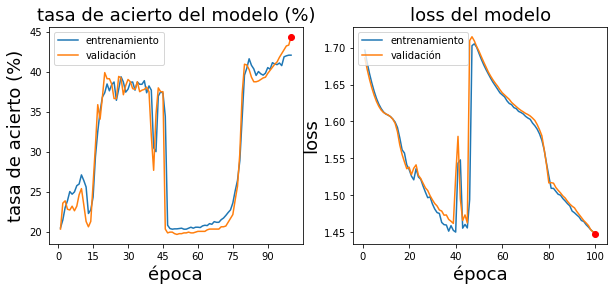

In [ ]:
for e in range(nepocas):
  h = model_10.fit(X_tr, y_tr,
                batch_size=batch_size,
                validation_data=(X_va, y_va),
                epochs=1, verbose=1)
  
  acum_tr_acc  = acum_tr_acc  + h.history['accuracy']
  acum_tr_loss = acum_tr_loss + h.history['loss']
  val_acc  = h.history['val_accuracy'][0]
  val_loss = h.history['val_loss'][0]
  acum_val_acc  = acum_val_acc  + [val_acc]
  acum_val_loss = acum_val_loss + [val_loss]
#  if val_acc  > best_val_acc:
  if val_loss < best_val_loss:
    best_i        = len(acum_val_acc)-1
    best_val_acc  = val_acc
    best_val_loss = val_loss
    best_weights = model_10.get_weights().copy()
  if len(acum_tr_acc)>1 and (len(acum_tr_acc)+1) % 1 == 0:
    if e>1:
      clear_output()
    grafica_entrenamiento(acum_tr_acc, acum_val_acc, acum_tr_loss, acum_val_loss, best_i)

In [ ]:
model_10.set_weights(best_weights)

In [ ]:
scores = model_10.evaluate(X_test_pad, y_test, verbose=1)
print("Accuracy in test: %.2f%%" % (scores[1]*100))

1500/1500 [==============================] - 1s 499us/step
Accuracy in test: 41.47%


### **10.4: Análisis del *embedding***

In [ ]:
def most_similar_words(embedding,word,n=10):
  n_latent_dimensions = np.shape(embedding)[1]
  ind = word2int[word]
  aux = np.reshape(embedding[ind,:], (1,n_latent_dimensions))
  dists = pairwise_distances(aux, embedding).flatten()
  inds = dists.argsort().tolist()
  inds.remove(ind)
  return [int2word[i] for i in inds[:n]]

embedding = model_10.get_weights()[0]
embedding.shape

(2500, 3)

In [ ]:
most_similar_words(embedding,'alzheimer')

['urothelial',
 'dementia',
 'urinary',
 "'s",
 'abeta',
 'urine',
 'uca1',
 'muscle',
 'prostate',
 'amyloid']

In [ ]:
most_similar_words(embedding,'bladder')

['alzheimer',
 'urothelial',
 'urinary',
 'dementia',
 'disease',
 'ad',
 'urine',
 "'s",
 'abeta',
 'uca1']

In [ ]:
most_similar_words(embedding,'breast')

['cervical',
 'women',
 'cancer',
 'hpv',
 'mcf',
 'targeted',
 'hela',
 'cells',
 'squamous',
 'cell']

In [ ]:
most_similar_words(embedding,'cervical')

['hpv',
 'women',
 'cancer',
 'breast',
 'targeted',
 'mcf',
 'hela',
 'screening',
 'squamous',
 'er']

In [ ]:
most_similar_words(embedding,'negative')

['tnbc',
 'dna',
 '231',
 'her2',
 'management',
 'mutations',
 'tissue',
 'axillary',
 'therapies',
 'apoptosis']

## **11. Experimento 11**

A continuación, para este experimento y los sucesivos, vamos a indicar los valores utilizados para los hiperparámetros. En este caso, son los siguientes:

**VALORES QUE SE USARÁN PARA LOS HIPERPARÁMETROS**:


*   **top_words** = 2500
*   **max_review_length** = 350
*   **embedding_vector_length** = 50
*   **n_neurons** = 40
*   **l** = 0.005
*   **Dropout**(rate = 0.3)



En este caso, hemos mantenido los valores de *embedding_vector_length* y de *n_neurons* en los valores que resultaban en un mejor *accuracy* del modelo, y además hemos aumentado l hasta 0.005. 

### **11.1: Determinación de las palabras más frecuentes**

In [ ]:
top_words = 2500 # HYPERPARAMETER, VOCABULARY SIZE

tk = Tokenizer(oov_token='(oov)', num_words=(top_words-1))
tk.fit_on_texts(data_train["text"])

In [ ]:
X_train  = [np.array([0] + x)+1 for x in tk.texts_to_sequences(data_train["text"])]
X_test   = [np.array([0] + x)+1 for x in tk.texts_to_sequences(data_test["text"])]

In [ ]:
X_train[0]

array([   1,    2,    2,   27,  490,   23,  869,    8,  197,    4, 2364,
          2,    2,    2,    2,    9,   30,    2, 2279,    2,    5,  836,
        809,  555,   53,    9,    3,  762,    8,  787,  166,  386, 1310,
          9,    8,  508,    4,    2, 1396,  230,   39,   13,  159,    9,
          2,  543, 2016,    9,  700,    2,    2,  424,    5,  621,    2,
          2, 2401, 1325,   11,  101,    7,   43,   30,    2,    2,    5,
        251, 1616,    2,    2,    9,    8, 2402, 2279,    9, 1953,    4,
       1415,  354, 1325,    2,   20,  166, 1299,    9, 2279,    2,    2,
          2,   18,  214,    2,    2,  424,    2,    8,    2,    2,    2,
       1325,  540,    2,   65,  155, 1299,    9,  187,  189,    4,    2,
        391,    4,    3, 2279,    2,  162,    3,   44,  444,    4,    8,
        480,  397,    4, 1047, 1247,   13, 2403,   11,   51,    2,    5,
       1325,  251,  701,  269, 2049,    2,   27,    8,  490, 1326,   87,
         62,   28,  159, 1483,    9,    2, 2279,   

In [ ]:
min([x.min() for x in X_train]), max([x.max() for x in X_train]), min([x.min() for x in X_test]), max([x.max() for x in X_test])

(1, 2499, 1, 2499)

In [ ]:
int2word = {(i+1):tk.index_word[i] for i in range(1,top_words-1)} # el 0 no está incluido, se reserva para padding
int2word[0] = "(padding)"
int2word[1] = "(start)"

word2int = {int2word[i]:i for i in range(top_words)}

In [ ]:
int2word[0], int2word[1], int2word[2], int2word[max([x.max() for x in X_train])], word2int["the"] #, word2int["whoopi"]

('(padding)', '(start)', '(oov)', 'experiment', 3)

20 palabras más frecuentes:

In [ ]:
for i in range(20):
    print(i, int2word[i])

0 (padding)
1 (start)
2 (oov)
3 the
4 of
5 and
6 in
7 to
8 a
9 with
10 for
11 was
12 were
13 cancer
14 is
15 patients
16 that
17 0
18 as
19 by


In [ ]:
ejemplo = 1

print(X_train[ejemplo], "\n") #Array con los índices asociados a cada palabra del texto.
print("\033[1m"+"Índices y sus palabras asociadas:")
for i,x in enumerate(X_train[ejemplo][:50]):
  print("{} -> {}".format(x, int2word[x])) #Se muestra el índice junto con su palabra asociada.
if (i+1)<len(X_train[ejemplo]): 
  print("...")
print("Class: {}".format(y_train[ejemplo])) 

[   1    3   90   44   13  487    2   14  457    2 1450  723   10    3
  358  311    5 1554  114    3  157  275    4   78   45    2   14    7
    2    2   38    5  782    4  487   15  328  936  363   89  230   18
  124   18  132  230  264    2    3 1641    4    3 1901    4 1379   14
    3    2  165    3    2    6    3    2  763   14    3    2    4    2
    4    2   10  358    5  520  148  114    3  139  151  847  349   28
 1248   21    3    2  328  264   10    3  358  114    4  487  440    2
    4   47 2280 2129    2   47   53    2    2    2   44   47 1249    2
   10    3  176  487  114] 

Índices y sus palabras asociadas:
1 -> (start)
3 -> the
90 -> human
44 -> bladder
13 -> cancer
487 -> bc
2 -> (oov)
14 -> is
457 -> being
2 -> (oov)
1450 -> every
723 -> day
10 -> for
3 -> the
358 -> better
311 -> management
5 -> and
1554 -> efficient
114 -> diagnosis
3 -> the
157 -> primary
275 -> aim
4 -> of
78 -> all
45 -> these
2 -> (oov)
14 -> is
7 -> to
2 -> (oov)
2 -> (oov)
38 -> treatment
5 -

### **11.2: *Padding* de las palabras**

In [ ]:
max_review_length = 350 # HYPERPARAMETER
X_train_pad = sequence.pad_sequences(X_train, maxlen=max_review_length)
X_test_pad = sequence.pad_sequences(X_test, maxlen=max_review_length)
int2word[0] = "(padding)"

print("Tamaño del dataset de training después del padding:", X_train_pad.shape)
print("Los códigos de palabras van de {} a {}".format(X_train_pad.min(), X_train_pad.max()))

Tamaño del dataset de training después del padding: (3500, 350)
Los códigos de palabras van de 0 a 2499


In [ ]:
data_train["text"][1369]

'ureteroarterial fistulas are rare we describe a case of ureteral-arterial fistulas uaf repaired with an endovascular stent graft and examine late complications associated with the procedure a 37-year-old woman with a history of complicated locally invasive cervical cancer treated with chemoradiation presented initially with right leg rest pain and chronic intermittent gross hematuria she was found to have an ureteroarterial fistula and underwent successful endovascular exclusion with a covered stent with resolution of her symptoms she returned 1 year later with stent-graft thrombosis manifesting as lower extremity rest pain requiring a femoral-femoral bypass she then returned 6 months later with imaging evidence of extravascular migration of the stent graft into the bladder because of a poor prognosis of recurrent gynecologic cancer extraction was not attempted and she underwent complete urinary diversion uafs are a rare occurrence but may be treated successfully with endovascular ste

In [ ]:
X_train_pad[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

### **11.3: Construcción de la red neuronal (LSTM)**

In [ ]:
# HYPERPARAMETERS: ***
embedding_vector_length = 50 # HYPERPARAMETER
N_NEURONS = 40
# ********************


N_CLASSES = 5

rnn = LSTM
model_11 = Sequential()
model_11.add(Embedding(top_words, # número de palabras del vocabulario incluido 0 de padding
                    embedding_vector_length, # número de dimensiones que quieres que tenga el embedding
                    # l: "fuerza" del regularizador. Cuanto máás alto, más regulariza (pone a 0 componentes)
                    embeddings_regularizer=regularizers.l1(l=0.005), # regularización (intenta poner a cero componentes)
                    input_length=max_review_length)) # tamaño de la secuencia de palabras
model_11.add(Dropout(rate=0.3))
model_11.add(rnn(N_NEURONS)) # MANY TO ONE (return_sequences no es True)
model_11.add(Dense(N_CLASSES, activation='softmax'))
model_11.compile(loss='sparse_categorical_crossentropy', # binarycrossentropy porque hay 2 clases, si hay más, categorical_crossentropy
              optimizer=Adam(lr=0.001), # lr: velocidad de aprendizaje
              metrics=['accuracy'])

Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_31 (Embedding)     (None, 350, 50)           125000    
_________________________________________________________________
dropout_31 (Dropout)         (None, 350, 50)           0         
_________________________________________________________________
lstm_31 (LSTM)               (None, 40)                14560     
_________________________________________________________________
dense_31 (Dense)             (None, 5)                 205       
Total params: 139,765
Trainable params: 139,765
Non-trainable params: 0
_________________________________________________________________


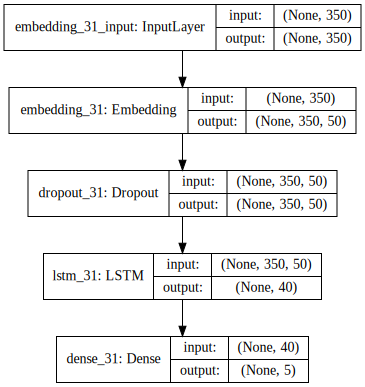

In [ ]:
model_11.summary()
if COLAB:
    display(SVG(model_to_dot(model_11,show_shapes=True,dpi=72).create(prog='dot', format='svg')))
else:
    display(SVG(model_to_dot(model_11,show_shapes=True).create(prog='dot', format='svg')))

#### **Reservamos, dentro del conjunto de *training*, un subconjunto de validación**

In [ ]:
# Entreno sobre X_tr,y_tr monitorizo el aprendizaje sobre X_va,y_va
X_tr, X_va, y_tr, y_va = train_test_split(X_train_pad, y_train, test_size=0.3, random_state=1)
print(X_tr.shape, len(y_tr))
print(X_va.shape, len(y_va))

(2450, 350) 2450
(1050, 350) 1050


#### **Entrenamiento del modelo**

In [ ]:
batch_size = 512
nepocas = 100

best_val_acc  = 0
best_val_loss = 1e20
best_i        = 0

best_weights = []
acum_tr_acc = []
acum_tr_loss = []
acum_val_acc = []
acum_val_loss = []

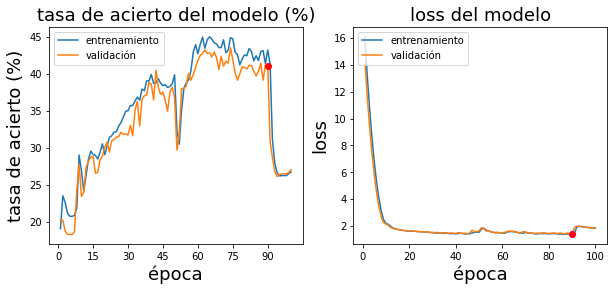

In [ ]:
for e in range(nepocas):
  h = model_11.fit(X_tr, y_tr,
                batch_size=batch_size,
                validation_data=(X_va, y_va),
                epochs=1, verbose=1)
  
  acum_tr_acc  = acum_tr_acc  + h.history['accuracy']
  acum_tr_loss = acum_tr_loss + h.history['loss']
  val_acc  = h.history['val_accuracy'][0]
  val_loss = h.history['val_loss'][0]
  acum_val_acc  = acum_val_acc  + [val_acc]
  acum_val_loss = acum_val_loss + [val_loss]
#  if val_acc  > best_val_acc:
  if val_loss < best_val_loss:
    best_i        = len(acum_val_acc)-1
    best_val_acc  = val_acc
    best_val_loss = val_loss
    best_weights = model_11.get_weights().copy()
  if len(acum_tr_acc)>1 and (len(acum_tr_acc)+1) % 1 == 0:
    if e>1:
      clear_output()
    grafica_entrenamiento(acum_tr_acc, acum_val_acc, acum_tr_loss, acum_val_loss, best_i)

In [ ]:
model_11.set_weights(best_weights)

In [ ]:
scores = model_11.evaluate(X_test_pad, y_test, verbose=1)
print("Accuracy in test: %.2f%%" % (scores[1]*100))

1500/1500 [==============================] - 3s 2ms/step
Accuracy in test: 41.87%


### **11.4: Análisis del *embedding***

In [ ]:
def most_similar_words(embedding,word,n=10):
  n_latent_dimensions = np.shape(embedding)[1]
  ind = word2int[word]
  aux = np.reshape(embedding[ind,:], (1,n_latent_dimensions))
  dists = pairwise_distances(aux, embedding).flatten()
  inds = dists.argsort().tolist()
  inds.remove(ind)
  return [int2word[i] for i in inds[:n]]

embedding = model_11.get_weights()[0]
embedding.shape

(2500, 50)

In [ ]:
most_similar_words(embedding,'alzheimer')

['dementia',
 'ad',
 'abeta',
 'disease',
 'amyloid',
 'cognitive',
 'ache',
 'memory',
 'brain',
 "'s"]

In [ ]:
most_similar_words(embedding,'bladder')

['carcinoma',
 'cervical',
 'cancer',
 'hpv',
 'urothelial',
 'p53',
 'chemotherapy',
 'hela',
 'single',
 'tumors']

In [ ]:
most_similar_words(embedding,'breast')

['cancer',
 'mcf',
 'chemotherapy',
 'hpv',
 'carcinoma',
 'biopsy',
 'single',
 'urothelial',
 'p53',
 '(start)']

In [ ]:
most_similar_words(embedding,'cervical')

['bladder',
 'carcinoma',
 'cancer',
 'hpv',
 'urothelial',
 'hela',
 'p53',
 'chemotherapy',
 'single',
 'urinary']

In [ ]:
most_similar_words(embedding,'negative')

['changed',
 'increased',
 '74',
 '95',
 'months',
 'detecting',
 'may',
 'eight',
 'nf',
 'it']

## **12. Experimento 12**

A continuación, para este experimento y los sucesivos, vamos a indicar los valores utilizados para los hiperparámetros. En este caso, son los siguientes:

**VALORES QUE SE USARÁN PARA LOS HIPERPARÁMETROS**:


*   **top_words** = 2500
*   **max_review_length** = 350
*   **embedding_vector_length** = 50
*   **n_neurons** = 40
*   **l** = 0.00005
*   **Dropout**(rate = 0.3)



En este caso, hemos mantenido los valores de *embedding_vector_length* y de *n_neurons* en los valores que resultaban en un mejor *accuracy* del modelo, y además hemos bajado l hasta 0.00005. 

### **12.1: Determinación de las palabras más frecuentes**

In [ ]:
top_words = 2500 # HYPERPARAMETER, VOCABULARY SIZE

tk = Tokenizer(oov_token='(oov)', num_words=(top_words-1))
tk.fit_on_texts(data_train["text"])

In [ ]:
X_train  = [np.array([0] + x)+1 for x in tk.texts_to_sequences(data_train["text"])]
X_test   = [np.array([0] + x)+1 for x in tk.texts_to_sequences(data_test["text"])]

In [ ]:
X_train[0]

array([   1,    2,    2,   27,  490,   23,  869,    8,  197,    4, 2364,
          2,    2,    2,    2,    9,   30,    2, 2279,    2,    5,  836,
        809,  555,   53,    9,    3,  762,    8,  787,  166,  386, 1310,
          9,    8,  508,    4,    2, 1396,  230,   39,   13,  159,    9,
          2,  543, 2016,    9,  700,    2,    2,  424,    5,  621,    2,
          2, 2401, 1325,   11,  101,    7,   43,   30,    2,    2,    5,
        251, 1616,    2,    2,    9,    8, 2402, 2279,    9, 1953,    4,
       1415,  354, 1325,    2,   20,  166, 1299,    9, 2279,    2,    2,
          2,   18,  214,    2,    2,  424,    2,    8,    2,    2,    2,
       1325,  540,    2,   65,  155, 1299,    9,  187,  189,    4,    2,
        391,    4,    3, 2279,    2,  162,    3,   44,  444,    4,    8,
        480,  397,    4, 1047, 1247,   13, 2403,   11,   51,    2,    5,
       1325,  251,  701,  269, 2049,    2,   27,    8,  490, 1326,   87,
         62,   28,  159, 1483,    9,    2, 2279,   

In [ ]:
min([x.min() for x in X_train]), max([x.max() for x in X_train]), min([x.min() for x in X_test]), max([x.max() for x in X_test])

(1, 2499, 1, 2499)

In [ ]:
int2word = {(i+1):tk.index_word[i] for i in range(1,top_words-1)} # el 0 no está incluido, se reserva para padding
int2word[0] = "(padding)"
int2word[1] = "(start)"

word2int = {int2word[i]:i for i in range(top_words)}

In [ ]:
int2word[0], int2word[1], int2word[2], int2word[max([x.max() for x in X_train])], word2int["the"] #, word2int["whoopi"]

('(padding)', '(start)', '(oov)', 'experiment', 3)

20 palabras más frecuentes:

In [ ]:
for i in range(20):
    print(i, int2word[i])

0 (padding)
1 (start)
2 (oov)
3 the
4 of
5 and
6 in
7 to
8 a
9 with
10 for
11 was
12 were
13 cancer
14 is
15 patients
16 that
17 0
18 as
19 by


In [ ]:
ejemplo = 1

print(X_train[ejemplo], "\n") #Array con los índices asociados a cada palabra del texto.
print("\033[1m"+"Índices y sus palabras asociadas:")
for i,x in enumerate(X_train[ejemplo][:50]):
  print("{} -> {}".format(x, int2word[x])) #Se muestra el índice junto con su palabra asociada.
if (i+1)<len(X_train[ejemplo]): 
  print("...")
print("Class: {}".format(y_train[ejemplo])) 

[   1    3   90   44   13  487    2   14  457    2 1450  723   10    3
  358  311    5 1554  114    3  157  275    4   78   45    2   14    7
    2    2   38    5  782    4  487   15  328  936  363   89  230   18
  124   18  132  230  264    2    3 1641    4    3 1901    4 1379   14
    3    2  165    3    2    6    3    2  763   14    3    2    4    2
    4    2   10  358    5  520  148  114    3  139  151  847  349   28
 1248   21    3    2  328  264   10    3  358  114    4  487  440    2
    4   47 2280 2129    2   47   53    2    2    2   44   47 1249    2
   10    3  176  487  114] 

Índices y sus palabras asociadas:
1 -> (start)
3 -> the
90 -> human
44 -> bladder
13 -> cancer
487 -> bc
2 -> (oov)
14 -> is
457 -> being
2 -> (oov)
1450 -> every
723 -> day
10 -> for
3 -> the
358 -> better
311 -> management
5 -> and
1554 -> efficient
114 -> diagnosis
3 -> the
157 -> primary
275 -> aim
4 -> of
78 -> all
45 -> these
2 -> (oov)
14 -> is
7 -> to
2 -> (oov)
2 -> (oov)
38 -> treatment
5 -

### **12.2: *Padding* de las palabras**

In [ ]:
max_review_length = 350 # HYPERPARAMETER
X_train_pad = sequence.pad_sequences(X_train, maxlen=max_review_length)
X_test_pad = sequence.pad_sequences(X_test, maxlen=max_review_length)
int2word[0] = "(padding)"

print("Tamaño del dataset de training después del padding:", X_train_pad.shape)
print("Los códigos de palabras van de {} a {}".format(X_train_pad.min(), X_train_pad.max()))

Tamaño del dataset de training después del padding: (3500, 350)
Los códigos de palabras van de 0 a 2499


In [ ]:
data_train["text"][1369]

'ureteroarterial fistulas are rare we describe a case of ureteral-arterial fistulas uaf repaired with an endovascular stent graft and examine late complications associated with the procedure a 37-year-old woman with a history of complicated locally invasive cervical cancer treated with chemoradiation presented initially with right leg rest pain and chronic intermittent gross hematuria she was found to have an ureteroarterial fistula and underwent successful endovascular exclusion with a covered stent with resolution of her symptoms she returned 1 year later with stent-graft thrombosis manifesting as lower extremity rest pain requiring a femoral-femoral bypass she then returned 6 months later with imaging evidence of extravascular migration of the stent graft into the bladder because of a poor prognosis of recurrent gynecologic cancer extraction was not attempted and she underwent complete urinary diversion uafs are a rare occurrence but may be treated successfully with endovascular ste

In [ ]:
X_train_pad[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

### **12.3: Construcción de la red neuronal (LSTM)**

In [ ]:
# HYPERPARAMETERS: ***
embedding_vector_length = 50 # HYPERPARAMETER
N_NEURONS = 40
# ********************


N_CLASSES = 5

rnn = LSTM
model_12 = Sequential()
model_12.add(Embedding(top_words, # número de palabras del vocabulario incluido 0 de padding
                    embedding_vector_length, # número de dimensiones que quieres que tenga el embedding
                    # l: "fuerza" del regularizador. Cuanto máás alto, más regulariza (pone a 0 componentes)
                    embeddings_regularizer=regularizers.l1(l=0.00005), # regularización (intenta poner a cero componentes)
                    input_length=max_review_length)) # tamaño de la secuencia de palabras
model_12.add(Dropout(rate=0.3))
model_12.add(rnn(N_NEURONS)) # MANY TO ONE (return_sequences no es True)
model_12.add(Dense(N_CLASSES, activation='softmax'))
model_12.compile(loss='sparse_categorical_crossentropy', # binarycrossentropy porque hay 2 clases, si hay más, categorical_crossentropy
              optimizer=Adam(lr=0.001), # lr: velocidad de aprendizaje
              metrics=['accuracy'])

Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_32 (Embedding)     (None, 350, 50)           125000    
_________________________________________________________________
dropout_32 (Dropout)         (None, 350, 50)           0         
_________________________________________________________________
lstm_32 (LSTM)               (None, 40)                14560     
_________________________________________________________________
dense_32 (Dense)             (None, 5)                 205       
Total params: 139,765
Trainable params: 139,765
Non-trainable params: 0
_________________________________________________________________


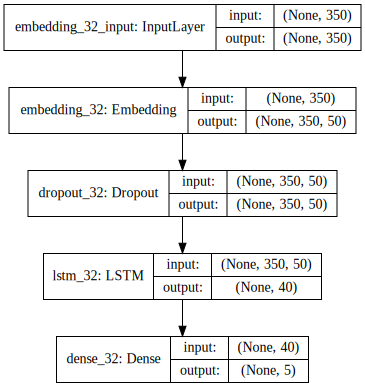

In [ ]:
model_12.summary()
if COLAB:
    display(SVG(model_to_dot(model_12,show_shapes=True,dpi=72).create(prog='dot', format='svg')))
else:
    display(SVG(model_to_dot(model_12,show_shapes=True).create(prog='dot', format='svg')))

#### **Reservamos, dentro del conjunto de *training*, un subconjunto de validación**

In [ ]:
# Entreno sobre X_tr,y_tr monitorizo el aprendizaje sobre X_va,y_va
X_tr, X_va, y_tr, y_va = train_test_split(X_train_pad, y_train, test_size=0.3, random_state=1)
print(X_tr.shape, len(y_tr))
print(X_va.shape, len(y_va))

(2450, 350) 2450
(1050, 350) 1050


#### **Entrenamiento del modelo**

In [ ]:
batch_size = 512
nepocas = 100

best_val_acc  = 0
best_val_loss = 1e20
best_i        = 0

best_weights = []
acum_tr_acc = []
acum_tr_loss = []
acum_val_acc = []
acum_val_loss = []

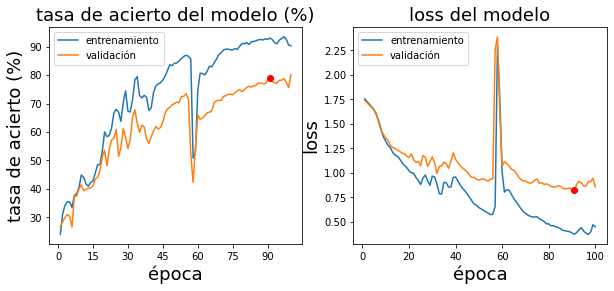

In [ ]:
for e in range(nepocas):
  h = model_12.fit(X_tr, y_tr,
                batch_size=batch_size,
                validation_data=(X_va, y_va),
                epochs=1, verbose=1)
  
  acum_tr_acc  = acum_tr_acc  + h.history['accuracy']
  acum_tr_loss = acum_tr_loss + h.history['loss']
  val_acc  = h.history['val_accuracy'][0]
  val_loss = h.history['val_loss'][0]
  acum_val_acc  = acum_val_acc  + [val_acc]
  acum_val_loss = acum_val_loss + [val_loss]
#  if val_acc  > best_val_acc:
  if val_loss < best_val_loss:
    best_i        = len(acum_val_acc)-1
    best_val_acc  = val_acc
    best_val_loss = val_loss
    best_weights = model_12.get_weights().copy()
  if len(acum_tr_acc)>1 and (len(acum_tr_acc)+1) % 1 == 0:
    if e>1:
      clear_output()
    grafica_entrenamiento(acum_tr_acc, acum_val_acc, acum_tr_loss, acum_val_loss, best_i)

In [ ]:
model_12.set_weights(best_weights)

In [ ]:
scores = model_12.evaluate(X_test_pad, y_test, verbose=1)
print("Accuracy in test: %.2f%%" % (scores[1]*100))

1500/1500 [==============================] - 2s 1ms/step
Accuracy in test: 79.53%


### **12.4: Análisis del *embedding***

In [ ]:
def most_similar_words(embedding,word,n=10):
  n_latent_dimensions = np.shape(embedding)[1]
  ind = word2int[word]
  aux = np.reshape(embedding[ind,:], (1,n_latent_dimensions))
  dists = pairwise_distances(aux, embedding).flatten()
  inds = dists.argsort().tolist()
  inds.remove(ind)
  return [int2word[i] for i in inds[:n]]

embedding = model_12.get_weights()[0]
embedding.shape

(2500, 50)

In [ ]:
most_similar_words(embedding,'alzheimer')

['amyloid',
 'abeta',
 'dementia',
 'ad',
 'ache',
 'apoe',
 'neurological',
 'tau',
 'memory',
 'direct']

In [ ]:
most_similar_words(embedding,'bladder')

['cystectomy',
 'urothelial',
 'urinary',
 'bca',
 'prostate',
 'bc',
 'turbt',
 'invasive',
 'ileal',
 'muscle']

In [ ]:
most_similar_words(embedding,'breast')

['tnbc',
 'preliminary',
 'malignancy',
 'metastatic',
 'mutations',
 'cytotoxic',
 'targeted',
 'mammary',
 'food',
 'subtype']

In [ ]:
most_similar_words(embedding,'cervical')

['hpv',
 'hela',
 'cin',
 'cervix',
 'pap',
 'cc',
 'promising',
 'leep',
 'screening',
 'gynecologic']

In [ ]:
most_similar_words(embedding,'negative')

['routine',
 'status',
 'morbidity',
 'subtypes',
 'trastuzumab',
 'skin',
 'characteristics',
 'tissues',
 'reliable',
 'cell']

## **13. Experimento 13**

A continuación, para este experimento y los sucesivos, vamos a indicar los valores utilizados para los hiperparámetros. En este caso, son los siguientes:

**VALORES QUE SE USARÁN PARA LOS HIPERPARÁMETROS**:


*   **top_words** = 2500
*   **max_review_length** = 350
*   **embedding_vector_length** = 25
*   **n_neurons** = 20
*   **l** = 0.00005
*   **Dropout**(rate = 0.3)



En este caso, hemos mantenido el valor de l en 0.00005, mientras que, en vista que el modelo anterior tenía muy buen *accuracy* aunque cierto *overfitting*, vamos a tratar de reducir este *overfitting* disminuyendo los valores de *embedding_vector_length* y de *n_neurons*.

### **13.1: Determinación de las palabras más frecuentes**

In [ ]:
top_words = 2500 # HYPERPARAMETER, VOCABULARY SIZE

tk = Tokenizer(oov_token='(oov)', num_words=(top_words-1))
tk.fit_on_texts(data_train["text"])

In [ ]:
X_train  = [np.array([0] + x)+1 for x in tk.texts_to_sequences(data_train["text"])]
X_test   = [np.array([0] + x)+1 for x in tk.texts_to_sequences(data_test["text"])]

In [ ]:
X_train[0]

array([   1,    2,    2,   27,  490,   23,  869,    8,  197,    4, 2364,
          2,    2,    2,    2,    9,   30,    2, 2279,    2,    5,  836,
        809,  555,   53,    9,    3,  762,    8,  787,  166,  386, 1310,
          9,    8,  508,    4,    2, 1396,  230,   39,   13,  159,    9,
          2,  543, 2016,    9,  700,    2,    2,  424,    5,  621,    2,
          2, 2401, 1325,   11,  101,    7,   43,   30,    2,    2,    5,
        251, 1616,    2,    2,    9,    8, 2402, 2279,    9, 1953,    4,
       1415,  354, 1325,    2,   20,  166, 1299,    9, 2279,    2,    2,
          2,   18,  214,    2,    2,  424,    2,    8,    2,    2,    2,
       1325,  540,    2,   65,  155, 1299,    9,  187,  189,    4,    2,
        391,    4,    3, 2279,    2,  162,    3,   44,  444,    4,    8,
        480,  397,    4, 1047, 1247,   13, 2403,   11,   51,    2,    5,
       1325,  251,  701,  269, 2049,    2,   27,    8,  490, 1326,   87,
         62,   28,  159, 1483,    9,    2, 2279,   

In [ ]:
min([x.min() for x in X_train]), max([x.max() for x in X_train]), min([x.min() for x in X_test]), max([x.max() for x in X_test])

(1, 2499, 1, 2499)

In [ ]:
int2word = {(i+1):tk.index_word[i] for i in range(1,top_words-1)} # el 0 no está incluido, se reserva para padding
int2word[0] = "(padding)"
int2word[1] = "(start)"

word2int = {int2word[i]:i for i in range(top_words)}

In [ ]:
int2word[0], int2word[1], int2word[2], int2word[max([x.max() for x in X_train])], word2int["the"] #, word2int["whoopi"]

('(padding)', '(start)', '(oov)', 'experiment', 3)

20 palabras más frecuentes:

In [ ]:
for i in range(20):
    print(i, int2word[i])

0 (padding)
1 (start)
2 (oov)
3 the
4 of
5 and
6 in
7 to
8 a
9 with
10 for
11 was
12 were
13 cancer
14 is
15 patients
16 that
17 0
18 as
19 by


In [ ]:
ejemplo = 1

print(X_train[ejemplo], "\n") #Array con los índices asociados a cada palabra del texto.
print("\033[1m"+"Índices y sus palabras asociadas:")
for i,x in enumerate(X_train[ejemplo][:50]):
  print("{} -> {}".format(x, int2word[x])) #Se muestra el índice junto con su palabra asociada.
if (i+1)<len(X_train[ejemplo]): 
  print("...")
print("Class: {}".format(y_train[ejemplo])) 

[   1    3   90   44   13  487    2   14  457    2 1450  723   10    3
  358  311    5 1554  114    3  157  275    4   78   45    2   14    7
    2    2   38    5  782    4  487   15  328  936  363   89  230   18
  124   18  132  230  264    2    3 1641    4    3 1901    4 1379   14
    3    2  165    3    2    6    3    2  763   14    3    2    4    2
    4    2   10  358    5  520  148  114    3  139  151  847  349   28
 1248   21    3    2  328  264   10    3  358  114    4  487  440    2
    4   47 2280 2129    2   47   53    2    2    2   44   47 1249    2
   10    3  176  487  114] 

Índices y sus palabras asociadas:
1 -> (start)
3 -> the
90 -> human
44 -> bladder
13 -> cancer
487 -> bc
2 -> (oov)
14 -> is
457 -> being
2 -> (oov)
1450 -> every
723 -> day
10 -> for
3 -> the
358 -> better
311 -> management
5 -> and
1554 -> efficient
114 -> diagnosis
3 -> the
157 -> primary
275 -> aim
4 -> of
78 -> all
45 -> these
2 -> (oov)
14 -> is
7 -> to
2 -> (oov)
2 -> (oov)
38 -> treatment
5 -

### **13.2: *Padding* de las palabras**

In [ ]:
max_review_length = 350 # HYPERPARAMETER
X_train_pad = sequence.pad_sequences(X_train, maxlen=max_review_length)
X_test_pad = sequence.pad_sequences(X_test, maxlen=max_review_length)
int2word[0] = "(padding)"

print("Tamaño del dataset de training después del padding:", X_train_pad.shape)
print("Los códigos de palabras van de {} a {}".format(X_train_pad.min(), X_train_pad.max()))

Tamaño del dataset de training después del padding: (3500, 350)
Los códigos de palabras van de 0 a 2499


In [ ]:
data_train["text"][1369]

'ureteroarterial fistulas are rare we describe a case of ureteral-arterial fistulas uaf repaired with an endovascular stent graft and examine late complications associated with the procedure a 37-year-old woman with a history of complicated locally invasive cervical cancer treated with chemoradiation presented initially with right leg rest pain and chronic intermittent gross hematuria she was found to have an ureteroarterial fistula and underwent successful endovascular exclusion with a covered stent with resolution of her symptoms she returned 1 year later with stent-graft thrombosis manifesting as lower extremity rest pain requiring a femoral-femoral bypass she then returned 6 months later with imaging evidence of extravascular migration of the stent graft into the bladder because of a poor prognosis of recurrent gynecologic cancer extraction was not attempted and she underwent complete urinary diversion uafs are a rare occurrence but may be treated successfully with endovascular ste

In [ ]:
X_train_pad[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

### **13.3: Construcción de la red neuronal (LSTM)**

In [ ]:
# HYPERPARAMETERS: ***
embedding_vector_length = 25 # HYPERPARAMETER
N_NEURONS = 20
# ********************


N_CLASSES = 5

rnn = LSTM
model_13 = Sequential()
model_13.add(Embedding(top_words, # número de palabras del vocabulario incluido 0 de padding
                    embedding_vector_length, # número de dimensiones que quieres que tenga el embedding
                    # l: "fuerza" del regularizador. Cuanto máás alto, más regulariza (pone a 0 componentes)
                    embeddings_regularizer=regularizers.l1(l=0.00005), # regularización (intenta poner a cero componentes)
                    input_length=max_review_length)) # tamaño de la secuencia de palabras
model_13.add(Dropout(rate=0.3))
model_13.add(rnn(N_NEURONS)) # MANY TO ONE (return_sequences no es True)
model_13.add(Dense(N_CLASSES, activation='softmax'))
model_13.compile(loss='sparse_categorical_crossentropy', # binarycrossentropy porque hay 2 clases, si hay más, categorical_crossentropy
              optimizer=Adam(lr=0.001), # lr: velocidad de aprendizaje
              metrics=['accuracy'])

Model: "sequential_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_39 (Embedding)     (None, 350, 25)           62500     
_________________________________________________________________
dropout_39 (Dropout)         (None, 350, 25)           0         
_________________________________________________________________
lstm_39 (LSTM)               (None, 20)                3680      
_________________________________________________________________
dense_39 (Dense)             (None, 5)                 105       
Total params: 66,285
Trainable params: 66,285
Non-trainable params: 0
_________________________________________________________________


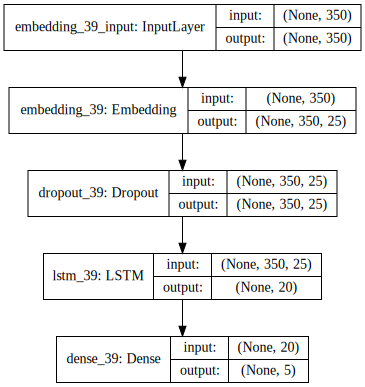

In [ ]:
model_13.summary()
if COLAB:
    display(SVG(model_to_dot(model_13,show_shapes=True,dpi=72).create(prog='dot', format='svg')))
else:
    display(SVG(model_to_dot(model_13,show_shapes=True).create(prog='dot', format='svg')))

#### **Reservamos, dentro del conjunto de *training*, un subconjunto de validación**

In [ ]:
# Entreno sobre X_tr,y_tr monitorizo el aprendizaje sobre X_va,y_va
X_tr, X_va, y_tr, y_va = train_test_split(X_train_pad, y_train, test_size=0.3, random_state=1)
print(X_tr.shape, len(y_tr))
print(X_va.shape, len(y_va))

(2450, 350) 2450
(1050, 350) 1050


#### **Entrenamiento del modelo**

In [ ]:
batch_size = 512
nepocas = 100

best_val_acc  = 0
best_val_loss = 1e20
best_i        = 0

best_weights = []
acum_tr_acc = []
acum_tr_loss = []
acum_val_acc = []
acum_val_loss = []

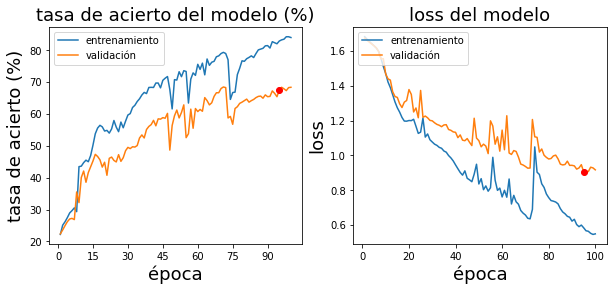

In [ ]:
for e in range(nepocas):
  h = model_13.fit(X_tr, y_tr,
                batch_size=batch_size,
                validation_data=(X_va, y_va),
                epochs=1, verbose=1)
  
  acum_tr_acc  = acum_tr_acc  + h.history['accuracy']
  acum_tr_loss = acum_tr_loss + h.history['loss']
  val_acc  = h.history['val_accuracy'][0]
  val_loss = h.history['val_loss'][0]
  acum_val_acc  = acum_val_acc  + [val_acc]
  acum_val_loss = acum_val_loss + [val_loss]
#  if val_acc  > best_val_acc:
  if val_loss < best_val_loss:
    best_i        = len(acum_val_acc)-1
    best_val_acc  = val_acc
    best_val_loss = val_loss
    best_weights = model_13.get_weights().copy()
  if len(acum_tr_acc)>1 and (len(acum_tr_acc)+1) % 1 == 0:
    if e>1:
      clear_output()
    grafica_entrenamiento(acum_tr_acc, acum_val_acc, acum_tr_loss, acum_val_loss, best_i)

In [ ]:
model_13.set_weights(best_weights)

In [ ]:
scores = model_13.evaluate(X_test_pad, y_test, verbose=1)
print("Accuracy in test: %.2f%%" % (scores[1]*100))

1500/1500 [==============================] - 1s 789us/step
Accuracy in test: 69.87%


### **13.4: Análisis del *embedding***

In [ ]:
def most_similar_words(embedding,word,n=10):
  n_latent_dimensions = np.shape(embedding)[1]
  ind = word2int[word]
  aux = np.reshape(embedding[ind,:], (1,n_latent_dimensions))
  dists = pairwise_distances(aux, embedding).flatten()
  inds = dists.argsort().tolist()
  inds.remove(ind)
  return [int2word[i] for i in inds[:n]]

embedding = model_13.get_weights()[0]
embedding.shape

(2500, 25)

In [ ]:
most_similar_words(embedding,'alzheimer')

['abeta',
 'amyloid',
 'ad',
 'ache',
 'dementia',
 'tau',
 'dlb',
 'apoe',
 'brain',
 'neurological']

In [ ]:
most_similar_words(embedding,'bladder')

['urothelial',
 'bca',
 'malignancies',
 'urinary',
 'cystectomy',
 'uca1',
 'radical',
 'genitourinary',
 'muscle',
 'adenocarcinoma']

In [ ]:
most_similar_words(embedding,'breast')

['tnbc',
 'trastuzumab',
 'mcf',
 'targeted',
 'preliminary',
 'her2',
 'metastatic',
 'cytotoxic',
 'mammary',
 'biopsy']

In [ ]:
most_similar_words(embedding,'cervical')

['hpv',
 'cin',
 'cervix',
 'malignancies',
 'hela',
 'pap',
 'cc',
 'carcinoma',
 'adenocarcinoma',
 'screening']

In [ ]:
most_similar_words(embedding,'negative')

['satisfaction',
 'food',
 'hif',
 'g2',
 'identifying',
 'seen',
 'triple',
 'markedly',
 'successful',
 'examinations']

## **14. Experimento 14**

A continuación, para este experimento y los sucesivos, vamos a indicar los valores utilizados para los hiperparámetros. En este caso, son los siguientes:

**VALORES QUE SE USARÁN PARA LOS HIPERPARÁMETROS**:


*   **top_words** = 2500
*   **max_review_length** = 350
*   **embedding_vector_length** = 50
*   **n_neurons** = 40
*   **l** = 0.00005
*   **Dropout**(rate = 0.1)



En este caso, hemos mantenido los valores de *embedding_vector_length*, de *n_neurons* y *l* en los valores que han proporcionado un *accuracy* más alto, el del experimento 12, en vista de que bajar sus valores no mejora el grado de separación entre las gráficas de entrenamiento y validación. Mientras tanto, hemos reducido la introducción de ruido (*Dropout*) hasta un *rate* del 0.1.

### **14.1: Determinación de las palabras más frecuentes**

In [ ]:
top_words = 2500 # HYPERPARAMETER, VOCABULARY SIZE

tk = Tokenizer(oov_token='(oov)', num_words=(top_words-1))
tk.fit_on_texts(data_train["text"])

In [ ]:
X_train  = [np.array([0] + x)+1 for x in tk.texts_to_sequences(data_train["text"])]
X_test   = [np.array([0] + x)+1 for x in tk.texts_to_sequences(data_test["text"])]

In [ ]:
X_train[0]

array([   1,    2,    2,   27,  490,   23,  869,    8,  197,    4, 2364,
          2,    2,    2,    2,    9,   30,    2, 2279,    2,    5,  836,
        809,  555,   53,    9,    3,  762,    8,  787,  166,  386, 1310,
          9,    8,  508,    4,    2, 1396,  230,   39,   13,  159,    9,
          2,  543, 2016,    9,  700,    2,    2,  424,    5,  621,    2,
          2, 2401, 1325,   11,  101,    7,   43,   30,    2,    2,    5,
        251, 1616,    2,    2,    9,    8, 2402, 2279,    9, 1953,    4,
       1415,  354, 1325,    2,   20,  166, 1299,    9, 2279,    2,    2,
          2,   18,  214,    2,    2,  424,    2,    8,    2,    2,    2,
       1325,  540,    2,   65,  155, 1299,    9,  187,  189,    4,    2,
        391,    4,    3, 2279,    2,  162,    3,   44,  444,    4,    8,
        480,  397,    4, 1047, 1247,   13, 2403,   11,   51,    2,    5,
       1325,  251,  701,  269, 2049,    2,   27,    8,  490, 1326,   87,
         62,   28,  159, 1483,    9,    2, 2279,   

In [ ]:
min([x.min() for x in X_train]), max([x.max() for x in X_train]), min([x.min() for x in X_test]), max([x.max() for x in X_test])

(1, 2499, 1, 2499)

In [ ]:
int2word = {(i+1):tk.index_word[i] for i in range(1,top_words-1)} # el 0 no está incluido, se reserva para padding
int2word[0] = "(padding)"
int2word[1] = "(start)"

word2int = {int2word[i]:i for i in range(top_words)}

In [ ]:
int2word[0], int2word[1], int2word[2], int2word[max([x.max() for x in X_train])], word2int["the"] #, word2int["whoopi"]

('(padding)', '(start)', '(oov)', 'experiment', 3)

20 palabras más frecuentes:

In [ ]:
for i in range(20):
    print(i, int2word[i])

0 (padding)
1 (start)
2 (oov)
3 the
4 of
5 and
6 in
7 to
8 a
9 with
10 for
11 was
12 were
13 cancer
14 is
15 patients
16 that
17 0
18 as
19 by


In [ ]:
ejemplo = 1

print(X_train[ejemplo], "\n") #Array con los índices asociados a cada palabra del texto.
print("\033[1m"+"Índices y sus palabras asociadas:")
for i,x in enumerate(X_train[ejemplo][:50]):
  print("{} -> {}".format(x, int2word[x])) #Se muestra el índice junto con su palabra asociada.
if (i+1)<len(X_train[ejemplo]): 
  print("...")
print("Class: {}".format(y_train[ejemplo])) 

[   1    3   90   44   13  487    2   14  457    2 1450  723   10    3
  358  311    5 1554  114    3  157  275    4   78   45    2   14    7
    2    2   38    5  782    4  487   15  328  936  363   89  230   18
  124   18  132  230  264    2    3 1641    4    3 1901    4 1379   14
    3    2  165    3    2    6    3    2  763   14    3    2    4    2
    4    2   10  358    5  520  148  114    3  139  151  847  349   28
 1248   21    3    2  328  264   10    3  358  114    4  487  440    2
    4   47 2280 2129    2   47   53    2    2    2   44   47 1249    2
   10    3  176  487  114] 

Índices y sus palabras asociadas:
1 -> (start)
3 -> the
90 -> human
44 -> bladder
13 -> cancer
487 -> bc
2 -> (oov)
14 -> is
457 -> being
2 -> (oov)
1450 -> every
723 -> day
10 -> for
3 -> the
358 -> better
311 -> management
5 -> and
1554 -> efficient
114 -> diagnosis
3 -> the
157 -> primary
275 -> aim
4 -> of
78 -> all
45 -> these
2 -> (oov)
14 -> is
7 -> to
2 -> (oov)
2 -> (oov)
38 -> treatment
5 -

### **14.2: *Padding* de las palabras**

In [ ]:
max_review_length = 350 # HYPERPARAMETER
X_train_pad = sequence.pad_sequences(X_train, maxlen=max_review_length)
X_test_pad = sequence.pad_sequences(X_test, maxlen=max_review_length)
int2word[0] = "(padding)"

print("Tamaño del dataset de training después del padding:", X_train_pad.shape)
print("Los códigos de palabras van de {} a {}".format(X_train_pad.min(), X_train_pad.max()))

Tamaño del dataset de training después del padding: (3500, 350)
Los códigos de palabras van de 0 a 2499


In [ ]:
data_train["text"][1369]

'ureteroarterial fistulas are rare we describe a case of ureteral-arterial fistulas uaf repaired with an endovascular stent graft and examine late complications associated with the procedure a 37-year-old woman with a history of complicated locally invasive cervical cancer treated with chemoradiation presented initially with right leg rest pain and chronic intermittent gross hematuria she was found to have an ureteroarterial fistula and underwent successful endovascular exclusion with a covered stent with resolution of her symptoms she returned 1 year later with stent-graft thrombosis manifesting as lower extremity rest pain requiring a femoral-femoral bypass she then returned 6 months later with imaging evidence of extravascular migration of the stent graft into the bladder because of a poor prognosis of recurrent gynecologic cancer extraction was not attempted and she underwent complete urinary diversion uafs are a rare occurrence but may be treated successfully with endovascular ste

In [ ]:
X_train_pad[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

### **14.3: Construcción de la red neuronal (LSTM)**

In [ ]:
# HYPERPARAMETERS: ***
embedding_vector_length = 50 # HYPERPARAMETER
N_NEURONS = 40
# ********************


N_CLASSES = 5

rnn = LSTM
model_14 = Sequential()
model_14.add(Embedding(top_words, # número de palabras del vocabulario incluido 0 de padding
                    embedding_vector_length, # número de dimensiones que quieres que tenga el embedding
                    # l: "fuerza" del regularizador. Cuanto máás alto, más regulariza (pone a 0 componentes)
                    embeddings_regularizer=regularizers.l1(l=0.00005), # regularización (intenta poner a cero componentes)
                    input_length=max_review_length)) # tamaño de la secuencia de palabras
model_14.add(Dropout(rate=0.1))
model_14.add(rnn(N_NEURONS)) # MANY TO ONE (return_sequences no es True)
model_14.add(Dense(N_CLASSES, activation='softmax'))
model_14.compile(loss='sparse_categorical_crossentropy', # binarycrossentropy porque hay 2 clases, si hay más, categorical_crossentropy
              optimizer=Adam(lr=0.001), # lr: velocidad de aprendizaje
              metrics=['accuracy'])

Model: "sequential_40"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_40 (Embedding)     (None, 350, 50)           125000    
_________________________________________________________________
dropout_40 (Dropout)         (None, 350, 50)           0         
_________________________________________________________________
lstm_40 (LSTM)               (None, 40)                14560     
_________________________________________________________________
dense_40 (Dense)             (None, 5)                 205       
Total params: 139,765
Trainable params: 139,765
Non-trainable params: 0
_________________________________________________________________


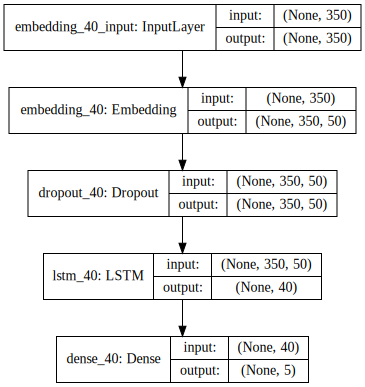

In [ ]:
model_14.summary()
if COLAB:
    display(SVG(model_to_dot(model_14,show_shapes=True,dpi=72).create(prog='dot', format='svg')))
else:
    display(SVG(model_to_dot(model_14,show_shapes=True).create(prog='dot', format='svg')))

#### **Reservamos, dentro del conjunto de *training*, un subconjunto de validación**

In [ ]:
# Entreno sobre X_tr,y_tr monitorizo el aprendizaje sobre X_va,y_va
X_tr, X_va, y_tr, y_va = train_test_split(X_train_pad, y_train, test_size=0.3, random_state=1)
print(X_tr.shape, len(y_tr))
print(X_va.shape, len(y_va))

(2450, 350) 2450
(1050, 350) 1050


#### **Entrenamiento del modelo**

In [ ]:
batch_size = 512
nepocas = 100

best_val_acc  = 0
best_val_loss = 1e20
best_i        = 0

best_weights = []
acum_tr_acc = []
acum_tr_loss = []
acum_val_acc = []
acum_val_loss = []

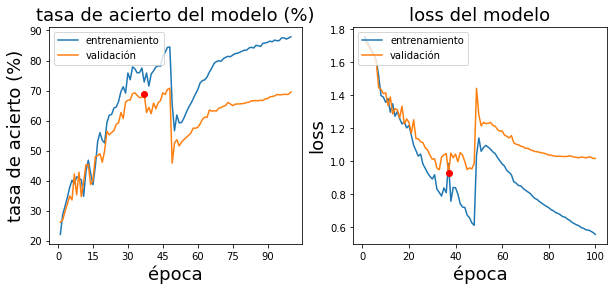

In [ ]:
for e in range(nepocas):
  h = model_14.fit(X_tr, y_tr,
                batch_size=batch_size,
                validation_data=(X_va, y_va),
                epochs=1, verbose=1)
  
  acum_tr_acc  = acum_tr_acc  + h.history['accuracy']
  acum_tr_loss = acum_tr_loss + h.history['loss']
  val_acc  = h.history['val_accuracy'][0]
  val_loss = h.history['val_loss'][0]
  acum_val_acc  = acum_val_acc  + [val_acc]
  acum_val_loss = acum_val_loss + [val_loss]
#  if val_acc  > best_val_acc:
  if val_loss < best_val_loss:
    best_i        = len(acum_val_acc)-1
    best_val_acc  = val_acc
    best_val_loss = val_loss
    best_weights = model_14.get_weights().copy()
  if len(acum_tr_acc)>1 and (len(acum_tr_acc)+1) % 1 == 0:
    if e>1:
      clear_output()
    grafica_entrenamiento(acum_tr_acc, acum_val_acc, acum_tr_loss, acum_val_loss, best_i)

In [ ]:
model_14.set_weights(best_weights)

In [ ]:
scores = model_14.evaluate(X_test_pad, y_test, verbose=1)
print("Accuracy in test: %.2f%%" % (scores[1]*100))

1500/1500 [==============================] - 2s 1ms/step
Accuracy in test: 67.40%


### **14.4: Análisis del *embedding***

In [ ]:
def most_similar_words(embedding,word,n=10):
  n_latent_dimensions = np.shape(embedding)[1]
  ind = word2int[word]
  aux = np.reshape(embedding[ind,:], (1,n_latent_dimensions))
  dists = pairwise_distances(aux, embedding).flatten()
  inds = dists.argsort().tolist()
  inds.remove(ind)
  return [int2word[i] for i in inds[:n]]

embedding = model_14.get_weights()[0]
embedding.shape

(2500, 50)

In [ ]:
most_similar_words(embedding,'alzheimer')

['ache',
 "'s",
 'dementia',
 'disease',
 'neurological',
 'ad',
 'diseases',
 'abeta',
 'memory',
 'datasets']

In [ ]:
most_similar_words(embedding,'bladder')

['urothelial',
 'bca',
 'cystectomy',
 'radical',
 'prostate',
 'urinary',
 'radiotherapy',
 'uca1',
 'rectum',
 'cytology']

In [ ]:
most_similar_words(embedding,'breast')

['tnbc',
 'mri',
 'luminal',
 'targeted',
 'population',
 'therapeutic',
 'metastasis',
 'malignancy',
 'reconstruction',
 'prognosis']

In [ ]:
most_similar_words(embedding,'cervical')

['hpv',
 'carcinoma',
 'cervix',
 'hela',
 'screening',
 'cc',
 'cytology',
 'vaccine',
 'cancers',
 'pap']

In [ ]:
most_similar_words(embedding,'negative')

['tissues',
 'functions',
 'progesterone',
 'prediction',
 'pattern',
 'clinicaltrials',
 'subtypes',
 'basis',
 'composition',
 'recommendations']

## **15. Experimento 15**

A continuación, para este experimento y los sucesivos, vamos a indicar los valores utilizados para los hiperparámetros. En este caso, son los siguientes:

**VALORES QUE SE USARÁN PARA LOS HIPERPARÁMETROS**:


*   **top_words** = 2500
*   **max_review_length** = 350
*   **embedding_vector_length** = 50
*   **n_neurons** = 40
*   **l** = 0.00005
*   **Dropout**(rate = 0.5)



En este caso, hemos mantenido los valores de *embedding_vector_length*, de *n_neurons* y *l* en los valores que han proporcionado un *accuracy* más alto, el del experimento 12. Mientras tanto, hemos aumentado la introducción de ruido (*Dropout*) hasta un *rate* del 0.5.

### **15.1: Determinación de las palabras más frecuentes**

In [ ]:
top_words = 2500 # HYPERPARAMETER, VOCABULARY SIZE

tk = Tokenizer(oov_token='(oov)', num_words=(top_words-1))
tk.fit_on_texts(data_train["text"])

In [ ]:
X_train  = [np.array([0] + x)+1 for x in tk.texts_to_sequences(data_train["text"])]
X_test   = [np.array([0] + x)+1 for x in tk.texts_to_sequences(data_test["text"])]

In [ ]:
X_train[0]

array([   1,    2,    2,   27,  490,   23,  869,    8,  197,    4, 2364,
          2,    2,    2,    2,    9,   30,    2, 2279,    2,    5,  836,
        809,  555,   53,    9,    3,  762,    8,  787,  166,  386, 1310,
          9,    8,  508,    4,    2, 1396,  230,   39,   13,  159,    9,
          2,  543, 2016,    9,  700,    2,    2,  424,    5,  621,    2,
          2, 2401, 1325,   11,  101,    7,   43,   30,    2,    2,    5,
        251, 1616,    2,    2,    9,    8, 2402, 2279,    9, 1953,    4,
       1415,  354, 1325,    2,   20,  166, 1299,    9, 2279,    2,    2,
          2,   18,  214,    2,    2,  424,    2,    8,    2,    2,    2,
       1325,  540,    2,   65,  155, 1299,    9,  187,  189,    4,    2,
        391,    4,    3, 2279,    2,  162,    3,   44,  444,    4,    8,
        480,  397,    4, 1047, 1247,   13, 2403,   11,   51,    2,    5,
       1325,  251,  701,  269, 2049,    2,   27,    8,  490, 1326,   87,
         62,   28,  159, 1483,    9,    2, 2279,   

In [ ]:
min([x.min() for x in X_train]), max([x.max() for x in X_train]), min([x.min() for x in X_test]), max([x.max() for x in X_test])

(1, 2499, 1, 2499)

In [ ]:
int2word = {(i+1):tk.index_word[i] for i in range(1,top_words-1)} # el 0 no está incluido, se reserva para padding
int2word[0] = "(padding)"
int2word[1] = "(start)"

word2int = {int2word[i]:i for i in range(top_words)}

In [ ]:
int2word[0], int2word[1], int2word[2], int2word[max([x.max() for x in X_train])], word2int["the"] #, word2int["whoopi"]

('(padding)', '(start)', '(oov)', 'experiment', 3)

20 palabras más frecuentes:

In [ ]:
for i in range(20):
    print(i, int2word[i])

0 (padding)
1 (start)
2 (oov)
3 the
4 of
5 and
6 in
7 to
8 a
9 with
10 for
11 was
12 were
13 cancer
14 is
15 patients
16 that
17 0
18 as
19 by


In [ ]:
ejemplo = 1

print(X_train[ejemplo], "\n") #Array con los índices asociados a cada palabra del texto.
print("\033[1m"+"Índices y sus palabras asociadas:")
for i,x in enumerate(X_train[ejemplo][:50]):
  print("{} -> {}".format(x, int2word[x])) #Se muestra el índice junto con su palabra asociada.
if (i+1)<len(X_train[ejemplo]): 
  print("...")
print("Class: {}".format(y_train[ejemplo])) 

[   1    3   90   44   13  487    2   14  457    2 1450  723   10    3
  358  311    5 1554  114    3  157  275    4   78   45    2   14    7
    2    2   38    5  782    4  487   15  328  936  363   89  230   18
  124   18  132  230  264    2    3 1641    4    3 1901    4 1379   14
    3    2  165    3    2    6    3    2  763   14    3    2    4    2
    4    2   10  358    5  520  148  114    3  139  151  847  349   28
 1248   21    3    2  328  264   10    3  358  114    4  487  440    2
    4   47 2280 2129    2   47   53    2    2    2   44   47 1249    2
   10    3  176  487  114] 

Índices y sus palabras asociadas:
1 -> (start)
3 -> the
90 -> human
44 -> bladder
13 -> cancer
487 -> bc
2 -> (oov)
14 -> is
457 -> being
2 -> (oov)
1450 -> every
723 -> day
10 -> for
3 -> the
358 -> better
311 -> management
5 -> and
1554 -> efficient
114 -> diagnosis
3 -> the
157 -> primary
275 -> aim
4 -> of
78 -> all
45 -> these
2 -> (oov)
14 -> is
7 -> to
2 -> (oov)
2 -> (oov)
38 -> treatment
5 -

### **15.2: *Padding* de las palabras**

In [ ]:
max_review_length = 350 # HYPERPARAMETER
X_train_pad = sequence.pad_sequences(X_train, maxlen=max_review_length)
X_test_pad = sequence.pad_sequences(X_test, maxlen=max_review_length)
int2word[0] = "(padding)"

print("Tamaño del dataset de training después del padding:", X_train_pad.shape)
print("Los códigos de palabras van de {} a {}".format(X_train_pad.min(), X_train_pad.max()))

Tamaño del dataset de training después del padding: (3500, 350)
Los códigos de palabras van de 0 a 2499


In [ ]:
data_train["text"][1369]

'ureteroarterial fistulas are rare we describe a case of ureteral-arterial fistulas uaf repaired with an endovascular stent graft and examine late complications associated with the procedure a 37-year-old woman with a history of complicated locally invasive cervical cancer treated with chemoradiation presented initially with right leg rest pain and chronic intermittent gross hematuria she was found to have an ureteroarterial fistula and underwent successful endovascular exclusion with a covered stent with resolution of her symptoms she returned 1 year later with stent-graft thrombosis manifesting as lower extremity rest pain requiring a femoral-femoral bypass she then returned 6 months later with imaging evidence of extravascular migration of the stent graft into the bladder because of a poor prognosis of recurrent gynecologic cancer extraction was not attempted and she underwent complete urinary diversion uafs are a rare occurrence but may be treated successfully with endovascular ste

In [ ]:
X_train_pad[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

### **15.3: Construcción de la red neuronal (LSTM)**

In [ ]:
# HYPERPARAMETERS: ***
embedding_vector_length = 50 # HYPERPARAMETER
N_NEURONS = 40
# ********************


N_CLASSES = 5

rnn = LSTM
model_15 = Sequential()
model_15.add(Embedding(top_words, # número de palabras del vocabulario incluido 0 de padding
                    embedding_vector_length, # número de dimensiones que quieres que tenga el embedding
                    # l: "fuerza" del regularizador. Cuanto máás alto, más regulariza (pone a 0 componentes)
                    embeddings_regularizer=regularizers.l1(l=0.00005), # regularización (intenta poner a cero componentes)
                    input_length=max_review_length)) # tamaño de la secuencia de palabras
model_15.add(Dropout(rate=0.5))
model_15.add(rnn(N_NEURONS)) # MANY TO ONE (return_sequences no es True)
model_15.add(Dense(N_CLASSES, activation='softmax'))
model_15.compile(loss='sparse_categorical_crossentropy', # binarycrossentropy porque hay 2 clases, si hay más, categorical_crossentropy
              optimizer=Adam(lr=0.001), # lr: velocidad de aprendizaje
              metrics=['accuracy'])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 350, 50)           125000    
_________________________________________________________________
dropout_1 (Dropout)          (None, 350, 50)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 40)                14560     
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 205       
Total params: 139,765
Trainable params: 139,765
Non-trainable params: 0
_________________________________________________________________


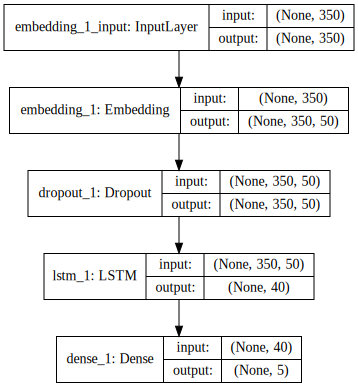

In [ ]:
model_15.summary()
if COLAB:
    display(SVG(model_to_dot(model_15,show_shapes=True,dpi=72).create(prog='dot', format='svg')))
else:
    display(SVG(model_to_dot(model_15,show_shapes=True).create(prog='dot', format='svg')))

#### **Reservamos, dentro del conjunto de *training*, un subconjunto de validación**

In [ ]:
# Entreno sobre X_tr,y_tr monitorizo el aprendizaje sobre X_va,y_va
X_tr, X_va, y_tr, y_va = train_test_split(X_train_pad, y_train, test_size=0.3, random_state=1)
print(X_tr.shape, len(y_tr))
print(X_va.shape, len(y_va))

(2450, 350) 2450
(1050, 350) 1050


#### **Entrenamiento del modelo**

In [ ]:
batch_size = 512
nepocas = 100

best_val_acc  = 0
best_val_loss = 1e20
best_i        = 0

best_weights = []
acum_tr_acc = []
acum_tr_loss = []
acum_val_acc = []
acum_val_loss = []

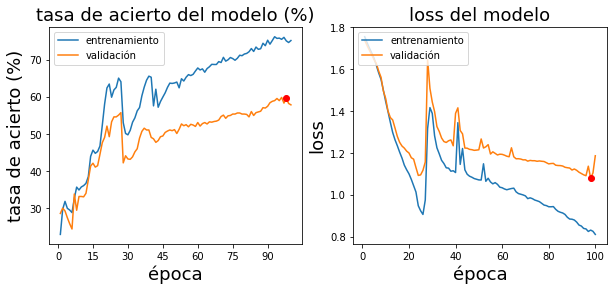

In [ ]:
for e in range(nepocas):
  h = model_15.fit(X_tr, y_tr,
                batch_size=batch_size,
                validation_data=(X_va, y_va),
                epochs=1, verbose=1)
  
  acum_tr_acc  = acum_tr_acc  + h.history['accuracy']
  acum_tr_loss = acum_tr_loss + h.history['loss']
  val_acc  = h.history['val_accuracy'][0]
  val_loss = h.history['val_loss'][0]
  acum_val_acc  = acum_val_acc  + [val_acc]
  acum_val_loss = acum_val_loss + [val_loss]
#  if val_acc  > best_val_acc:
  if val_loss < best_val_loss:
    best_i        = len(acum_val_acc)-1
    best_val_acc  = val_acc
    best_val_loss = val_loss
    best_weights = model_15.get_weights().copy()
  if len(acum_tr_acc)>1 and (len(acum_tr_acc)+1) % 1 == 0:
    if e>1:
      clear_output()
    grafica_entrenamiento(acum_tr_acc, acum_val_acc, acum_tr_loss, acum_val_loss, best_i)

In [ ]:
model_15.set_weights(best_weights)

In [ ]:
scores = model_15.evaluate(X_test_pad, y_test, verbose=1)
print("Accuracy in test: %.2f%%" % (scores[1]*100))

1500/1500 [==============================] - 2s 1ms/step
Accuracy in test: 60.27%


### **15.4: Análisis del *embedding***

In [ ]:
def most_similar_words(embedding,word,n=10):
  n_latent_dimensions = np.shape(embedding)[1]
  ind = word2int[word]
  aux = np.reshape(embedding[ind,:], (1,n_latent_dimensions))
  dists = pairwise_distances(aux, embedding).flatten()
  inds = dists.argsort().tolist()
  inds.remove(ind)
  return [int2word[i] for i in inds[:n]]

embedding = model_15.get_weights()[0]
embedding.shape

(2500, 50)

In [ ]:
most_similar_words(embedding,'alzheimer')

['dementia',
 'abeta',
 'ad',
 "'s",
 'amyloid',
 'disease',
 'ache',
 'brain',
 'neurological',
 'aggregation']

In [ ]:
most_similar_words(embedding,'bladder')

['bca',
 'urothelial',
 'cystectomy',
 '2016',
 'hela',
 'prostate',
 'utuc',
 'uca1',
 'endometrial',
 'bc']

In [ ]:
most_similar_words(embedding,'breast')

['tnbc',
 'targeted',
 'cancer',
 'metastatic',
 'cytotoxic',
 'mri',
 'mcf',
 'mutations',
 'chemotherapy',
 'her2']

In [ ]:
most_similar_words(embedding,'cervical')

['hpv',
 'hela',
 'cc',
 'carcinoma',
 'pap',
 'urothelial',
 '2016',
 'endometrial',
 'uca1',
 'cytology']

In [ ]:
most_similar_words(embedding,'negative')

['characterization',
 'skin',
 'status',
 'trastuzumab',
 'apoptosis',
 'mastectomy',
 'combination',
 'observational',
 'general',
 'nodal']

## **16. Experimento 16**

A continuación, para este experimento y los sucesivos, vamos a indicar los valores utilizados para los hiperparámetros. En este caso, son los siguientes:

**VALORES QUE SE USARÁN PARA LOS HIPERPARÁMETROS**:


*   **top_words** = 2500
*   **max_review_length** = 350
*   **embedding_vector_length** = 50
*   **n_neurons** = 40
*   **l** = 0.00005 (regularizador L2)
*   **Dropout**(rate = 0.3)



En este caso, hemos mantenido los valores de los parámetros que, hasta ahora, han dado lugar a los mejores resultados. En este experimento, el cambio va a ser que, en lugar de aplicar una penalización de regularización L1, ésta va a ser L2.

### **16.1: Determinación de las palabras más frecuentes**

In [ ]:
top_words = 2500 # HYPERPARAMETER, VOCABULARY SIZE

tk = Tokenizer(oov_token='(oov)', num_words=(top_words-1))
tk.fit_on_texts(data_train["text"])

In [ ]:
X_train  = [np.array([0] + x)+1 for x in tk.texts_to_sequences(data_train["text"])]
X_test   = [np.array([0] + x)+1 for x in tk.texts_to_sequences(data_test["text"])]

In [ ]:
X_train[0]

array([   1,    2,    2,   27,  490,   23,  869,    8,  197,    4, 2364,
          2,    2,    2,    2,    9,   30,    2, 2279,    2,    5,  836,
        809,  555,   53,    9,    3,  762,    8,  787,  166,  386, 1310,
          9,    8,  508,    4,    2, 1396,  230,   39,   13,  159,    9,
          2,  543, 2016,    9,  700,    2,    2,  424,    5,  621,    2,
          2, 2401, 1325,   11,  101,    7,   43,   30,    2,    2,    5,
        251, 1616,    2,    2,    9,    8, 2402, 2279,    9, 1953,    4,
       1415,  354, 1325,    2,   20,  166, 1299,    9, 2279,    2,    2,
          2,   18,  214,    2,    2,  424,    2,    8,    2,    2,    2,
       1325,  540,    2,   65,  155, 1299,    9,  187,  189,    4,    2,
        391,    4,    3, 2279,    2,  162,    3,   44,  444,    4,    8,
        480,  397,    4, 1047, 1247,   13, 2403,   11,   51,    2,    5,
       1325,  251,  701,  269, 2049,    2,   27,    8,  490, 1326,   87,
         62,   28,  159, 1483,    9,    2, 2279,   

In [ ]:
min([x.min() for x in X_train]), max([x.max() for x in X_train]), min([x.min() for x in X_test]), max([x.max() for x in X_test])

(1, 2499, 1, 2499)

In [ ]:
int2word = {(i+1):tk.index_word[i] for i in range(1,top_words-1)} # el 0 no está incluido, se reserva para padding
int2word[0] = "(padding)"
int2word[1] = "(start)"

word2int = {int2word[i]:i for i in range(top_words)}

In [ ]:
int2word[0], int2word[1], int2word[2], int2word[max([x.max() for x in X_train])], word2int["the"] #, word2int["whoopi"]

('(padding)', '(start)', '(oov)', 'experiment', 3)

20 palabras más frecuentes:

In [ ]:
for i in range(20):
    print(i, int2word[i])

0 (padding)
1 (start)
2 (oov)
3 the
4 of
5 and
6 in
7 to
8 a
9 with
10 for
11 was
12 were
13 cancer
14 is
15 patients
16 that
17 0
18 as
19 by


In [ ]:
ejemplo = 1

print(X_train[ejemplo], "\n") #Array con los índices asociados a cada palabra del texto.
print("\033[1m"+"Índices y sus palabras asociadas:")
for i,x in enumerate(X_train[ejemplo][:50]):
  print("{} -> {}".format(x, int2word[x])) #Se muestra el índice junto con su palabra asociada.
if (i+1)<len(X_train[ejemplo]): 
  print("...")
print("Class: {}".format(y_train[ejemplo])) 

[   1    3   90   44   13  487    2   14  457    2 1450  723   10    3
  358  311    5 1554  114    3  157  275    4   78   45    2   14    7
    2    2   38    5  782    4  487   15  328  936  363   89  230   18
  124   18  132  230  264    2    3 1641    4    3 1901    4 1379   14
    3    2  165    3    2    6    3    2  763   14    3    2    4    2
    4    2   10  358    5  520  148  114    3  139  151  847  349   28
 1248   21    3    2  328  264   10    3  358  114    4  487  440    2
    4   47 2280 2129    2   47   53    2    2    2   44   47 1249    2
   10    3  176  487  114] 

Índices y sus palabras asociadas:
1 -> (start)
3 -> the
90 -> human
44 -> bladder
13 -> cancer
487 -> bc
2 -> (oov)
14 -> is
457 -> being
2 -> (oov)
1450 -> every
723 -> day
10 -> for
3 -> the
358 -> better
311 -> management
5 -> and
1554 -> efficient
114 -> diagnosis
3 -> the
157 -> primary
275 -> aim
4 -> of
78 -> all
45 -> these
2 -> (oov)
14 -> is
7 -> to
2 -> (oov)
2 -> (oov)
38 -> treatment
5 -

### **16.2: *Padding* de las palabras**

In [ ]:
max_review_length = 350 # HYPERPARAMETER
X_train_pad = sequence.pad_sequences(X_train, maxlen=max_review_length)
X_test_pad = sequence.pad_sequences(X_test, maxlen=max_review_length)
int2word[0] = "(padding)"

print("Tamaño del dataset de training después del padding:", X_train_pad.shape)
print("Los códigos de palabras van de {} a {}".format(X_train_pad.min(), X_train_pad.max()))

Tamaño del dataset de training después del padding: (3500, 350)
Los códigos de palabras van de 0 a 2499


In [ ]:
data_train["text"][1369]

'ureteroarterial fistulas are rare we describe a case of ureteral-arterial fistulas uaf repaired with an endovascular stent graft and examine late complications associated with the procedure a 37-year-old woman with a history of complicated locally invasive cervical cancer treated with chemoradiation presented initially with right leg rest pain and chronic intermittent gross hematuria she was found to have an ureteroarterial fistula and underwent successful endovascular exclusion with a covered stent with resolution of her symptoms she returned 1 year later with stent-graft thrombosis manifesting as lower extremity rest pain requiring a femoral-femoral bypass she then returned 6 months later with imaging evidence of extravascular migration of the stent graft into the bladder because of a poor prognosis of recurrent gynecologic cancer extraction was not attempted and she underwent complete urinary diversion uafs are a rare occurrence but may be treated successfully with endovascular ste

In [ ]:
X_train_pad[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

### **16.3: Construcción de la red neuronal (LSTM)**

In [ ]:
# HYPERPARAMETERS: ***
embedding_vector_length = 50 # HYPERPARAMETER
N_NEURONS = 40
# ********************


N_CLASSES = 5

rnn = LSTM
model_16 = Sequential()
model_16.add(Embedding(top_words, # número de palabras del vocabulario incluido 0 de padding
                    embedding_vector_length, # número de dimensiones que quieres que tenga el embedding
                    # l: "fuerza" del regularizador. Cuanto máás alto, más regulariza (pone a 0 componentes)
                    embeddings_regularizer=regularizers.l2(l=0.00005), # regularización (intenta poner a cero componentes)
                    input_length=max_review_length)) # tamaño de la secuencia de palabras
model_16.add(Dropout(rate=0.3))
model_16.add(rnn(N_NEURONS)) # MANY TO ONE (return_sequences no es True)
model_16.add(Dense(N_CLASSES, activation='softmax'))
model_16.compile(loss='sparse_categorical_crossentropy', # binarycrossentropy porque hay 2 clases, si hay más, categorical_crossentropy
              optimizer=Adam(lr=0.001), # lr: velocidad de aprendizaje
              metrics=['accuracy'])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 350, 50)           125000    
_________________________________________________________________
dropout_2 (Dropout)          (None, 350, 50)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 40)                14560     
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 205       
Total params: 139,765
Trainable params: 139,765
Non-trainable params: 0
_________________________________________________________________


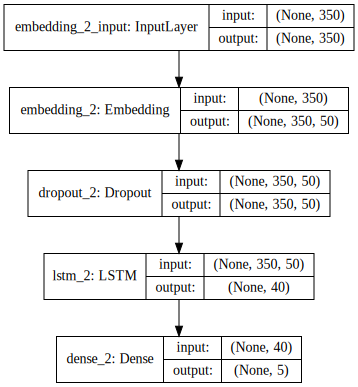

In [ ]:
model_16.summary()
if COLAB:
    display(SVG(model_to_dot(model_16,show_shapes=True,dpi=72).create(prog='dot', format='svg')))
else:
    display(SVG(model_to_dot(model_16,show_shapes=True).create(prog='dot', format='svg')))

#### **Reservamos, dentro del conjunto de *training*, un subconjunto de validación**

In [ ]:
# Entreno sobre X_tr,y_tr monitorizo el aprendizaje sobre X_va,y_va
X_tr, X_va, y_tr, y_va = train_test_split(X_train_pad, y_train, test_size=0.3, random_state=1)
print(X_tr.shape, len(y_tr))
print(X_va.shape, len(y_va))

(2450, 350) 2450
(1050, 350) 1050


#### **Entrenamiento del modelo**

In [ ]:
batch_size = 512
nepocas = 100

best_val_acc  = 0
best_val_loss = 1e20
best_i        = 0

best_weights = []
acum_tr_acc = []
acum_tr_loss = []
acum_val_acc = []
acum_val_loss = []

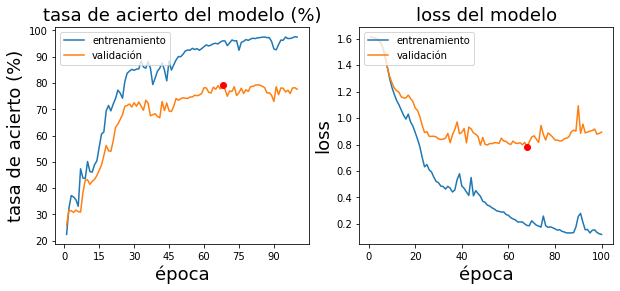

In [ ]:
for e in range(nepocas):
  h = model_16.fit(X_tr, y_tr,
                batch_size=batch_size,
                validation_data=(X_va, y_va),
                epochs=1, verbose=1)
  
  acum_tr_acc  = acum_tr_acc  + h.history['accuracy']
  acum_tr_loss = acum_tr_loss + h.history['loss']
  val_acc  = h.history['val_accuracy'][0]
  val_loss = h.history['val_loss'][0]
  acum_val_acc  = acum_val_acc  + [val_acc]
  acum_val_loss = acum_val_loss + [val_loss]
#  if val_acc  > best_val_acc:
  if val_loss < best_val_loss:
    best_i        = len(acum_val_acc)-1
    best_val_acc  = val_acc
    best_val_loss = val_loss
    best_weights = model_16.get_weights().copy()
  if len(acum_tr_acc)>1 and (len(acum_tr_acc)+1) % 1 == 0:
    if e>1:
      clear_output()
    grafica_entrenamiento(acum_tr_acc, acum_val_acc, acum_tr_loss, acum_val_loss, best_i)

In [ ]:
model_16.set_weights(best_weights)

In [ ]:
scores = model_16.evaluate(X_test_pad, y_test, verbose=1)
print("Accuracy in test: %.2f%%" % (scores[1]*100))

1500/1500 [==============================] - 2s 1ms/step
Accuracy in test: 78.40%


### **16.4: Análisis del *embedding***

In [ ]:
def most_similar_words(embedding,word,n=10):
  n_latent_dimensions = np.shape(embedding)[1]
  ind = word2int[word]
  aux = np.reshape(embedding[ind,:], (1,n_latent_dimensions))
  dists = pairwise_distances(aux, embedding).flatten()
  inds = dists.argsort().tolist()
  inds.remove(ind)
  return [int2word[i] for i in inds[:n]]

embedding = model_16.get_weights()[0]
embedding.shape

(2500, 50)

In [ ]:
most_similar_words(embedding,'alzheimer')

['dementia',
 'ad',
 'ache',
 'abeta',
 'substrate',
 'amyloid',
 'tau',
 'parkinson',
 'neurological',
 'memory']

In [ ]:
most_similar_words(embedding,'bladder')

['bca',
 'utuc',
 'cystectomy',
 'intravesical',
 'urothelial',
 'turbt',
 'prostate',
 'ureteral',
 'rc',
 'rectal']

In [ ]:
most_similar_words(embedding,'breast')

['tnbc',
 'mammary',
 'preliminary',
 'trastuzumab',
 'metastatic',
 'luminal',
 'silencing',
 'mastectomy',
 'mutations',
 'characterization']

In [ ]:
most_similar_words(embedding,'cervical')

['cin',
 'loop',
 'hpv16',
 'gynecological',
 'hpv',
 'hela',
 'cone',
 'cervix',
 'birth',
 'smear']

In [ ]:
most_similar_words(embedding,'negative')

['randomised',
 'nucleus',
 'oncological',
 'fixed',
 'chromatin',
 'spectrometry',
 'involved',
 'observational',
 'mdr',
 'families']

## **17. Experimento 17**

A continuación, vamos a indicar los valores utilizados para los hiperparámetros. En este caso, son los siguientes:

**VALORES QUE SE USARÁN PARA LOS HIPERPARÁMETROS**:


*   **top_words** = 2500
*   **max_review_length** = 350
*   **embedding_vector_length** = 50
*   **n_neurons** = 40
*   **l** = 0.00005 (regularizadores L1 y L2)
*   **Dropout**(rate = 0.3)



En este caso, hemos mantenido los valores de los parámetros que, hasta ahora, han dado lugar a los mejores resultados. En este experimento, el cambio va a ser que, en lugar de aplicar solo una penalización de regularización, vamos a aplicar tanto la L1 como la L2.

### **17.1: Determinación de las palabras más frecuentes**

In [ ]:
top_words = 2500 # HYPERPARAMETER, VOCABULARY SIZE

tk = Tokenizer(oov_token='(oov)', num_words=(top_words-1))
tk.fit_on_texts(data_train["text"])

In [ ]:
X_train  = [np.array([0] + x)+1 for x in tk.texts_to_sequences(data_train["text"])]
X_test   = [np.array([0] + x)+1 for x in tk.texts_to_sequences(data_test["text"])]

In [ ]:
X_train[0]

array([   1,    2,    2,   27,  490,   23,  869,    8,  197,    4, 2364,
          2,    2,    2,    2,    9,   30,    2, 2279,    2,    5,  836,
        809,  555,   53,    9,    3,  762,    8,  787,  166,  386, 1310,
          9,    8,  508,    4,    2, 1396,  230,   39,   13,  159,    9,
          2,  543, 2016,    9,  700,    2,    2,  424,    5,  621,    2,
          2, 2401, 1325,   11,  101,    7,   43,   30,    2,    2,    5,
        251, 1616,    2,    2,    9,    8, 2402, 2279,    9, 1953,    4,
       1415,  354, 1325,    2,   20,  166, 1299,    9, 2279,    2,    2,
          2,   18,  214,    2,    2,  424,    2,    8,    2,    2,    2,
       1325,  540,    2,   65,  155, 1299,    9,  187,  189,    4,    2,
        391,    4,    3, 2279,    2,  162,    3,   44,  444,    4,    8,
        480,  397,    4, 1047, 1247,   13, 2403,   11,   51,    2,    5,
       1325,  251,  701,  269, 2049,    2,   27,    8,  490, 1326,   87,
         62,   28,  159, 1483,    9,    2, 2279,   

In [ ]:
min([x.min() for x in X_train]), max([x.max() for x in X_train]), min([x.min() for x in X_test]), max([x.max() for x in X_test])

(1, 2499, 1, 2499)

In [ ]:
int2word = {(i+1):tk.index_word[i] for i in range(1,top_words-1)} # el 0 no está incluido, se reserva para padding
int2word[0] = "(padding)"
int2word[1] = "(start)"

word2int = {int2word[i]:i for i in range(top_words)}

In [ ]:
int2word[0], int2word[1], int2word[2], int2word[max([x.max() for x in X_train])], word2int["the"] #, word2int["whoopi"]

('(padding)', '(start)', '(oov)', 'experiment', 3)

20 palabras más frecuentes:

In [ ]:
for i in range(20):
    print(i, int2word[i])

0 (padding)
1 (start)
2 (oov)
3 the
4 of
5 and
6 in
7 to
8 a
9 with
10 for
11 was
12 were
13 cancer
14 is
15 patients
16 that
17 0
18 as
19 by


In [ ]:
ejemplo = 1

print(X_train[ejemplo], "\n") #Array con los índices asociados a cada palabra del texto.
print("\033[1m"+"Índices y sus palabras asociadas:")
for i,x in enumerate(X_train[ejemplo][:50]):
  print("{} -> {}".format(x, int2word[x])) #Se muestra el índice junto con su palabra asociada.
if (i+1)<len(X_train[ejemplo]): 
  print("...")
print("Class: {}".format(y_train[ejemplo])) 

[   1    3   90   44   13  487    2   14  457    2 1450  723   10    3
  358  311    5 1554  114    3  157  275    4   78   45    2   14    7
    2    2   38    5  782    4  487   15  328  936  363   89  230   18
  124   18  132  230  264    2    3 1641    4    3 1901    4 1379   14
    3    2  165    3    2    6    3    2  763   14    3    2    4    2
    4    2   10  358    5  520  148  114    3  139  151  847  349   28
 1248   21    3    2  328  264   10    3  358  114    4  487  440    2
    4   47 2280 2129    2   47   53    2    2    2   44   47 1249    2
   10    3  176  487  114] 

Índices y sus palabras asociadas:
1 -> (start)
3 -> the
90 -> human
44 -> bladder
13 -> cancer
487 -> bc
2 -> (oov)
14 -> is
457 -> being
2 -> (oov)
1450 -> every
723 -> day
10 -> for
3 -> the
358 -> better
311 -> management
5 -> and
1554 -> efficient
114 -> diagnosis
3 -> the
157 -> primary
275 -> aim
4 -> of
78 -> all
45 -> these
2 -> (oov)
14 -> is
7 -> to
2 -> (oov)
2 -> (oov)
38 -> treatment
5 -

### **17.2: *Padding* de las palabras**

In [ ]:
max_review_length = 350 # HYPERPARAMETER
X_train_pad = sequence.pad_sequences(X_train, maxlen=max_review_length)
X_test_pad = sequence.pad_sequences(X_test, maxlen=max_review_length)
int2word[0] = "(padding)"

print("Tamaño del dataset de training después del padding:", X_train_pad.shape)
print("Los códigos de palabras van de {} a {}".format(X_train_pad.min(), X_train_pad.max()))

Tamaño del dataset de training después del padding: (3500, 350)
Los códigos de palabras van de 0 a 2499


In [ ]:
data_train["text"][1369]

'ureteroarterial fistulas are rare we describe a case of ureteral-arterial fistulas uaf repaired with an endovascular stent graft and examine late complications associated with the procedure a 37-year-old woman with a history of complicated locally invasive cervical cancer treated with chemoradiation presented initially with right leg rest pain and chronic intermittent gross hematuria she was found to have an ureteroarterial fistula and underwent successful endovascular exclusion with a covered stent with resolution of her symptoms she returned 1 year later with stent-graft thrombosis manifesting as lower extremity rest pain requiring a femoral-femoral bypass she then returned 6 months later with imaging evidence of extravascular migration of the stent graft into the bladder because of a poor prognosis of recurrent gynecologic cancer extraction was not attempted and she underwent complete urinary diversion uafs are a rare occurrence but may be treated successfully with endovascular ste

In [ ]:
X_train_pad[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

### **17.3: Construcción de la red neuronal (LSTM)**

In [ ]:
# HYPERPARAMETERS: ***
embedding_vector_length = 50 # HYPERPARAMETER
N_NEURONS = 40
# ********************


N_CLASSES = 5

rnn = LSTM
model_17 = Sequential()
model_17.add(Embedding(top_words, # número de palabras del vocabulario incluido 0 de padding
                    embedding_vector_length, # número de dimensiones que quieres que tenga el embedding
                    # l: "fuerza" del regularizador. Cuanto más alto, más regulariza (pone a 0 componentes)
                    embeddings_regularizer=regularizers.l1_l2(l1=0.00005, l2=0.00005), # regularización (intenta poner a cero componentes)
                    input_length=max_review_length)) # tamaño de la secuencia de palabras
model_17.add(Dropout(rate=0.3))
model_17.add(rnn(N_NEURONS)) # MANY TO ONE (return_sequences no es True)
model_17.add(Dense(N_CLASSES, activation='softmax'))
model_17.compile(loss='sparse_categorical_crossentropy', # binarycrossentropy porque hay 2 clases, si hay más, categorical_crossentropy
              optimizer=Adam(lr=0.001), # lr: velocidad de aprendizaje
              metrics=['accuracy'])

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 350, 50)           125000    
_________________________________________________________________
dropout_3 (Dropout)          (None, 350, 50)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 40)                14560     
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 205       
Total params: 139,765
Trainable params: 139,765
Non-trainable params: 0
_________________________________________________________________


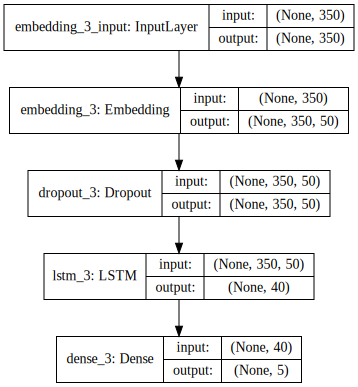

In [ ]:
model_17.summary()
if COLAB:
    display(SVG(model_to_dot(model_17,show_shapes=True,dpi=72).create(prog='dot', format='svg')))
else:
    display(SVG(model_to_dot(model_17,show_shapes=True).create(prog='dot', format='svg')))

#### **Reservamos, dentro del conjunto de *training*, un subconjunto de validación**

In [ ]:
# Entreno sobre X_tr,y_tr monitorizo el aprendizaje sobre X_va,y_va
X_tr, X_va, y_tr, y_va = train_test_split(X_train_pad, y_train, test_size=0.3, random_state=1)
print(X_tr.shape, len(y_tr))
print(X_va.shape, len(y_va))

(2450, 350) 2450
(1050, 350) 1050


#### **Entrenamiento del modelo**

In [ ]:
batch_size = 512
nepocas = 100

best_val_acc  = 0
best_val_loss = 1e20
best_i        = 0

best_weights = []
acum_tr_acc = []
acum_tr_loss = []
acum_val_acc = []
acum_val_loss = []

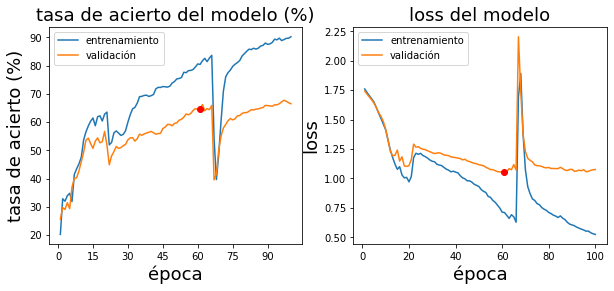

In [ ]:
for e in range(nepocas):
  h = model_17.fit(X_tr, y_tr,
                batch_size=batch_size,
                validation_data=(X_va, y_va),
                epochs=1, verbose=1)
  
  acum_tr_acc  = acum_tr_acc  + h.history['accuracy']
  acum_tr_loss = acum_tr_loss + h.history['loss']
  val_acc  = h.history['val_accuracy'][0]
  val_loss = h.history['val_loss'][0]
  acum_val_acc  = acum_val_acc  + [val_acc]
  acum_val_loss = acum_val_loss + [val_loss]
#  if val_acc  > best_val_acc:
  if val_loss < best_val_loss:
    best_i        = len(acum_val_acc)-1
    best_val_acc  = val_acc
    best_val_loss = val_loss
    best_weights = model_17.get_weights().copy()
  if len(acum_tr_acc)>1 and (len(acum_tr_acc)+1) % 1 == 0:
    if e>1:
      clear_output()
    grafica_entrenamiento(acum_tr_acc, acum_val_acc, acum_tr_loss, acum_val_loss, best_i)

In [ ]:
model_17.set_weights(best_weights)

In [ ]:
scores = model_17.evaluate(X_test_pad, y_test, verbose=1)
print("Accuracy in test: %.2f%%" % (scores[1]*100))

1500/1500 [==============================] - 2s 1ms/step
Accuracy in test: 64.53%


### **17.4: Análisis del *embedding***

In [ ]:
def most_similar_words(embedding,word,n=10):
  n_latent_dimensions = np.shape(embedding)[1]
  ind = word2int[word]
  aux = np.reshape(embedding[ind,:], (1,n_latent_dimensions))
  dists = pairwise_distances(aux, embedding).flatten()
  inds = dists.argsort().tolist()
  inds.remove(ind)
  return [int2word[i] for i in inds[:n]]

embedding = model_17.get_weights()[0]
embedding.shape

(2500, 50)

In [ ]:
most_similar_words(embedding,'alzheimer')

["'s",
 'amyloid',
 'disease',
 'dementia',
 'abeta',
 'mum',
 'ad',
 'b',
 'ache',
 'memory']

In [ ]:
most_similar_words(embedding,'bladder')

['urothelial',
 'bca',
 'prostate',
 'recurrence',
 'cystectomy',
 'aggressive',
 'invasive',
 'radical',
 'muscle',
 'bc']

In [ ]:
most_similar_words(embedding,'breast')

['tnbc',
 'cytotoxic',
 'targeted',
 'mammary',
 'malignancy',
 'er',
 'metastatic',
 'trastuzumab',
 'luminal',
 'axillary']

In [ ]:
most_similar_words(embedding,'cervical')

['hpv',
 'hela',
 'cc',
 'cin',
 'vaccine',
 'cervix',
 'pap',
 'vaccination',
 'squamous',
 'sexual']

In [ ]:
most_similar_words(embedding,'negative')

['toward',
 'off',
 'sites',
 'familial',
 'given',
 'no',
 'combination',
 'also',
 'even',
 'aberrant']

## **18. Experimento 18**

A continuación, vamos a indicar los valores utilizados para los hiperparámetros. En este caso, son los siguientes:

**VALORES QUE SE USARÁN PARA LOS HIPERPARÁMETROS**:


*   **top_words** = 2500
*   **max_review_length** = 350
*   **embedding_vector_length** = 50
*   **n_neurons** = 40
*   **l** = 0.0001 (regularizador L1)
*   **Dropout**(rate = 0.3)



En este caso, en vista de que usar otros regularizadores no aporta mejoras en el *accuracy* del modelo en comparación con el obtenido en el experimento 12 (que usaba el regularizador L1), hemos decidido, en este último experimento, seguir usando el L1 pero subiendo ligeramente su valor, para tratar de mejorar el *gap* existente entre las gráficas de entrenamiento y validación (es decir, estrecharlo) sin mermar demasiado el *accuracy*. Por tanto, hemos indicado l=0.0001.

### **18.1: Determinación de las palabras más frecuentes**

In [ ]:
top_words = 2500 # HYPERPARAMETER, VOCABULARY SIZE

tk = Tokenizer(oov_token='(oov)', num_words=(top_words-1))
tk.fit_on_texts(data_train["text"])

In [ ]:
X_train  = [np.array([0] + x)+1 for x in tk.texts_to_sequences(data_train["text"])]
X_test   = [np.array([0] + x)+1 for x in tk.texts_to_sequences(data_test["text"])]

In [ ]:
X_train[0]

array([   1,    2,    2,   27,  490,   23,  869,    8,  197,    4, 2364,
          2,    2,    2,    2,    9,   30,    2, 2279,    2,    5,  836,
        809,  555,   53,    9,    3,  762,    8,  787,  166,  386, 1310,
          9,    8,  508,    4,    2, 1396,  230,   39,   13,  159,    9,
          2,  543, 2016,    9,  700,    2,    2,  424,    5,  621,    2,
          2, 2401, 1325,   11,  101,    7,   43,   30,    2,    2,    5,
        251, 1616,    2,    2,    9,    8, 2402, 2279,    9, 1953,    4,
       1415,  354, 1325,    2,   20,  166, 1299,    9, 2279,    2,    2,
          2,   18,  214,    2,    2,  424,    2,    8,    2,    2,    2,
       1325,  540,    2,   65,  155, 1299,    9,  187,  189,    4,    2,
        391,    4,    3, 2279,    2,  162,    3,   44,  444,    4,    8,
        480,  397,    4, 1047, 1247,   13, 2403,   11,   51,    2,    5,
       1325,  251,  701,  269, 2049,    2,   27,    8,  490, 1326,   87,
         62,   28,  159, 1483,    9,    2, 2279,   

In [ ]:
min([x.min() for x in X_train]), max([x.max() for x in X_train]), min([x.min() for x in X_test]), max([x.max() for x in X_test])

(1, 2499, 1, 2499)

In [ ]:
int2word = {(i+1):tk.index_word[i] for i in range(1,top_words-1)} # el 0 no está incluido, se reserva para padding
int2word[0] = "(padding)"
int2word[1] = "(start)"

word2int = {int2word[i]:i for i in range(top_words)}

In [ ]:
int2word[0], int2word[1], int2word[2], int2word[max([x.max() for x in X_train])], word2int["the"] #, word2int["whoopi"]

('(padding)', '(start)', '(oov)', 'experiment', 3)

20 palabras más frecuentes:

In [ ]:
for i in range(20):
    print(i, int2word[i])

0 (padding)
1 (start)
2 (oov)
3 the
4 of
5 and
6 in
7 to
8 a
9 with
10 for
11 was
12 were
13 cancer
14 is
15 patients
16 that
17 0
18 as
19 by


In [ ]:
ejemplo = 1

print(X_train[ejemplo], "\n") #Array con los índices asociados a cada palabra del texto.
print("\033[1m"+"Índices y sus palabras asociadas:")
for i,x in enumerate(X_train[ejemplo][:50]):
  print("{} -> {}".format(x, int2word[x])) #Se muestra el índice junto con su palabra asociada.
if (i+1)<len(X_train[ejemplo]): 
  print("...")
print("Class: {}".format(y_train[ejemplo])) 

[   1    3   90   44   13  487    2   14  457    2 1450  723   10    3
  358  311    5 1554  114    3  157  275    4   78   45    2   14    7
    2    2   38    5  782    4  487   15  328  936  363   89  230   18
  124   18  132  230  264    2    3 1641    4    3 1901    4 1379   14
    3    2  165    3    2    6    3    2  763   14    3    2    4    2
    4    2   10  358    5  520  148  114    3  139  151  847  349   28
 1248   21    3    2  328  264   10    3  358  114    4  487  440    2
    4   47 2280 2129    2   47   53    2    2    2   44   47 1249    2
   10    3  176  487  114] 

Índices y sus palabras asociadas:
1 -> (start)
3 -> the
90 -> human
44 -> bladder
13 -> cancer
487 -> bc
2 -> (oov)
14 -> is
457 -> being
2 -> (oov)
1450 -> every
723 -> day
10 -> for
3 -> the
358 -> better
311 -> management
5 -> and
1554 -> efficient
114 -> diagnosis
3 -> the
157 -> primary
275 -> aim
4 -> of
78 -> all
45 -> these
2 -> (oov)
14 -> is
7 -> to
2 -> (oov)
2 -> (oov)
38 -> treatment
5 -

### **18.2: *Padding* de las palabras**

In [ ]:
max_review_length = 350 # HYPERPARAMETER
X_train_pad = sequence.pad_sequences(X_train, maxlen=max_review_length)
X_test_pad = sequence.pad_sequences(X_test, maxlen=max_review_length)
int2word[0] = "(padding)"

print("Tamaño del dataset de training después del padding:", X_train_pad.shape)
print("Los códigos de palabras van de {} a {}".format(X_train_pad.min(), X_train_pad.max()))

Tamaño del dataset de training después del padding: (3500, 350)
Los códigos de palabras van de 0 a 2499


In [ ]:
data_train["text"][1369]

'ureteroarterial fistulas are rare we describe a case of ureteral-arterial fistulas uaf repaired with an endovascular stent graft and examine late complications associated with the procedure a 37-year-old woman with a history of complicated locally invasive cervical cancer treated with chemoradiation presented initially with right leg rest pain and chronic intermittent gross hematuria she was found to have an ureteroarterial fistula and underwent successful endovascular exclusion with a covered stent with resolution of her symptoms she returned 1 year later with stent-graft thrombosis manifesting as lower extremity rest pain requiring a femoral-femoral bypass she then returned 6 months later with imaging evidence of extravascular migration of the stent graft into the bladder because of a poor prognosis of recurrent gynecologic cancer extraction was not attempted and she underwent complete urinary diversion uafs are a rare occurrence but may be treated successfully with endovascular ste

In [ ]:
X_train_pad[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

### **18.3: Construcción de la red neuronal (LSTM)**

In [ ]:
# HYPERPARAMETERS: ***
embedding_vector_length = 50 # HYPERPARAMETER
N_NEURONS = 40
# ********************


N_CLASSES = 5

rnn = LSTM
model_18 = Sequential()
model_18.add(Embedding(top_words, # número de palabras del vocabulario incluido 0 de padding
                    embedding_vector_length, # número de dimensiones que quieres que tenga el embedding
                    # l: "fuerza" del regularizador. Cuanto más alto, más regulariza (pone a 0 componentes)
                    embeddings_regularizer=regularizers.l1(l=0.0001), # regularización (intenta poner a cero componentes)
                    input_length=max_review_length)) # tamaño de la secuencia de palabras
model_18.add(Dropout(rate=0.3))
model_18.add(rnn(N_NEURONS)) # MANY TO ONE (return_sequences no es True)
model_18.add(Dense(N_CLASSES, activation='softmax'))
model_18.compile(loss='sparse_categorical_crossentropy', # binarycrossentropy porque hay 2 clases, si hay más, categorical_crossentropy
              optimizer=Adam(lr=0.001), # lr: velocidad de aprendizaje
              metrics=['accuracy'])

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 350, 50)           125000    
_________________________________________________________________
dropout_4 (Dropout)          (None, 350, 50)           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 40)                14560     
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 205       
Total params: 139,765
Trainable params: 139,765
Non-trainable params: 0
_________________________________________________________________


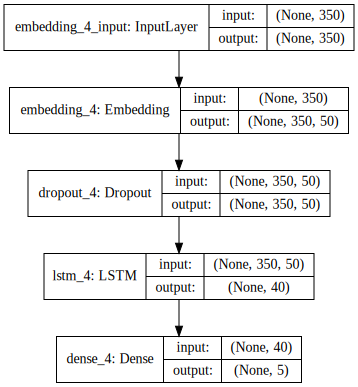

In [ ]:
model_18.summary()
if COLAB:
    display(SVG(model_to_dot(model_18,show_shapes=True,dpi=72).create(prog='dot', format='svg')))
else:
    display(SVG(model_to_dot(model_18,show_shapes=True).create(prog='dot', format='svg')))

#### **Reservamos, dentro del conjunto de *training*, un subconjunto de validación**

In [ ]:
# Entreno sobre X_tr,y_tr monitorizo el aprendizaje sobre X_va,y_va
X_tr, X_va, y_tr, y_va = train_test_split(X_train_pad, y_train, test_size=0.3, random_state=1)
print(X_tr.shape, len(y_tr))
print(X_va.shape, len(y_va))

(2450, 350) 2450
(1050, 350) 1050


#### **Entrenamiento del modelo**

In [ ]:
batch_size = 512
nepocas = 100

best_val_acc  = 0
best_val_loss = 1e20
best_i        = 0

best_weights = []
acum_tr_acc = []
acum_tr_loss = []
acum_val_acc = []
acum_val_loss = []

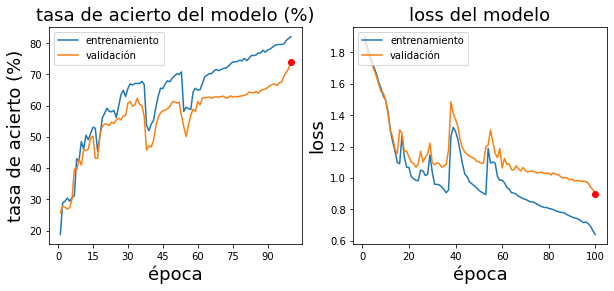

In [ ]:
for e in range(nepocas):
  h = model_18.fit(X_tr, y_tr,
                batch_size=batch_size,
                validation_data=(X_va, y_va),
                epochs=1, verbose=1)
  
  acum_tr_acc  = acum_tr_acc  + h.history['accuracy']
  acum_tr_loss = acum_tr_loss + h.history['loss']
  val_acc  = h.history['val_accuracy'][0]
  val_loss = h.history['val_loss'][0]
  acum_val_acc  = acum_val_acc  + [val_acc]
  acum_val_loss = acum_val_loss + [val_loss]
#  if val_acc  > best_val_acc:
  if val_loss < best_val_loss:
    best_i        = len(acum_val_acc)-1
    best_val_acc  = val_acc
    best_val_loss = val_loss
    best_weights = model_18.get_weights().copy()
  if len(acum_tr_acc)>1 and (len(acum_tr_acc)+1) % 1 == 0:
    if e>1:
      clear_output()
    grafica_entrenamiento(acum_tr_acc, acum_val_acc, acum_tr_loss, acum_val_loss, best_i)

In [ ]:
model_18.set_weights(best_weights)

In [ ]:
scores = model_18.evaluate(X_test_pad, y_test, verbose=1)
print("Accuracy in test: %.2f%%" % (scores[1]*100))

1500/1500 [==============================] - 3s 2ms/step
Accuracy in test: 74.80%


### **18.4: Análisis del *embedding***

In [ ]:
def most_similar_words(embedding,word,n=10):
  n_latent_dimensions = np.shape(embedding)[1]
  ind = word2int[word]
  aux = np.reshape(embedding[ind,:], (1,n_latent_dimensions))
  dists = pairwise_distances(aux, embedding).flatten()
  inds = dists.argsort().tolist()
  inds.remove(ind)
  return [int2word[i] for i in inds[:n]]

embedding = model_18.get_weights()[0]
embedding.shape

(2500, 50)

In [ ]:
most_similar_words(embedding,'alzheimer')

['dementia',
 'ad',
 'abeta',
 "'s",
 'amyloid',
 'disease',
 'ache',
 'discovery',
 'compounds',
 'memory']

In [ ]:
most_similar_words(embedding,'bladder')

['urothelial',
 'bca',
 '2016',
 'cystectomy',
 'prostate',
 'ileal',
 'tumors',
 'muscle',
 'strategies',
 'radical']

In [ ]:
most_similar_words(embedding,'breast')

['tnbc',
 'cancer',
 'targeted',
 'mutations',
 'metastatic',
 'malignancy',
 'appropriate',
 'mri',
 'cells',
 'biopsy']

In [ ]:
most_similar_words(embedding,'cervical')

['hpv',
 'carcinoma',
 'hela',
 'screening',
 'cervix',
 'biopsy',
 'cytology',
 'comparable',
 'therapy',
 'single']

In [ ]:
most_similar_words(embedding,'negative')

['apoptosis',
 'positive',
 'mammary',
 'precision',
 'routine',
 'skin',
 'luminal',
 'mcf',
 'epithelial',
 'cytotoxic']

## **19. Resumen**

### **19.1: Técnicas de limpieza y pre-procesado de los textos**

Tal y como hemos visto al inicio de la práctica, tras cargar los paquetes necesarios y los *datasets*, hemos tenido que limpiar los *abstracts* antes de la obtención de las palabras más frecuentes y construir los modelos de redes neuronales expuestos anteriormente. Para ello, hemos eliminado los espaciados repetidos, borrado las cabeceras de las distintas secciones de cada *abstract* para todas las clases (alzheimer, bladder_cancer, breast_cancer, negative y cervical_cancer), transformado los *datasets* en minúscula y eliminado los signos de puntuación. Al final, obteníamos la tabla siguiente:

In [ ]:
data_lower

,id,title,abstract,text,type
0,27816982,cytology at the time of some things to think about when discussing hpv.,"'in the current 28 member states of the european union (eu), approximately 34,000 new cases of c...","'in the current 28 member states of the european union eu approximately 34,000 new cases of cerv...",cervical_cancer
1,27092587,production of precursors for anti-alzheimer drugs: asymmetric bioreduction in a packed-bed biore...,"(s)-1-phenylethanol derivatives, which are the precursors of many pharmacological products, have...",s -1-phenylethanol derivatives which are the precursors of many pharmacological products have al...,alzheimer
2,27486640,empagliflozin (jardiance). type 2 diabetes: no rush to use this drug.,"* in early 2016, metformin monotherapy remains the treatment of choice for most patients with ty...",in early 2016 metformin monotherapy remains the treatment of choice for most patients with type ...,bladder_cancer
3,27382284,a stabilizer-free and organic solvent-free method to prepare 10-hydroxycamptothecin nanocrystals...,10-hydroxycamptothecin (10-hcpt) is a promising anticancer drug with a wide spectrum of antitumo...,10-hydroxycamptothecin 10-hcpt is a promising anticancer drug with a wide spectrum of antitumor ...,negative
4,27354798,elimination of the biphasic pharmacodynamics of 15d-pgj2 by controlling its release from a nanoe...,"15-deoxy-delta12,14-prostaglandin j2 (15d-pgj2) has a dual action of stimulating anti-inflammati...","15-deoxy-delta12,14-prostaglandin j2 15d-pgj2 has a dual action of stimulating anti-inflammation...",negative
...,...,...,...,...,...
4995,28000900,"mir-24-3p regulates bladder cancer cell proliferation, migration, invasion and autophagy by targ...","micrornas (mirnas), a class of small non-coding rna molecules, can regulate gene expression by i...",micrornas mirnas a class of small non-coding rna molecules can regulate gene expression by inter...,bladder_cancer
4996,26919225,the role of urinary ph in o-phenylphenol-induced cytotoxicity and chromosomal damage in the blad...,o-phenylphenol (opp) is a widely used fungicide and antibacterial agent that at high doses has b...,o-phenylphenol opp is a widely used fungicide and antibacterial agent that at high doses has bee...,bladder_cancer
4997,27199504,prognostic and clinicopathological significance of downregulated p16 expression in patients with...,"p16, encoded by the cdkn2a gene, is a tumor suppressor that has been widely studied in cancer re...",p16 encoded by the cdkn2a gene is a tumor suppressor that has been widely studied in cancer rese...,bladder_cancer
4998,27222134,p21 and p27 immunoexpression in upper urinary tract urothelial carcinomas.,"p21 and p27 are members of cyclin-dependent kinase family, which function as tumor suppressors a...",p21 and p27 are members of cyclin-dependent kinase family which function as tumor suppressors an...,bladder_cancer


---

**INCISO**: En un principio, también se iban a procesar los números de los textos, por medio del siguiente comando:

In [ ]:
data_processed_numbers=data_lower["text"].apply(lambda x: re.sub('([^A-Za-z\d-])[\d]+\.*[\d]*', r'\1NUM', x))
data_processed_numbers

0       'in the current NUM member states of the european union eu approximately NUM,NUM new cases of ce...
1       s -1-phenylethanol derivatives which are the precursors of many pharmacological products have al...
2       in early NUM metformin monotherapy remains the treatment of choice for most patients with type N...
3       10-hydroxycamptothecin NUM-hcpt is a promising anticancer drug with a wide spectrum of antitumor...
4       15-deoxy-delta12,NUM-prostaglandin j2 NUMd-pgj2 has a dual action of stimulating anti-inflammati...
                                                       ...                                                 
4995    micrornas mirnas a class of small non-coding rna molecules can regulate gene expression by inter...
4996    o-phenylphenol opp is a widely used fungicide and antibacterial agent that at high doses has bee...
4997    p16 encoded by the cdkn2a gene is a tumor suppressor that has been widely studied in cancer rese...
4998    p21 and p27 are memb

Sin embargo, este procedimiento demostró empeorar considerablemente el *performance* de las redes neuronales generadas en la gran mayoría de los casos; de ahí que se haya decidido no incluir este paso dentro del procedimiento de limpieza de los textos.

---

Por otro lado, respecto a las técnicas de pre-procesado de los textos ya limpios, si recordamos, lo que hicimos fue tomar, en primer lugar, cada uno de los *abstracts* de tanto la partición *training* como la *test* y extraer las n palabras más frecuentes (lo cual podíamos escoger por medio de la variable *top_words*). A cada palabra se le asignó un identificador numérico, teniendo en cuenta que el 0, el 1 y el 2 se les asigna a (padding), (start) y (oov), respectivamente. Tras esto, mediante *padding*, normalizamos el tamaño de los textos lo cual se podía modificar a gusto del usuario por medio de la variable *max_review_length*. Por tanto, para el pre-procesado de los textos ya limpios, hemos ido variando los valores de estos dos hiperparámetros: *top_words* y *max_review_length*.

### **19.2: Técnicas de "embedding" utilizadas**

En esta parte de la práctica de esta asignatura, tras la limpieza y el pre-procesado de los *abstracts*, obteníamos dos variables: "X_train_pad" y "X_test_pad", tras haber normalizado los textos. Luego, si recordamos, tomábamos la variable "X_train_pad", correspondiente a la partición *training*, y la dividíamos a su vez en un subconjunto de entrenamiento y otro de validación para el entrenamiento de las redes neuronales. A la hora de diseñar el modelo, recurríamos a dos clases principales de Keras: LSTM y Embedding. 

Concretamente, en estas redes neuronales partíamos de una capa "input", correspondiente a nuestros datos ya limpios y pre-procesados, y éstos pasaban por la "embedding layer", en donde los identificadores numéricos de las palabras de los *abstracts* se transformaban en vectores. Para definir esta capa "embedding", si recordamos, tuvimos que indicar el tamaño del vocabulario (variable *top_words*), el tamaño de los vectores de la capa "embedding" (variable *embedding_vector_length*), el regularizador que se iba a utilizar (variable *embeddings_regularizer*) y la longitud de los textos (variable *max_review_length*). Tras generar la capa "embedding", revisando la celda de código correspondiente, se definía el Dropout, la red neuronal en base al número de neuronas indicado (variable *n_neurons*) y se establecía el número de clases.

Por consiguiente, a la hora de crear la capa "embedding" de la red neuronal a partir de los *arrays* de identificadores numéricos para cada texto (capa "input"), es necesario modificar las variables mencionadas anteriormente, las cuales hemos ido cambiando a lo largo de los distintos experimentos expuestos anteriormente en este informe, con tal de mejorar el *performance* de los modelos.

Cabe señalar que no se han utilizado en esta práctica otros *word embeddings* ya preexistentes, como *word2vec*, para no hacer el informe demasiado extenso.

### **19.3: Modelos de redes neuronales artificiales**

Si recordamos, hemos evaluado 18 redes neuronales distintas, las cuales han sido obtenidas modificando en cada experimento alguno/s valor/es de algún/os hiperparámetro/s de aquellos disponibles para ser calibrados. La calidad de los modelos se ha medido por medio de su *accuracy* sobre el *validation set* obtenido en base al *training set* extraído al inicio del informe a partir de los 5000 *abstracts* de los *datasets* de la práctica. A continuación, se muestra una tabla resumiendo los resultados obtenidos para cada red neuronal:
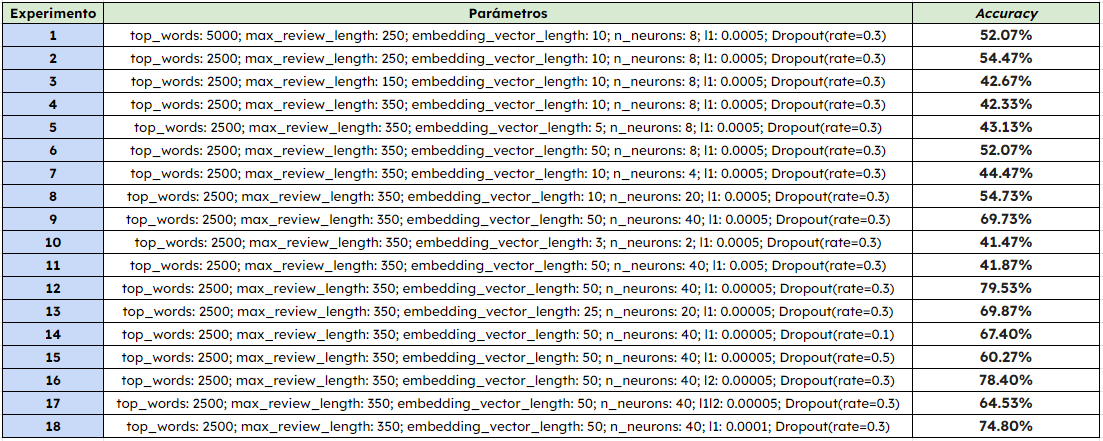

Como hemos podido corroborar a lo largo de los experimentos expuestos anteriormente, los hiperparámetros que hemos ido modificando en cada uno de ellos son responsables de la precisión y la capacidad predictiva de las redes neuronales generadas en los mismos. 

A modo de resumen, la variable *top_words* era la responsable de definir la longitud del vocabulario de palabras frecuentes, de forma que el valor que lleve asociada esta variable influye en cuántos términos serán empleados para entrenar nuestros modelos de aprendizaje automático. 

Por otra parte, recordemos que la variable *max_review_length* definía el tamaño al que pasarían a tener todos los textos del *training set* de nuestro *dataset* original de 5000 artículos científicos (normalización del tamaño). Por tanto, es también fundamental escoger un buen valor de este hiperparámetro con tal de que no se pierda información de los mismos al escoger un valor hipotéticamente bajo. 

Por su parte, el hiperparámetro *embedding_vector_length* definía el tamaño de los vectores en los que eran transformados los índices numéricos que obteníamos tras el proceso de *padding*. En este caso, también es importante escoger un buen tamaño que maximice el *performance* del modelo, algo que depende del tamaño de los datos sobre los que se vaya a entrenar el modelo. 

Por otro lado, el número de neuronas (variable *n_neurons*) también es un hiperparámetro cuyo valor influye de forma considerable en el *performance* de la red neuronal. Por lo general, un mayor número de neuronas mejora el *performance*, si bien esto ralentiza el proceso de entrenamiento de la red, y también hay ocasiones en las que incrementar este valor no aporta mejoras significativas en el *accuracy*, que es la medida cuantitativa que hemos usado para evaluar el *performance* de los modelos, luego es importante tratar de escoger un valor óptimo para este parámetro.

Respecto a la regularización, ésta ha sido implementada con el fin de minimizar la función de *loss* y reducir el *overfitting* (efectivamente, hemos visto que a ciertos valores de *l* había menor separación entre las gráficas de entrenamiento y validación (menos *overfitting*) y se daba lo contrario a otros valores de *l*), cuyo valor hemos intentado optimizar con tal de minimizar el grado de separación entre las gráficas de entrenamiento y validación sin reducir el *accuracy* del modelo.

Finalmente, por medio de la clase *Dropout* de *Keras*, hemos introducido ruido aleatorio en los datos a una tasa concreta, con el fin de mejorar dentro de lo posible el *performance* del modelo, tratando asimismo de no utilizar un valor muy alto ya que esto implicaría la pérdida de información relevante de los textos. 

Tal y como podemos apreciar, en definitiva, parece ser que los valores de los hiperparámetros indicados para el experimento 12 han resultado ser los más apropiados, dando lugar a un *accuracy* del prácticamente 80%. Sin embargo, veíamos en dicho experimento un *gap* más o menos considerable entre las gráficas de entrenamiento y validación tanto en la gráfica de acierto del modelo como en la de *loss*. Es por eso por lo que se realizaron más experimentos, bien cambiando el regularizador a L2 o bien combinando L1 o L2; o también subiendo ligeramente el valor del regularizador L1, aunque era complejo hallar unos valores de los hiperparámetros que diesen lugar a un buen *accuracy* del modelo sin que hubiese un *gap* entre dichas gráficas.

Al final, en el experimento 18, el último expuesto en este informe, se obtiene un valor de *accuracy* ligeramente inferior al respecto, pero aun así muy bueno (74.8%), y las gráficas presentan un *gap* más estrecho entre ambas en este caso. 

Por tanto, buscando aumentar lo más posible el *accuracy*, pero tratando de reducir la separación entre dichas gráficas, podríamos decir que el modelo más apropiado es el 18 (aunque el modelo 16 también tiene un *accuracy* muy bueno (78.4%), sigue habiendo bastante separación entre dichas gráficas), aunque los modelos 12 y 16 no se quedan atrás. En cualquier caso, dichos modelos han demostrado poder hallar eficientemente las palabras más relacionadas con cada una de las 5 clases de esta práctica, una para cada *dataset* (alzheimer, bladder_cancer, breast_cancer, cervical_cancer y negative), aunque habría que tratar de hallar unos valores de los hiperparámetros que permitiesen obtener un *accuracy* óptimo y el mínimo grado de separación entre las gráficas posible.

## **20. Referencias**

1. https://keras.io/api/layers/regularization_layers/dropout/
2. https://keras.io/api/layers/regularizers/
3. https://keras.io/api/layers/recurrent_layers/lstm/
4. https://stackoverflow.com/questions/51328516/what-embedding-layer-output-dim-is-really-needed-for-a-dictionary-of-just-10000
5. https://keras.io/api/layers/core_layers/embedding/
6. https://www.projectpro.io/recipes/add-regularization-regression-keras